This code creates and stores a single model ensemble created from a selection of models. We used a customized CNN, and pretrained models including VGG19, InceptionResnetV2 and SqueezeNet, with their ImageNet weights initialized and fine-tuned end-to-end. The optimal model ensemble is chosen and saved to make further predictions. Five fold cross validation is performed on a patient-specific case.

In [195]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
#tf.config.experimental.list_physical_devices('GPU')
from tensorflow import keras
import tensorflow.keras.backend as K

Tensorflow version : 2.4.1
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [196]:
# Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, concatenate, Dense, Average, Dropout, LeakyReLU, Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Lambda, Activation, Flatten, Convolution1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import np_utils
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras_squeezenet_tf2 import SqueezeNet
from keras_squeezenet_tf2 import SqueezeNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [197]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [198]:
#%% Loading the data

img_width, img_height = 100, 100
train_data_dir = '../data/cell_images/train'
validation_data_dir = '../data/cell_images/test'
epochs = 60
batch_size = 16 
num_classes= 2

# Since the models work with the data of the same shape, we 
#define a single input layer that will be used by every model.

input_shape = (100,100,3)
model_input = Input(shape=input_shape)
print(model_input) 

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_11'), name='input_11', description="created by layer 'input_11'")


In [199]:
#%% declaring image data generators

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=2,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [200]:
#%% assign class weights to balance model training and penalize over-represented classes

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1. 1.]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [201]:
#%% define custom model and instantiate it

def custom_cnn(model_input):
    x = BatchNormalization()(model_input)
    x = Conv2D(64, (5, 5), padding='same', activation='relu', name = 'custom_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name = 'maxpool1')(x)
    x = Dropout(0.25, name = 'conv_dropout1')(x)
    x = BatchNormalization(name = 'custom_batchnorm1')(x)
    x = Conv2D(128, (5, 5), padding='same', activation='relu', name = 'custom_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool2')(x)
    x = Dropout(0.25, name = 'conv_dropout2')(x)
    x = BatchNormalization(name = 'custom_batchnorm2')(x)
    x = Conv2D(256, (5, 5), padding='same', activation='relu', name = 'custom_conv3')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool3')(x)
    x = Dropout(0.25, name = 'conv_dropout3')(x)
    x = GlobalAveragePooling2D(name = 'custom_GAP')(x)
    x = Dense(256, activation='relu', name = 'custom_dense1')(x)
    x = Dropout(0.5, name = 'dense_dropout1')(x)
    x = Dense(num_classes, activation='softmax', name = 'custom_dense2')(x)
    model = Model(inputs=model_input, outputs=x, name='custom_cnn')
    return model

#instantiate the model
custom_model = custom_cnn(model_input)

#display model summary
custom_model.summary()

#plot the model
#plot_model(custom_model, to_file='custom_model.png',show_shapes=True, show_layer_names=False)


Model: "custom_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
batch_normalization_1838 (Ba (None, 100, 100, 3)       12        
_________________________________________________________________
custom_conv1 (Conv2D)        (None, 100, 100, 64)      4864      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 50, 50, 64)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 50, 50, 64)        0         
_________________________________________________________________
custom_batchnorm1 (BatchNorm (None, 50, 50, 64)        256       
_________________________________________________________________
custom_conv2 (Conv2D)        (None, 50, 50, 128)       2

In [202]:
#%% VGG19 model 

def vgg19_cnn(model_input):
    vgg19_cnn = VGG19(weights='imagenet', include_top=False, input_tensor=model_input)
    x = vgg19_cnn.layers[-2].output 
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg19_cnn.input, outputs=predictions, name='vgg19_custom')
    return model

#instantiate the model
vgg19_custom_model = vgg19_cnn(model_input)

#plot model summary
vgg19_custom_model.summary()
#plot_model(vgg19_custom_model, to_file='vgg19_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "vgg19_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [203]:
#%% SqueezeNet 

def squeeze_cnn(model_input):
    squeeze_cnn = SqueezeNet(weights='imagenet', include_top=False, input_tensor=model_input)
    x = squeeze_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=squeeze_cnn.input, outputs=predictions, name='squeeze_custom')
    return model

#instantiate the model
squeeze_custom_model = squeeze_cnn(model_input)

#display model summary
squeeze_custom_model.summary()

#plot model
#plot_model(squeeze_custom_model, to_file='squeeze_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "squeeze_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_11[0][0]                   
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
_____________________________________________________________________________________

In [204]:
#%% Inception ResnetV2 

def incepres_cnn(model_input):
    incepres_cnn = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=model_input)
    x = incepres_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=incepres_cnn.input, outputs=predictions, name='InceptionResnet_custom')
    return model

#instantiate the model
inceptionresnet_custom_model = incepres_cnn(model_input)

#display model summary
inceptionresnet_custom_model.summary()

#plot model
#plot_model(inceptionresnet_custom_model, to_file='inceptionresnet_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "InceptionResnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1827 (Conv2D)            (None, 49, 49, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1839 (Batch (None, 49, 49, 32)   96          conv2d_1827[0][0]                
__________________________________________________________________________________________________
activation_1827 (Activation)    (None, 49, 49, 32)   0           batch_normalization_1839[0][0]   
_____________________________________________________________________________

                                                                 activation_1993[0][0]            
__________________________________________________________________________________________________
block8_1_conv (Conv2D)          (None, 1, 1, 2080)   933920      block8_1_mixed[0][0]             
__________________________________________________________________________________________________
block8_1 (Lambda)               (None, 1, 1, 2080)   0           mixed_7a[0][0]                   
                                                                 block8_1_conv[0][0]              
__________________________________________________________________________________________________
block8_1_ac (Activation)        (None, 1, 1, 2080)   0           block8_1[0][0]                   
__________________________________________________________________________________________________
conv2d_1995 (Conv2D)            (None, 1, 1, 192)    399360      block8_1_ac[0][0]                
__________

In [205]:
#%% compile and train the custom model

adam = Adam(lr=0.001)  
metric = 'val_accuracy'
custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1) 


Epoch 1/60
1377/1377 [==============================] - 67s 48ms/step - loss: 0.6820 - accuracy: 0.6583 - val_loss: 0.1780 - val_accuracy: 0.9415
Epoch 2/60
1377/1377 [==============================] - 62s 45ms/step - loss: 0.2717 - accuracy: 0.9119 - val_loss: 0.1418 - val_accuracy: 0.9535
Epoch 3/60
1377/1377 [==============================] - 62s 45ms/step - loss: 0.2446 - accuracy: 0.9203 - val_loss: 0.1379 - val_accuracy: 0.9520
Epoch 4/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.2213 - accuracy: 0.9267 - val_loss: 0.1340 - val_accuracy: 0.9564
Epoch 5/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.2218 - accuracy: 0.9242 - val_loss: 0.1309 - val_accuracy: 0.9575
Epoch 6/60
1377/1377 [==============================] - 63s 45ms/step - loss: 0.2106 - accuracy: 0.9280 - val_loss: 0.1356 - val_accuracy: 0.9586
Epoch 7/60
1377/1377 [==============================] - 64s 46ms/step - loss: 0.2128 - accuracy: 0.9286 - val_loss: 0.1477 -

1377/1377 [==============================] - 63s 45ms/step - loss: 0.1451 - accuracy: 0.9481 - val_loss: 0.1131 - val_accuracy: 0.9611
Epoch 54/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1454 - accuracy: 0.9492 - val_loss: 0.1154 - val_accuracy: 0.9611
Epoch 55/60
1377/1377 [==============================] - 63s 45ms/step - loss: 0.1452 - accuracy: 0.9472 - val_loss: 0.1106 - val_accuracy: 0.9629
Epoch 56/60
1377/1377 [==============================] - 63s 45ms/step - loss: 0.1417 - accuracy: 0.9491 - val_loss: 0.1128 - val_accuracy: 0.9618
Epoch 57/60
1377/1377 [==============================] - 63s 45ms/step - loss: 0.1441 - accuracy: 0.9472 - val_loss: 0.1133 - val_accuracy: 0.9611
Epoch 58/60
1377/1377 [==============================] - 63s 45ms/step - loss: 0.1428 - accuracy: 0.9485 - val_loss: 0.1116 - val_accuracy: 0.9629
Epoch 59/60
1377/1377 [==============================] - 63s 45ms/step - loss: 0.1436 - accuracy: 0.9458 - val_loss: 0.1100 - val_

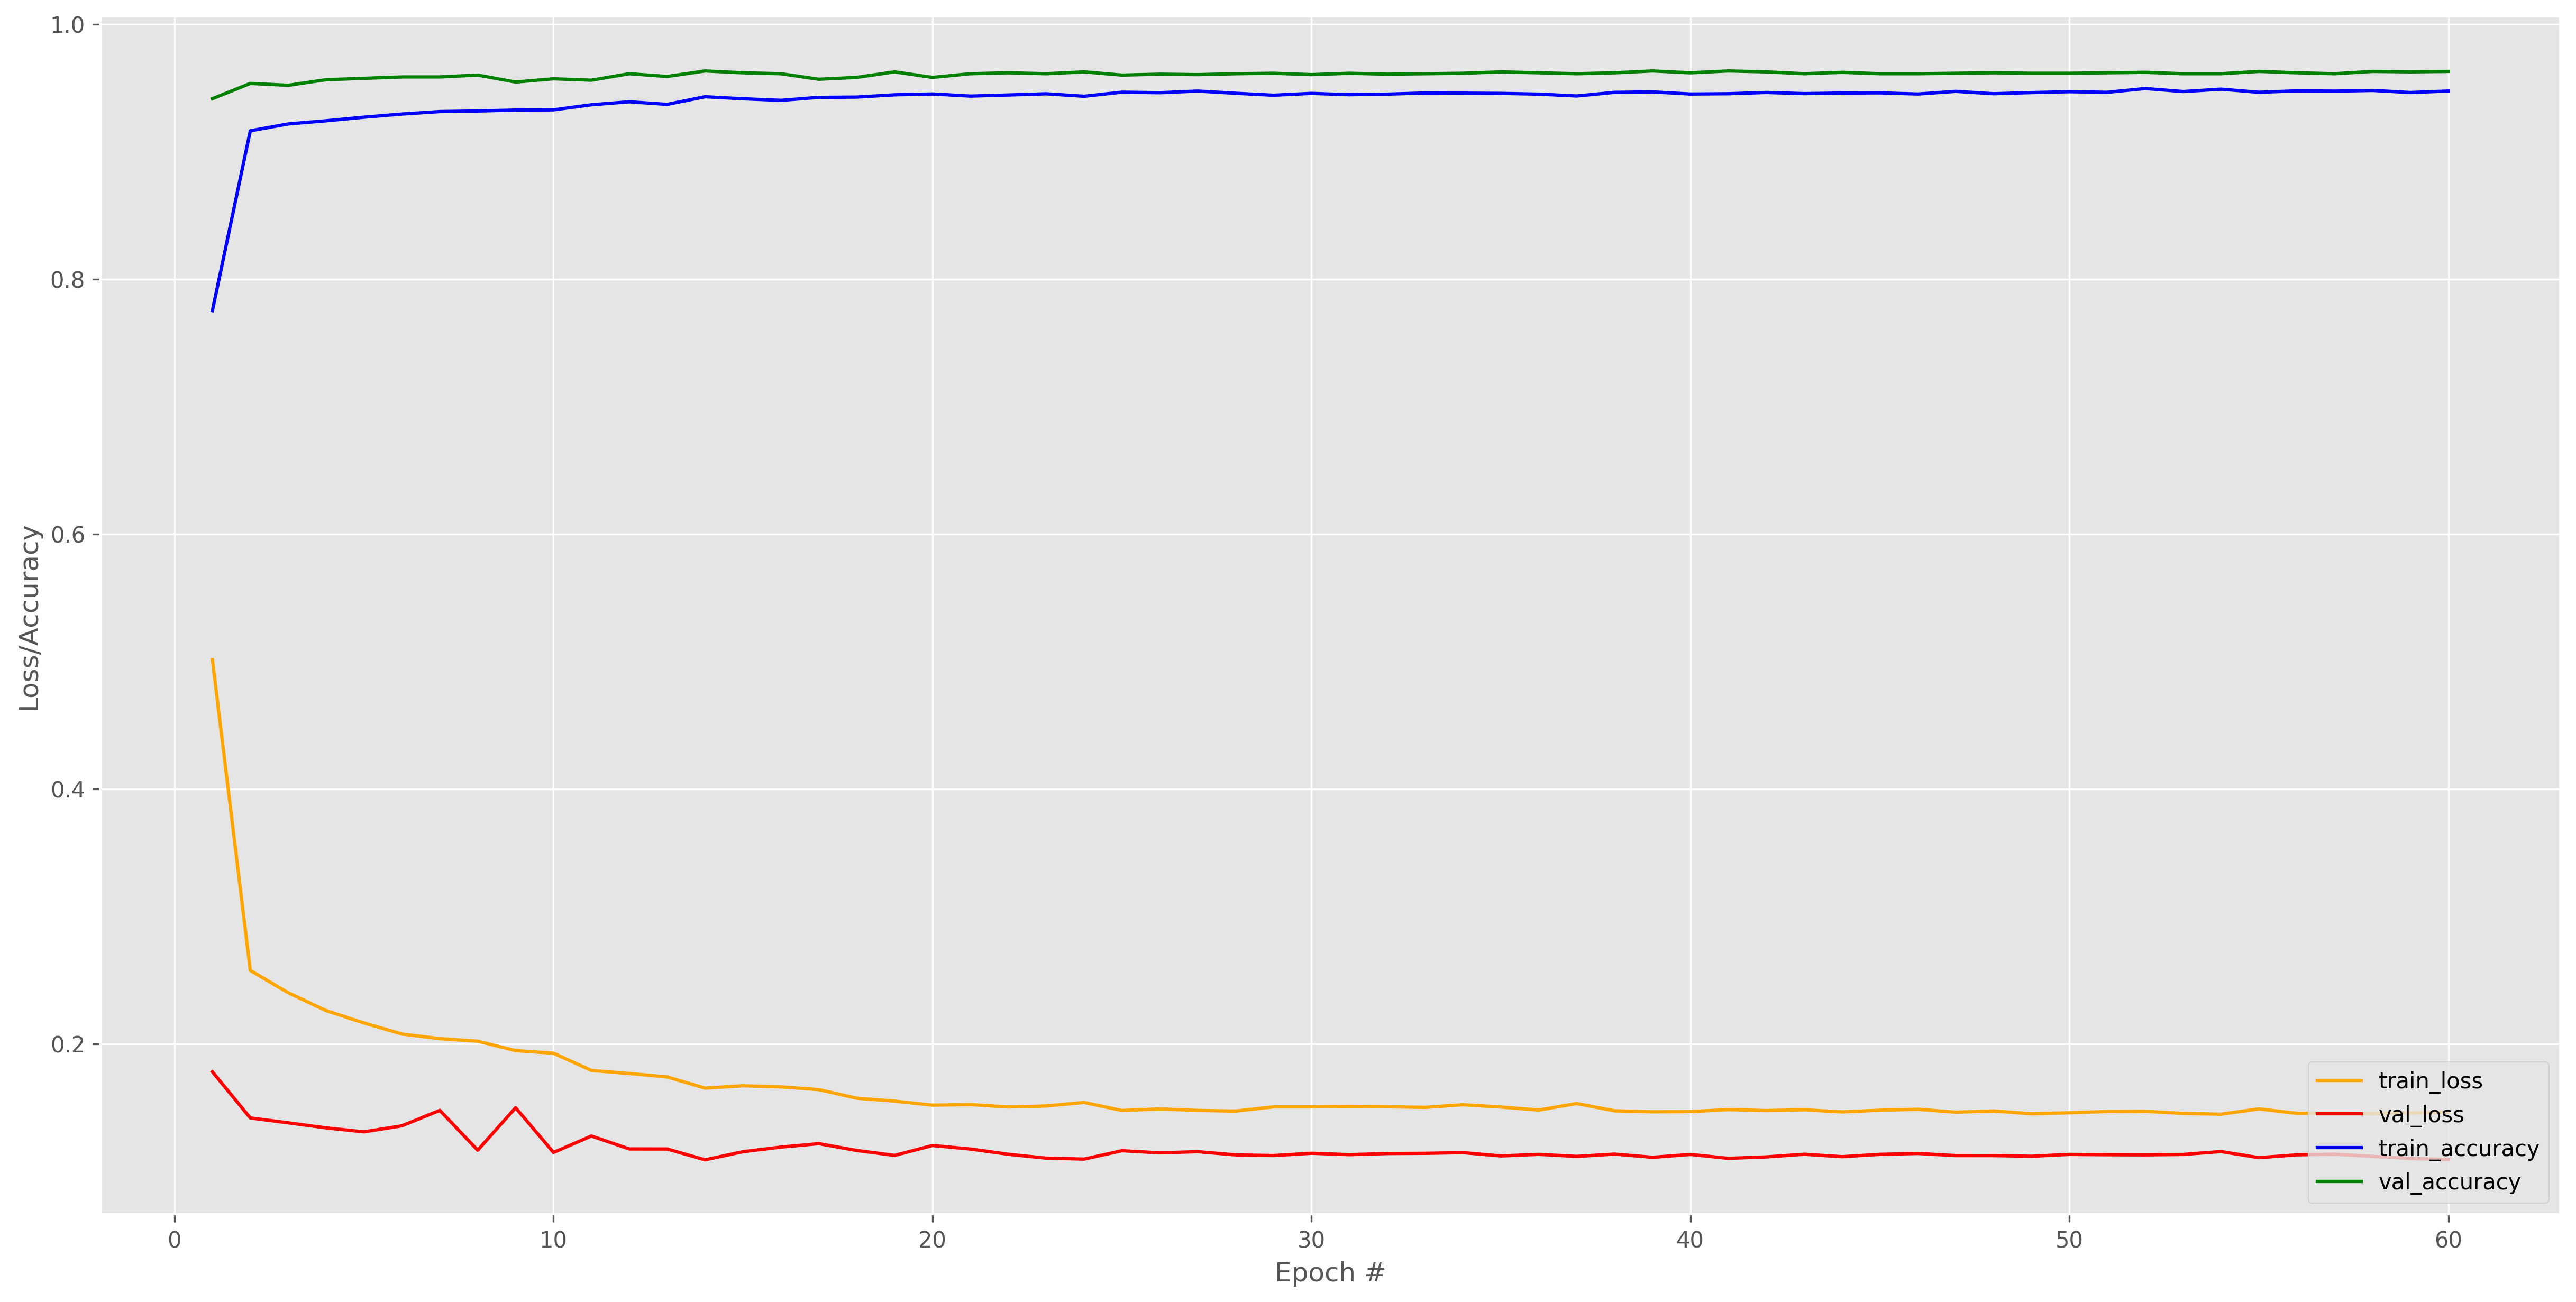

In [206]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("custom_plot.png")

In [207]:
#%% compile and train the VGG19 model

adam = Adam(lr=0.0001)
metric = 'val_accuracy'
vgg19_custom_model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + vgg19_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + vgg19_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = vgg19_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    


Epoch 1/60
1377/1377 [==============================] - 67s 48ms/step - loss: 0.4013 - accuracy: 0.7818 - val_loss: 0.1518 - val_accuracy: 0.9564
Epoch 2/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.2055 - accuracy: 0.9297 - val_loss: 0.1297 - val_accuracy: 0.9600
Epoch 3/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.1953 - accuracy: 0.9322 - val_loss: 0.1438 - val_accuracy: 0.9571
Epoch 4/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.1918 - accuracy: 0.9327 - val_loss: 0.1266 - val_accuracy: 0.9608
Epoch 5/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.1969 - accuracy: 0.9327 - val_loss: 0.1491 - val_accuracy: 0.9600
Epoch 6/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.1748 - accuracy: 0.9392 - val_loss: 0.1136 - val_accuracy: 0.9597

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/60
1377/1377 [=====================

Epoch 55/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.1063 - accuracy: 0.9588 - val_loss: 0.0814 - val_accuracy: 0.9706
Epoch 56/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.0991 - accuracy: 0.9638 - val_loss: 0.0804 - val_accuracy: 0.9713
Epoch 57/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.1038 - accuracy: 0.9609 - val_loss: 0.0785 - val_accuracy: 0.9720
Epoch 58/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.1013 - accuracy: 0.9614 - val_loss: 0.0785 - val_accuracy: 0.9717
Epoch 59/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.0992 - accuracy: 0.9633 - val_loss: 0.0822 - val_accuracy: 0.9724
Epoch 60/60
1377/1377 [==============================] - 65s 48ms/step - loss: 0.0935 - accuracy: 0.9651 - val_loss: 0.0808 - val_accuracy: 0.9720


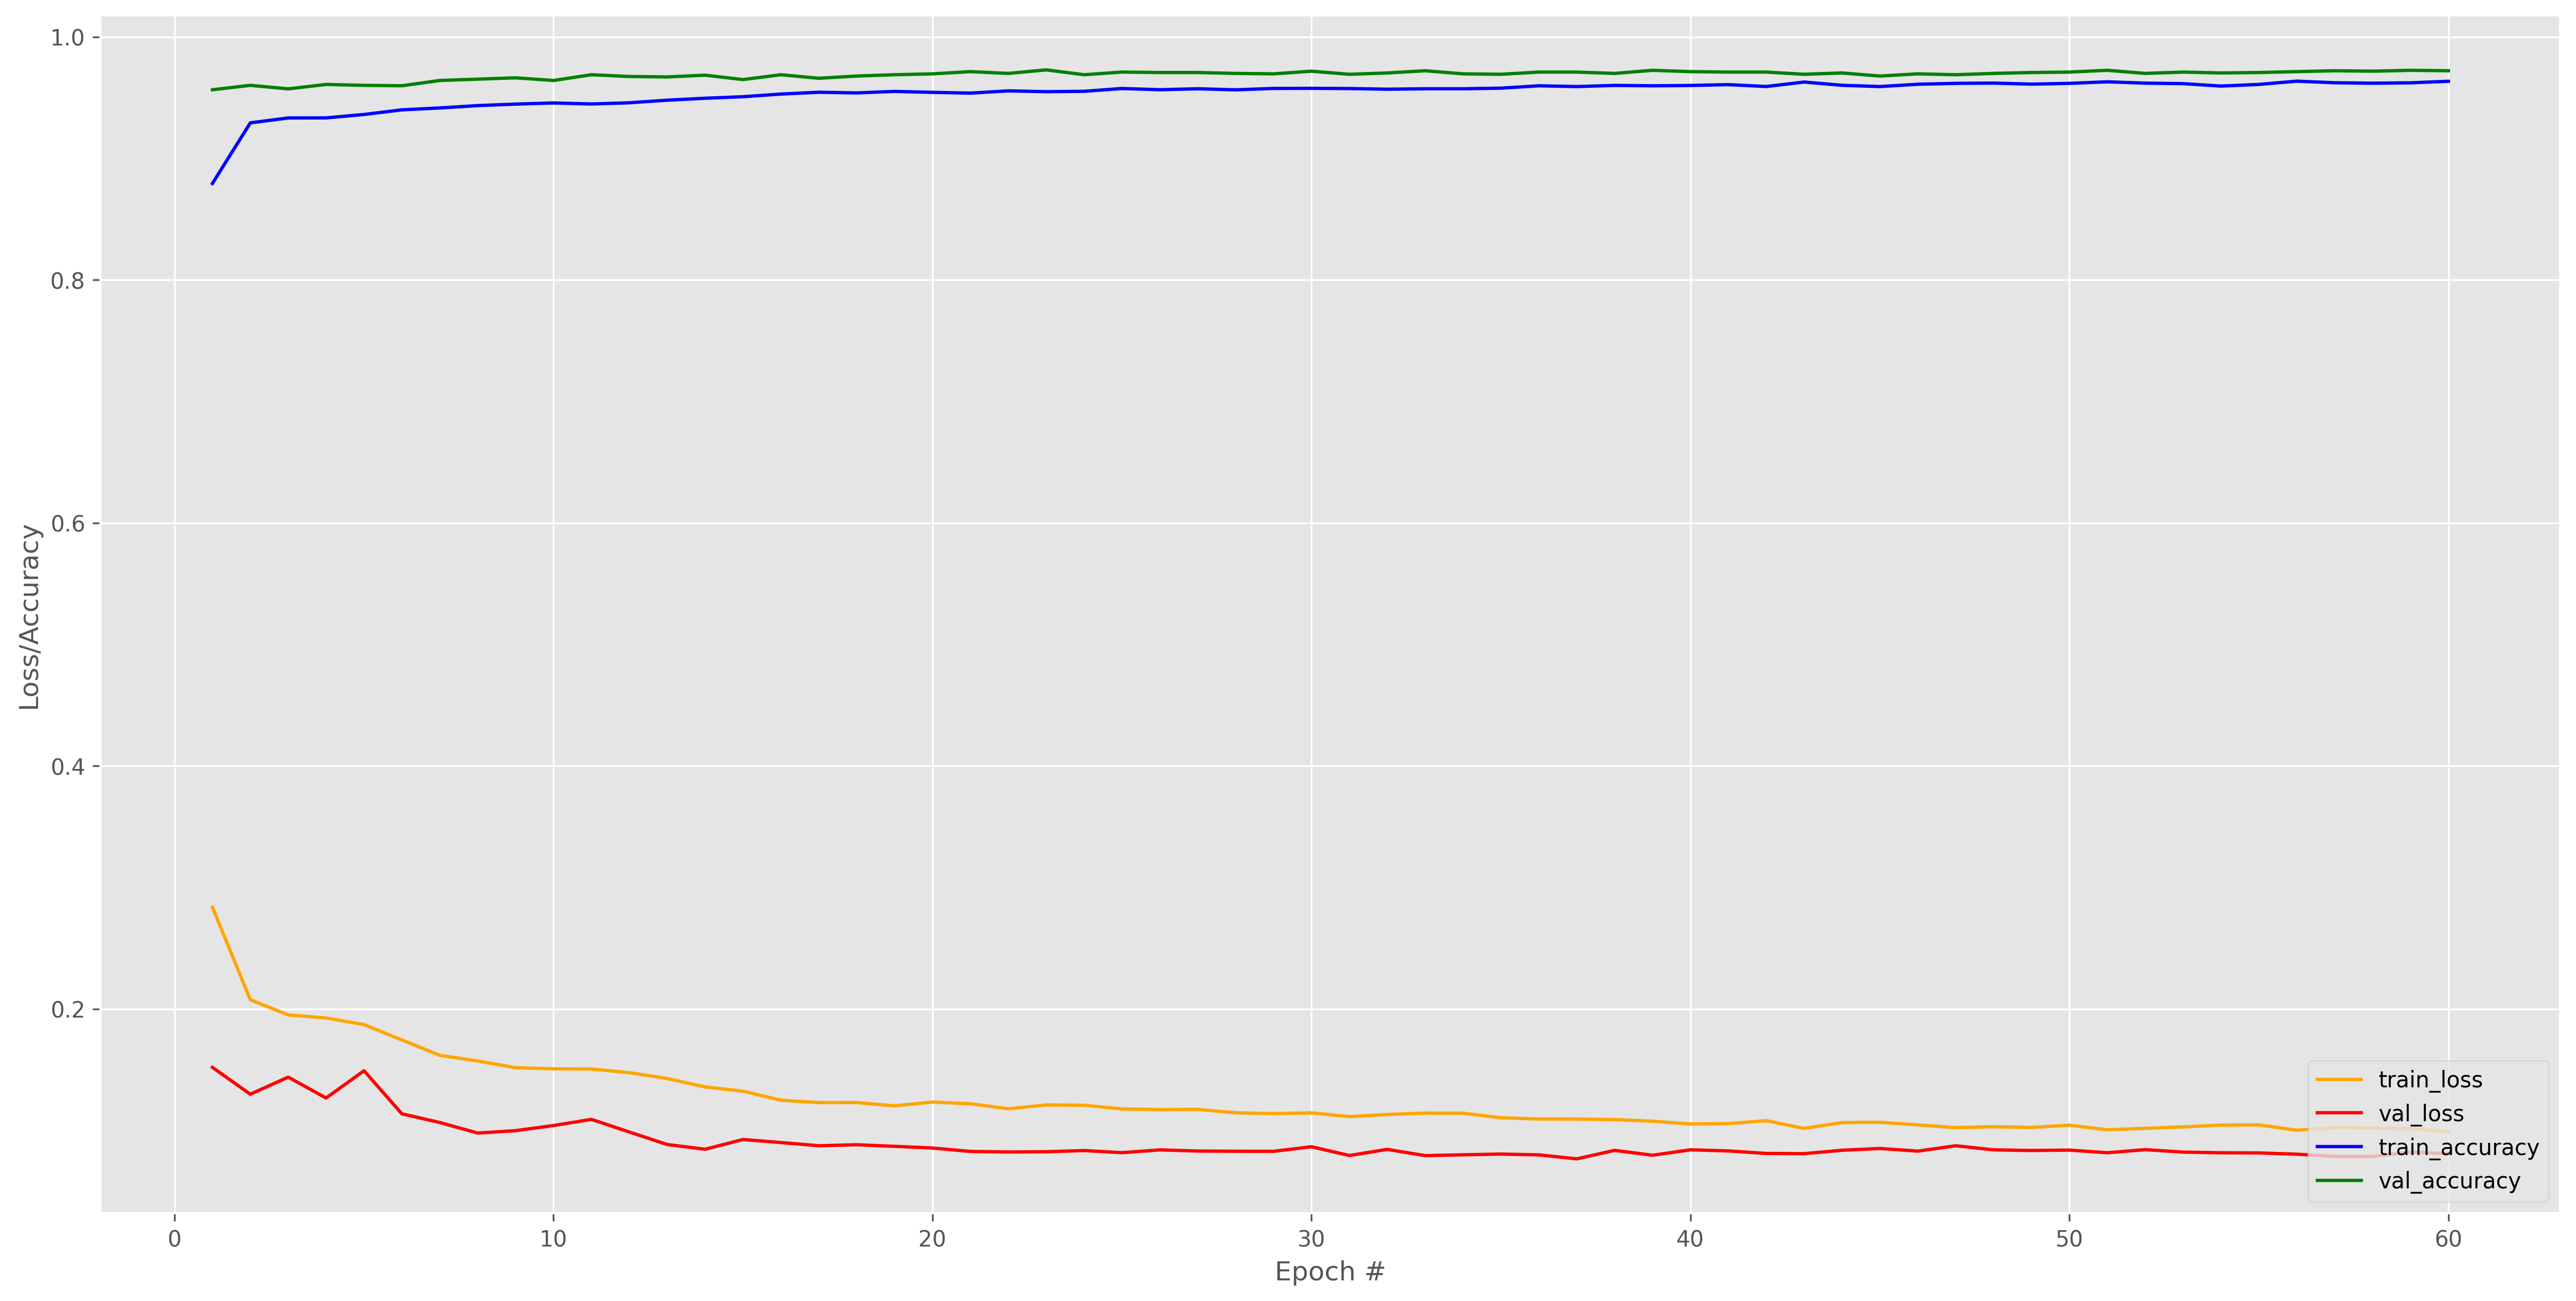

In [208]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("VGG19_custom_plot.png")

In [209]:
#%% compile and train the squeezenet model

adam = Adam(lr=0.0001) 
squeeze_custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + squeeze_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + squeeze_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = squeeze_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

Epoch 1/60
1377/1377 [==============================] - 65s 46ms/step - loss: 0.4345 - accuracy: 0.8427 - val_loss: 0.1481 - val_accuracy: 0.9575
Epoch 2/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.2214 - accuracy: 0.9213 - val_loss: 0.1341 - val_accuracy: 0.9582
Epoch 3/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.2015 - accuracy: 0.9271 - val_loss: 0.1246 - val_accuracy: 0.9582
Epoch 4/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1815 - accuracy: 0.9341 - val_loss: 0.1295 - val_accuracy: 0.9549

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1788 - accuracy: 0.9335 - val_loss: 0.1173 - val_accuracy: 0.9600
Epoch 6/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1722 - accuracy: 0.9357 - val_loss: 0.1091 - val_accuracy: 0.9615
Epoch 7/60
1377/1377 [=====================

Epoch 55/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1219 - accuracy: 0.9557 - val_loss: 0.0871 - val_accuracy: 0.9677
Epoch 56/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1318 - accuracy: 0.9522 - val_loss: 0.0890 - val_accuracy: 0.9680
Epoch 57/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1201 - accuracy: 0.9554 - val_loss: 0.0894 - val_accuracy: 0.9677
Epoch 58/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1344 - accuracy: 0.9488 - val_loss: 0.0918 - val_accuracy: 0.9673
Epoch 59/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1282 - accuracy: 0.9520 - val_loss: 0.0873 - val_accuracy: 0.9677
Epoch 60/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1287 - accuracy: 0.9521 - val_loss: 0.0882 - val_accuracy: 0.9662


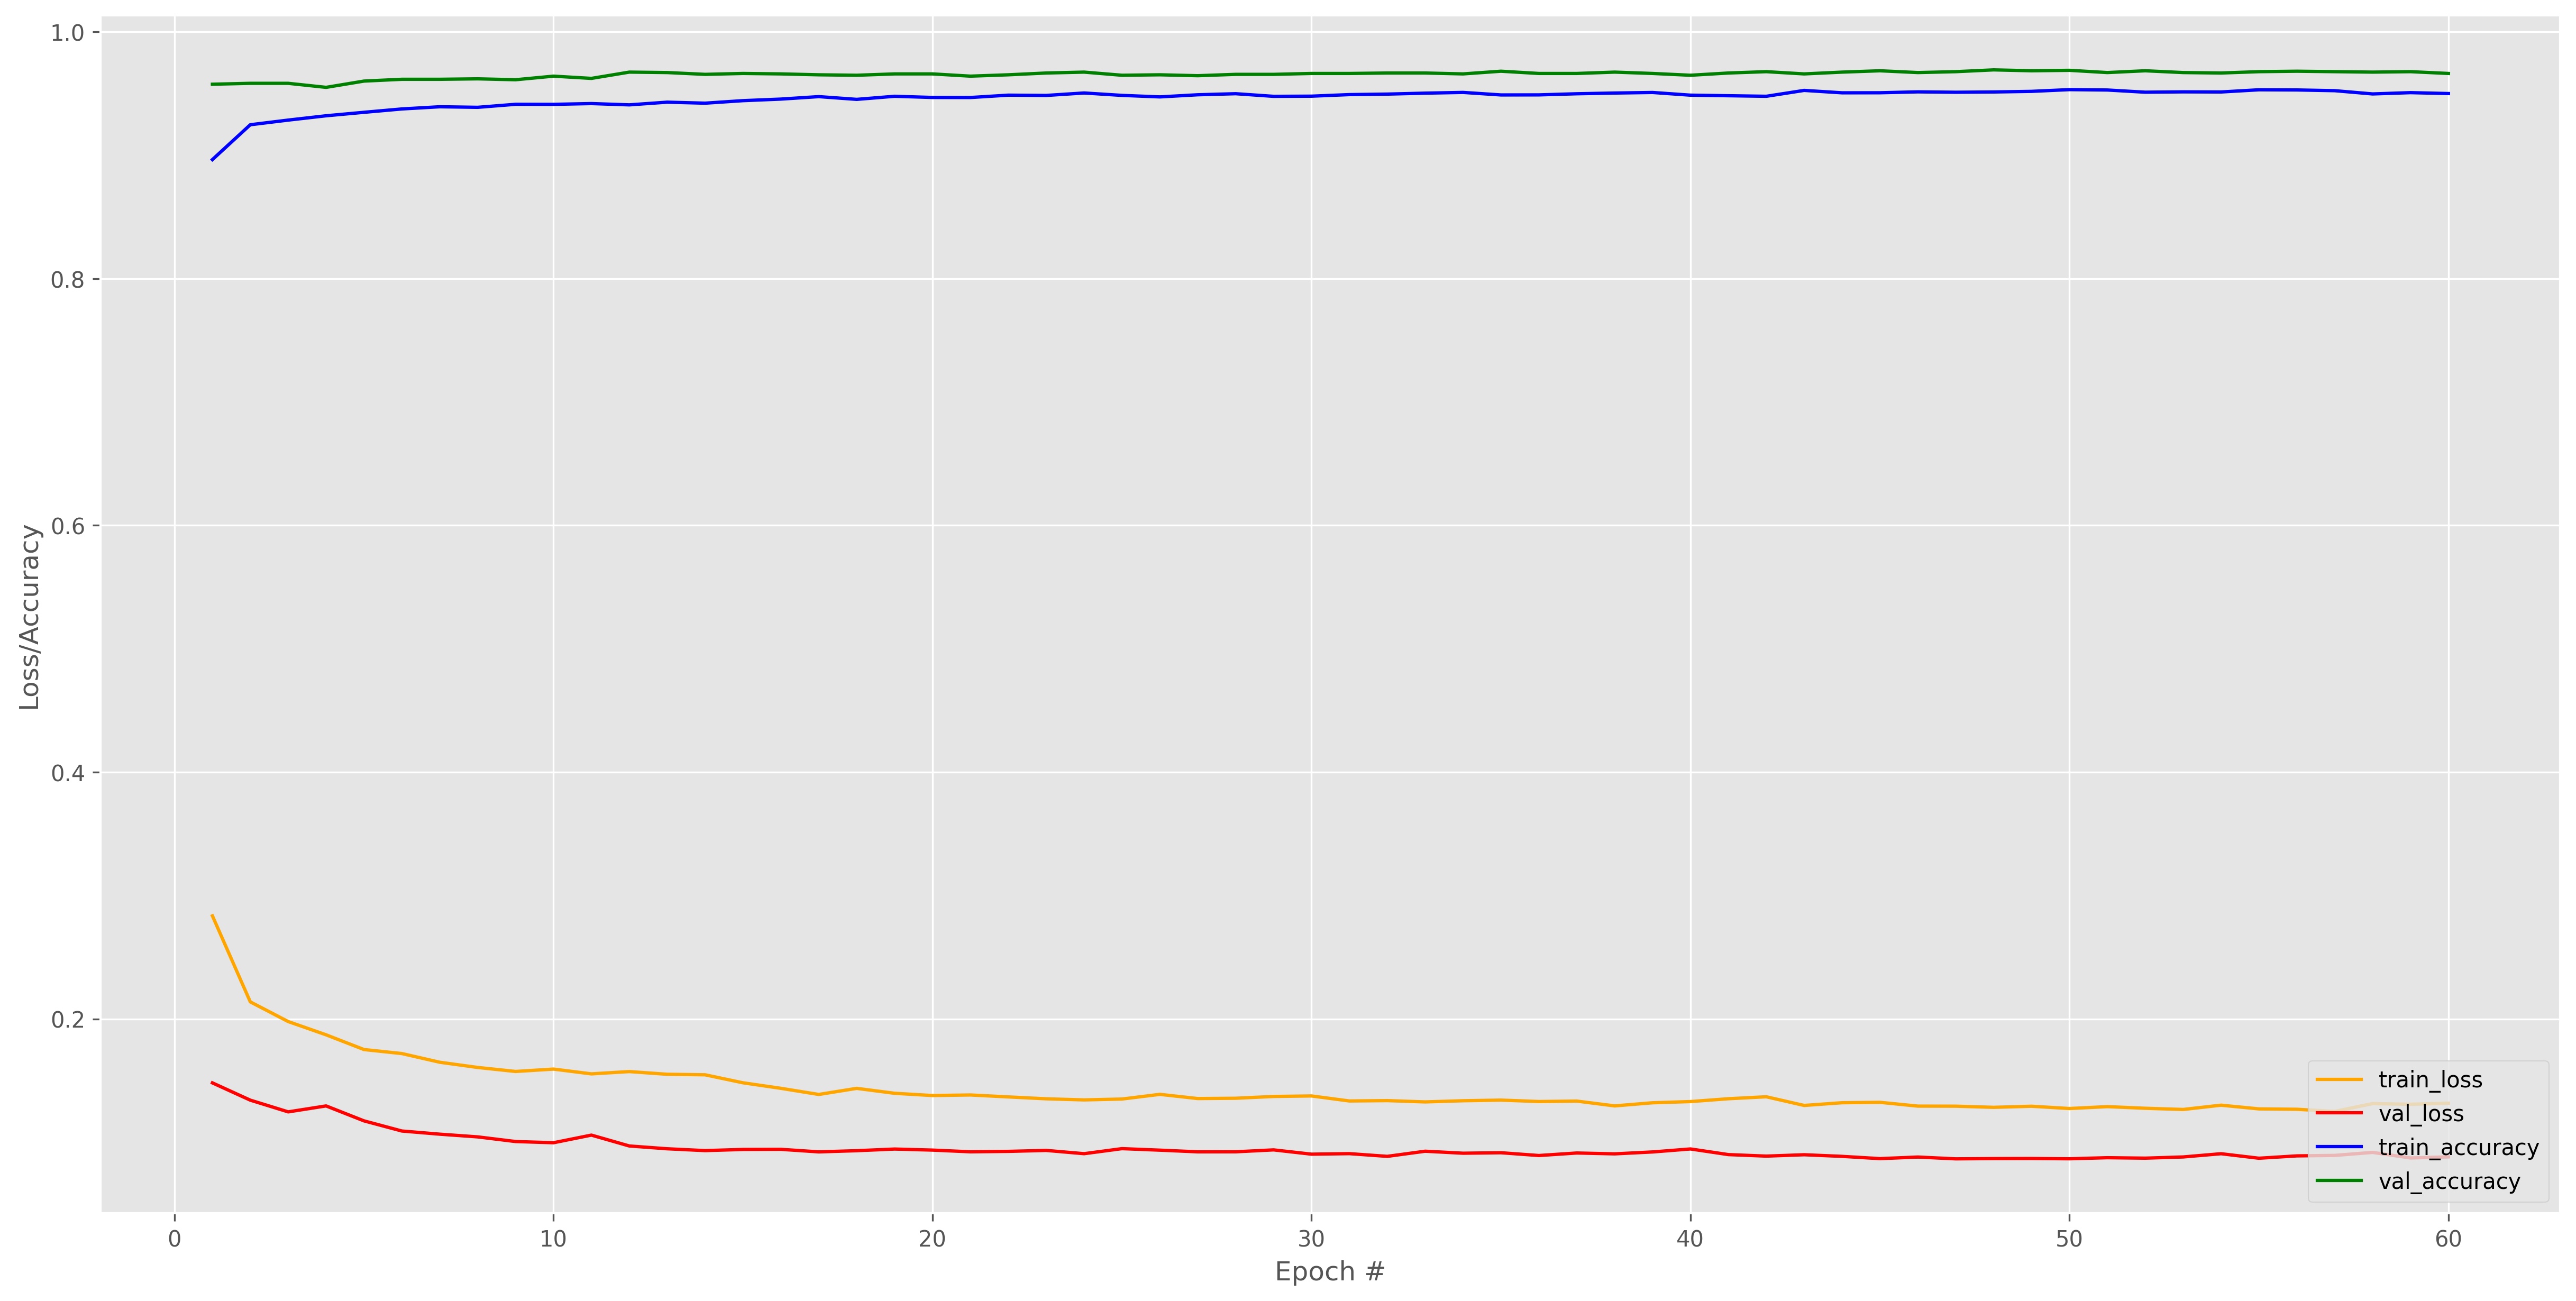

In [210]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("SqueezeNet_custom_plot.png")

In [211]:
#%% compile and train the InceptionResnetV2 model

adam = Adam(lr=0.0001)  
inceptionresnet_custom_model.compile(optimizer=adam,
                                     loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + inceptionresnet_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + inceptionresnet_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = inceptionresnet_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

Epoch 1/60
1377/1377 [==============================] - 157s 103ms/step - loss: 0.3985 - accuracy: 0.8173 - val_loss: 0.1293 - val_accuracy: 0.9549
Epoch 2/60
1377/1377 [==============================] - 136s 99ms/step - loss: 0.2141 - accuracy: 0.9203 - val_loss: 0.1051 - val_accuracy: 0.9611
Epoch 3/60
1377/1377 [==============================] - 137s 99ms/step - loss: 0.1888 - accuracy: 0.9281 - val_loss: 0.0990 - val_accuracy: 0.9637
Epoch 4/60
1377/1377 [==============================] - 137s 99ms/step - loss: 0.1718 - accuracy: 0.9357 - val_loss: 0.1006 - val_accuracy: 0.9655
Epoch 5/60
1377/1377 [==============================] - 137s 99ms/step - loss: 0.1577 - accuracy: 0.9420 - val_loss: 0.0932 - val_accuracy: 0.9698
Epoch 6/60
1377/1377 [==============================] - 136s 99ms/step - loss: 0.1481 - accuracy: 0.9471 - val_loss: 0.0967 - val_accuracy: 0.9727
Epoch 7/60
1377/1377 [==============================] - 136s 99ms/step - loss: 0.1613 - accuracy: 0.9390 - val_loss: 

1377/1377 [==============================] - 137s 99ms/step - loss: 0.0852 - accuracy: 0.9667 - val_loss: 0.0980 - val_accuracy: 0.9735
Epoch 55/60
1377/1377 [==============================] - 137s 99ms/step - loss: 0.0794 - accuracy: 0.9717 - val_loss: 0.0995 - val_accuracy: 0.9731
Epoch 56/60
1377/1377 [==============================] - 137s 99ms/step - loss: 0.0847 - accuracy: 0.9694 - val_loss: 0.0988 - val_accuracy: 0.9735
Epoch 57/60
1377/1377 [==============================] - 136s 99ms/step - loss: 0.0804 - accuracy: 0.9712 - val_loss: 0.0982 - val_accuracy: 0.9702
Epoch 58/60
1377/1377 [==============================] - 137s 99ms/step - loss: 0.0823 - accuracy: 0.9689 - val_loss: 0.0966 - val_accuracy: 0.9706
Epoch 59/60
1377/1377 [==============================] - 136s 99ms/step - loss: 0.0873 - accuracy: 0.9681 - val_loss: 0.1051 - val_accuracy: 0.9691
Epoch 60/60
1377/1377 [==============================] - 137s 99ms/step - loss: 0.0813 - accuracy: 0.9721 - val_loss: 0.1051

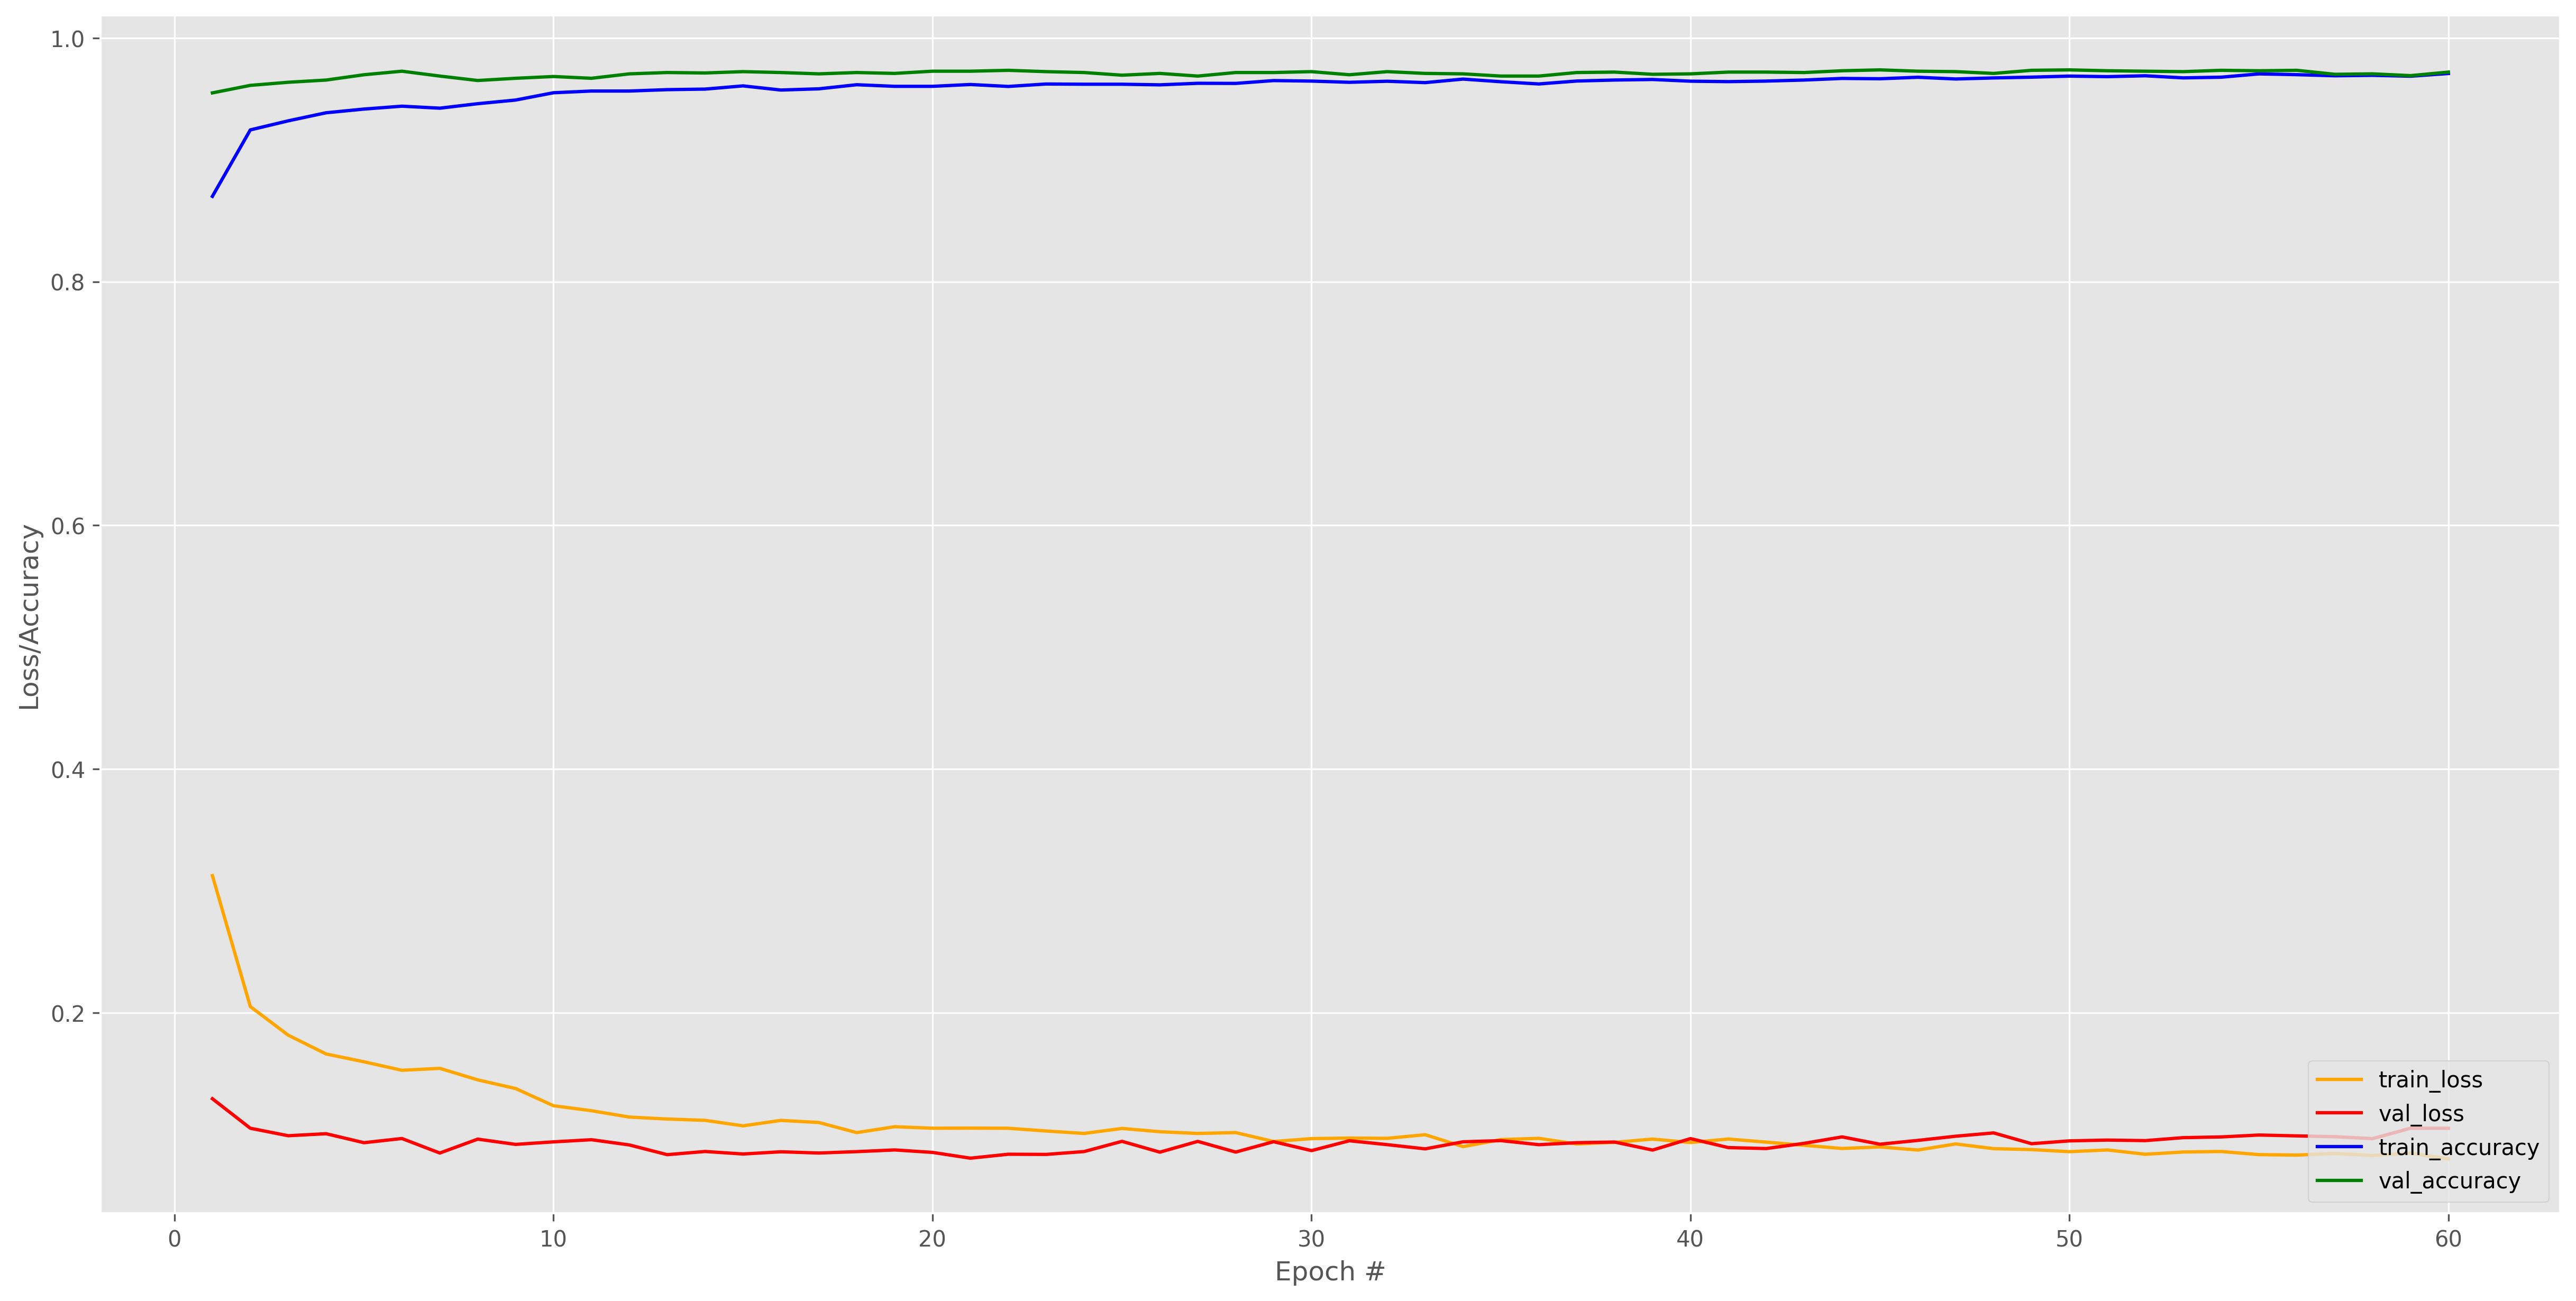

In [212]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("InceptionResnet_custom_plot.png")

In [213]:
#Evaluate the model by loading the best weights
custom_model.load_weights('weights/custom_cnn.h5')

#evaluate accuracy
custom_y_pred = custom_model.predict(validation_generator,
                                               nb_validation_samples/batch_size, workers=1)
accuracy = accuracy_score(Y_test,custom_y_pred.argmax(axis=-1))
print('The accuracy of the Custom model is: ', accuracy)

#evaluate mean squared error
custom_mse = mean_squared_error(Y_test,custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Custom model is: ', custom_mse)

#evaluate mean squared log error
custom_msle = mean_squared_log_error(Y_test,custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Custom model is: ', custom_msle)

The accuracy of the Custom model is:  0.9633526850507983
The Mean Squared Error of the Custom model is:  0.03664731494920174
The Mean Squared Log Error of the Custom model is:  0.01760731291935353


                   precision    recall  f1-score   support

class 0(abnormal)     0.9761    0.9499    0.9629      1378
  class 1(normal)     0.9512    0.9768    0.9638      1378

         accuracy                         0.9634      2756
        macro avg     0.9637    0.9634    0.9633      2756
     weighted avg     0.9637    0.9634    0.9633      2756

Confusion matrix, without normalization
[[1309   69]
 [  32 1346]]


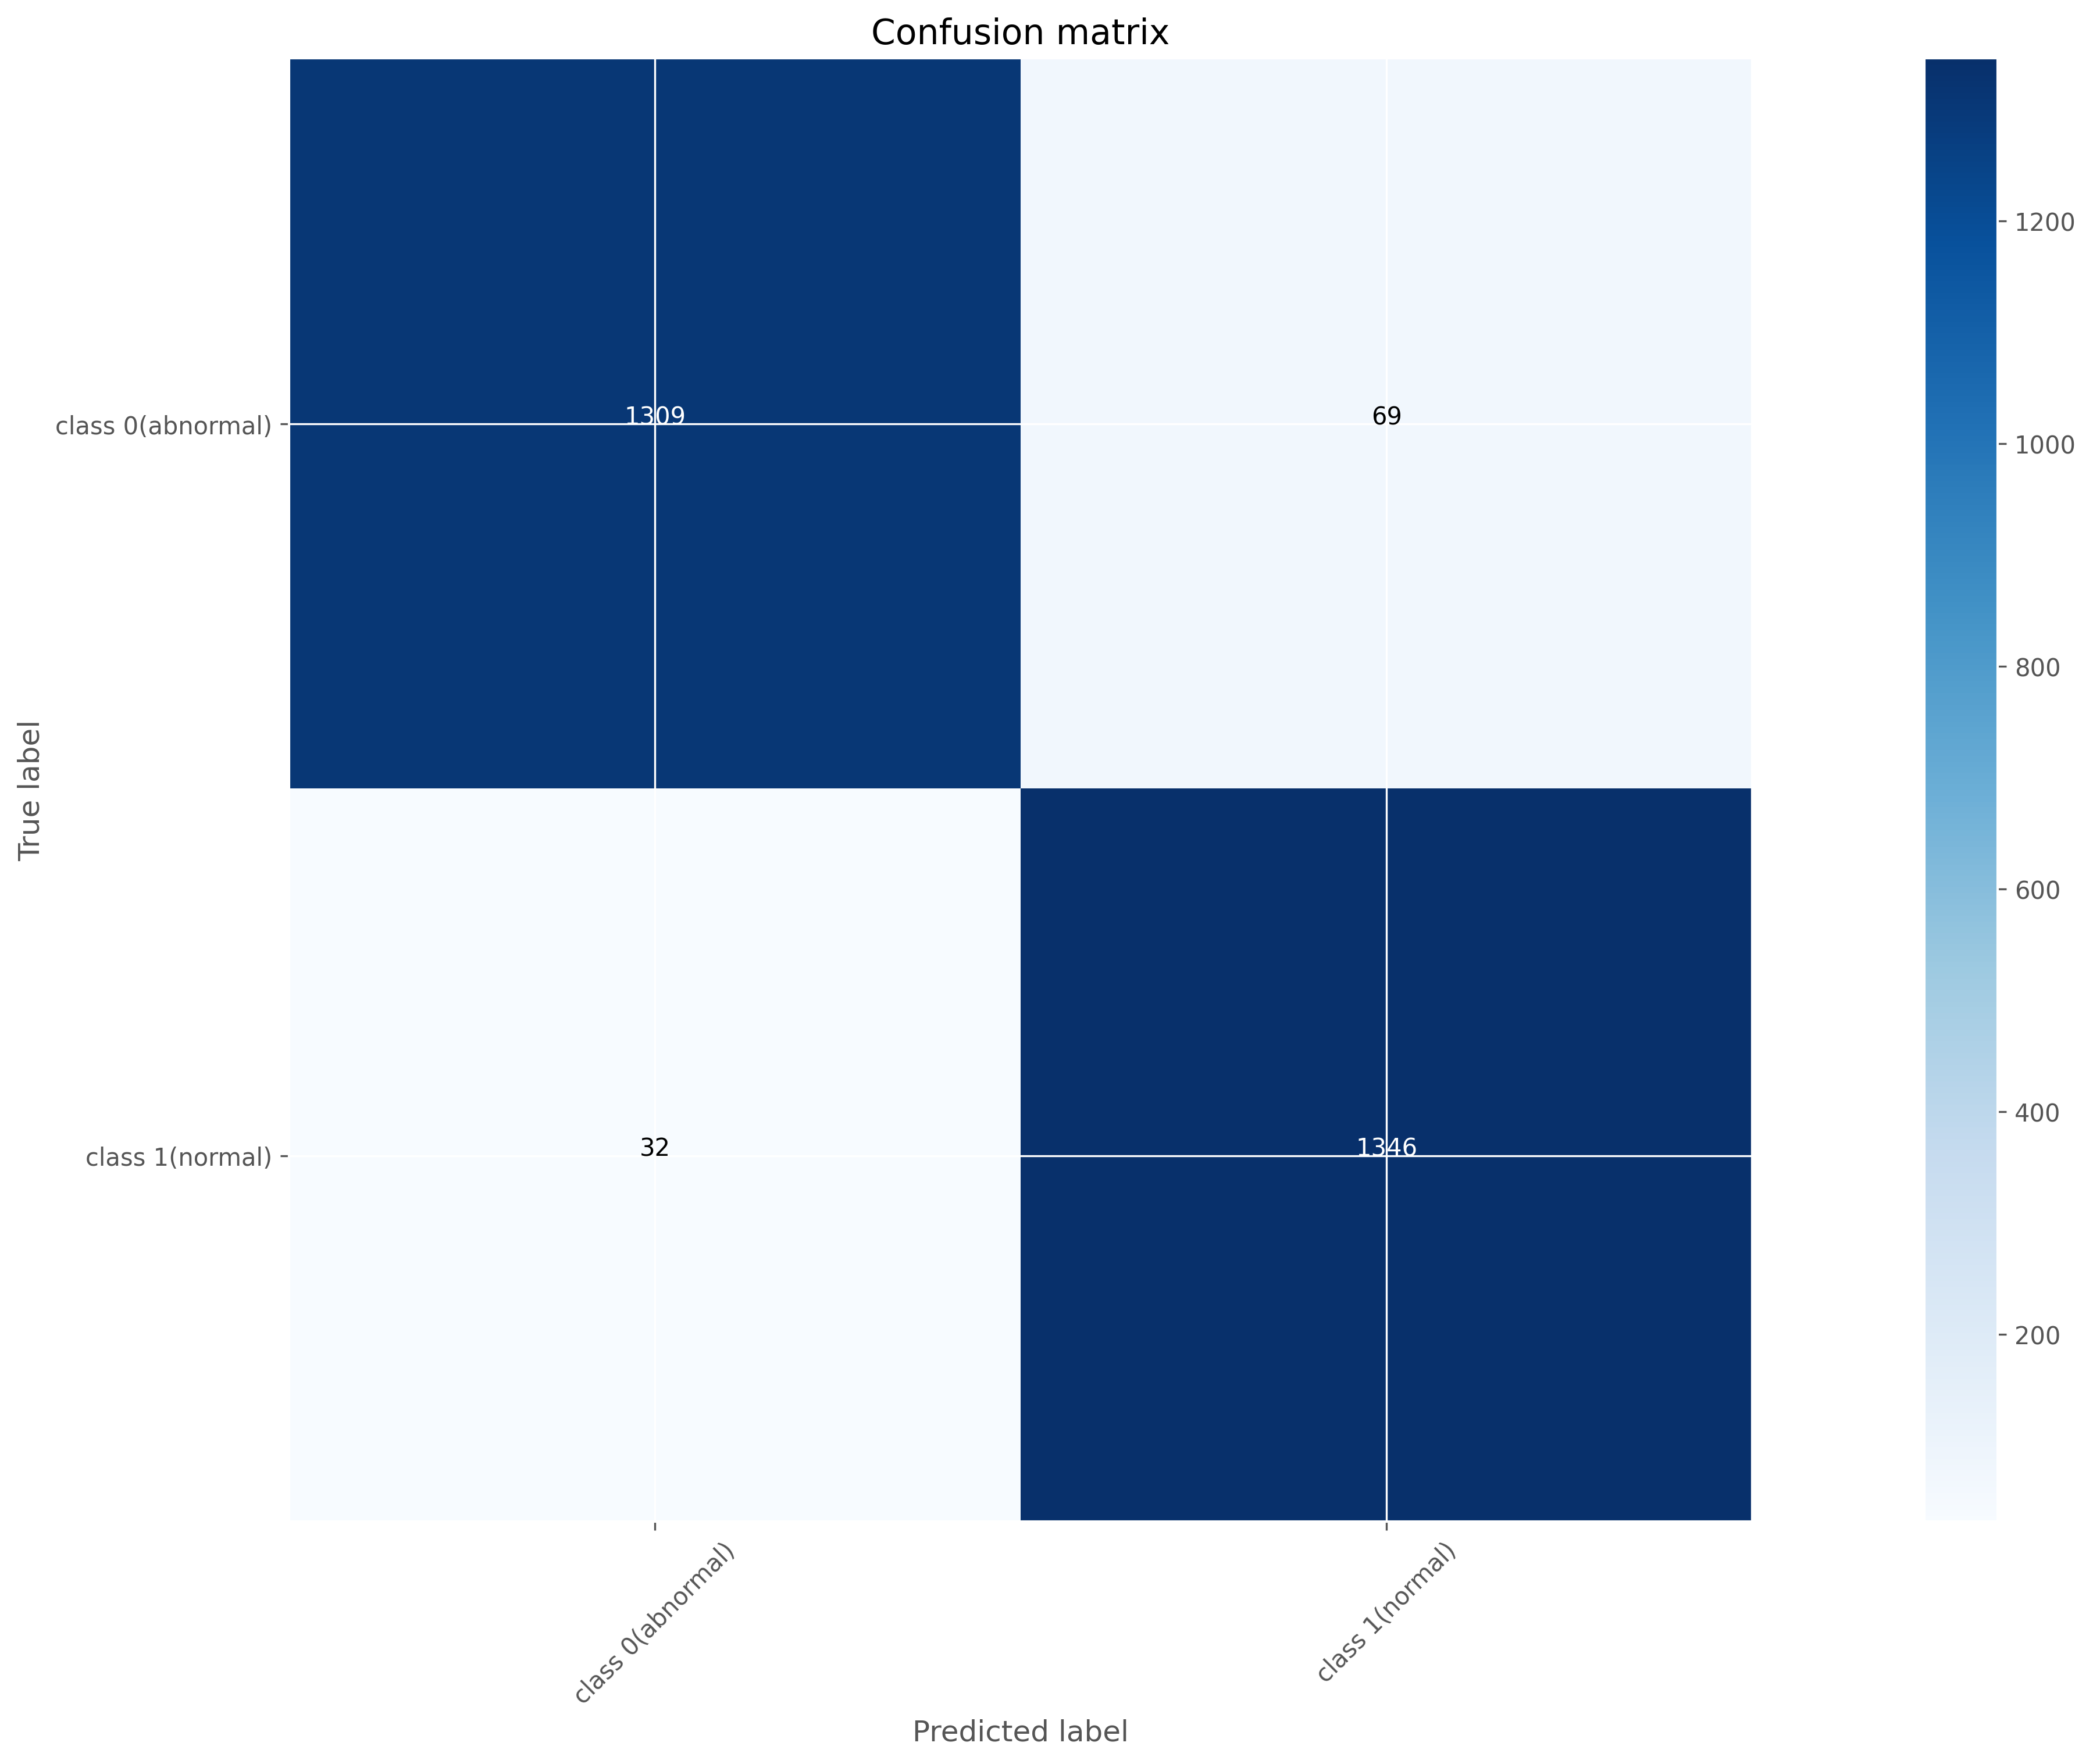

In [214]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


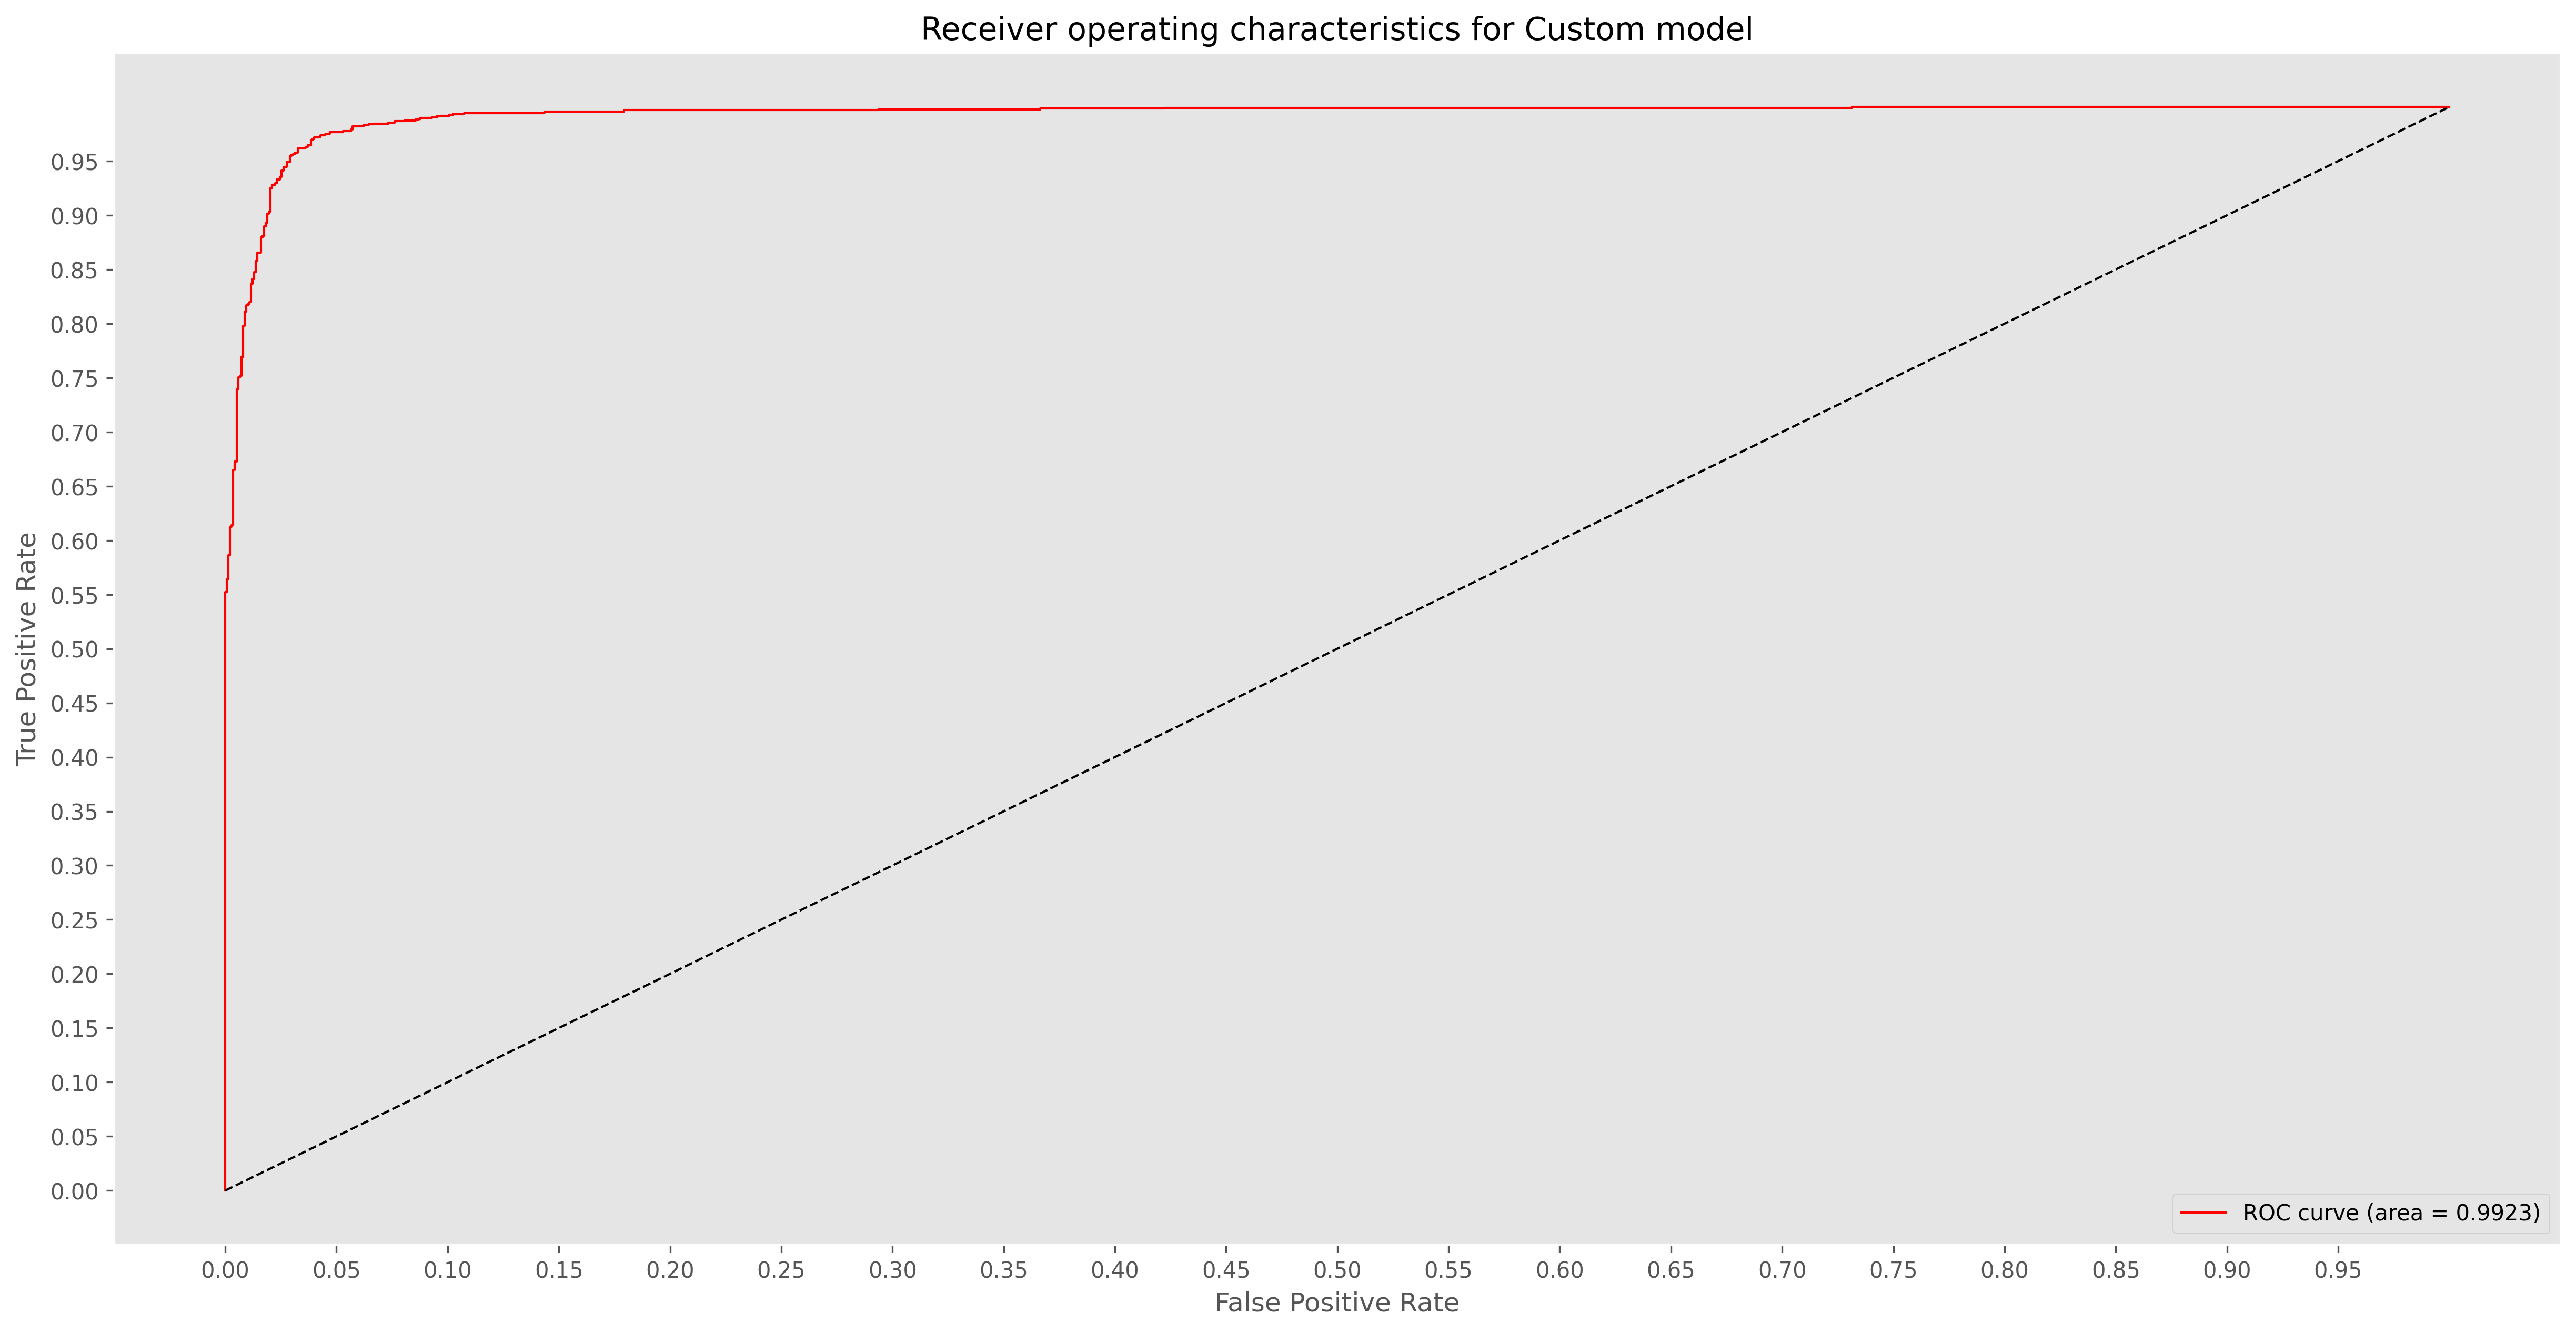

In [215]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for Custom model')
plt.legend(loc="lower right")
plt.show()

In [216]:
#Evaluate the model by loading the best weights 
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')

#evaluate accuracy
vgg19_custom_y_pred = vgg19_custom_model.predict(validation_generator,
                                                           nb_validation_samples/batch_size, workers=1)
vgg19_accuracy = accuracy_score(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The accuracy of the VGG19 Custom model is: ', vgg19_accuracy)

#evaluate mean squared error
vgg19_custom_mse = mean_squared_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the VGG19 Custom model is: ', vgg19_custom_mse)

#evaluate mean squared log error
vgg19_custom_msle = mean_squared_log_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the VGG19 Custom model is: ', vgg19_custom_msle)

The accuracy of the VGG19 Custom model is:  0.9727866473149492
The Mean Squared Error of the VGG19 Custom model is:  0.027213352685050797
The Mean Squared Log Error of the VGG19 Custom model is:  0.013074737316351634


                   precision    recall  f1-score   support

class 0(abnormal)     0.9773    0.9681    0.9727      1378
  class 1(normal)     0.9684    0.9775    0.9729      1378

         accuracy                         0.9728      2756
        macro avg     0.9728    0.9728    0.9728      2756
     weighted avg     0.9728    0.9728    0.9728      2756

Confusion matrix, without normalization
[[1334   44]
 [  31 1347]]


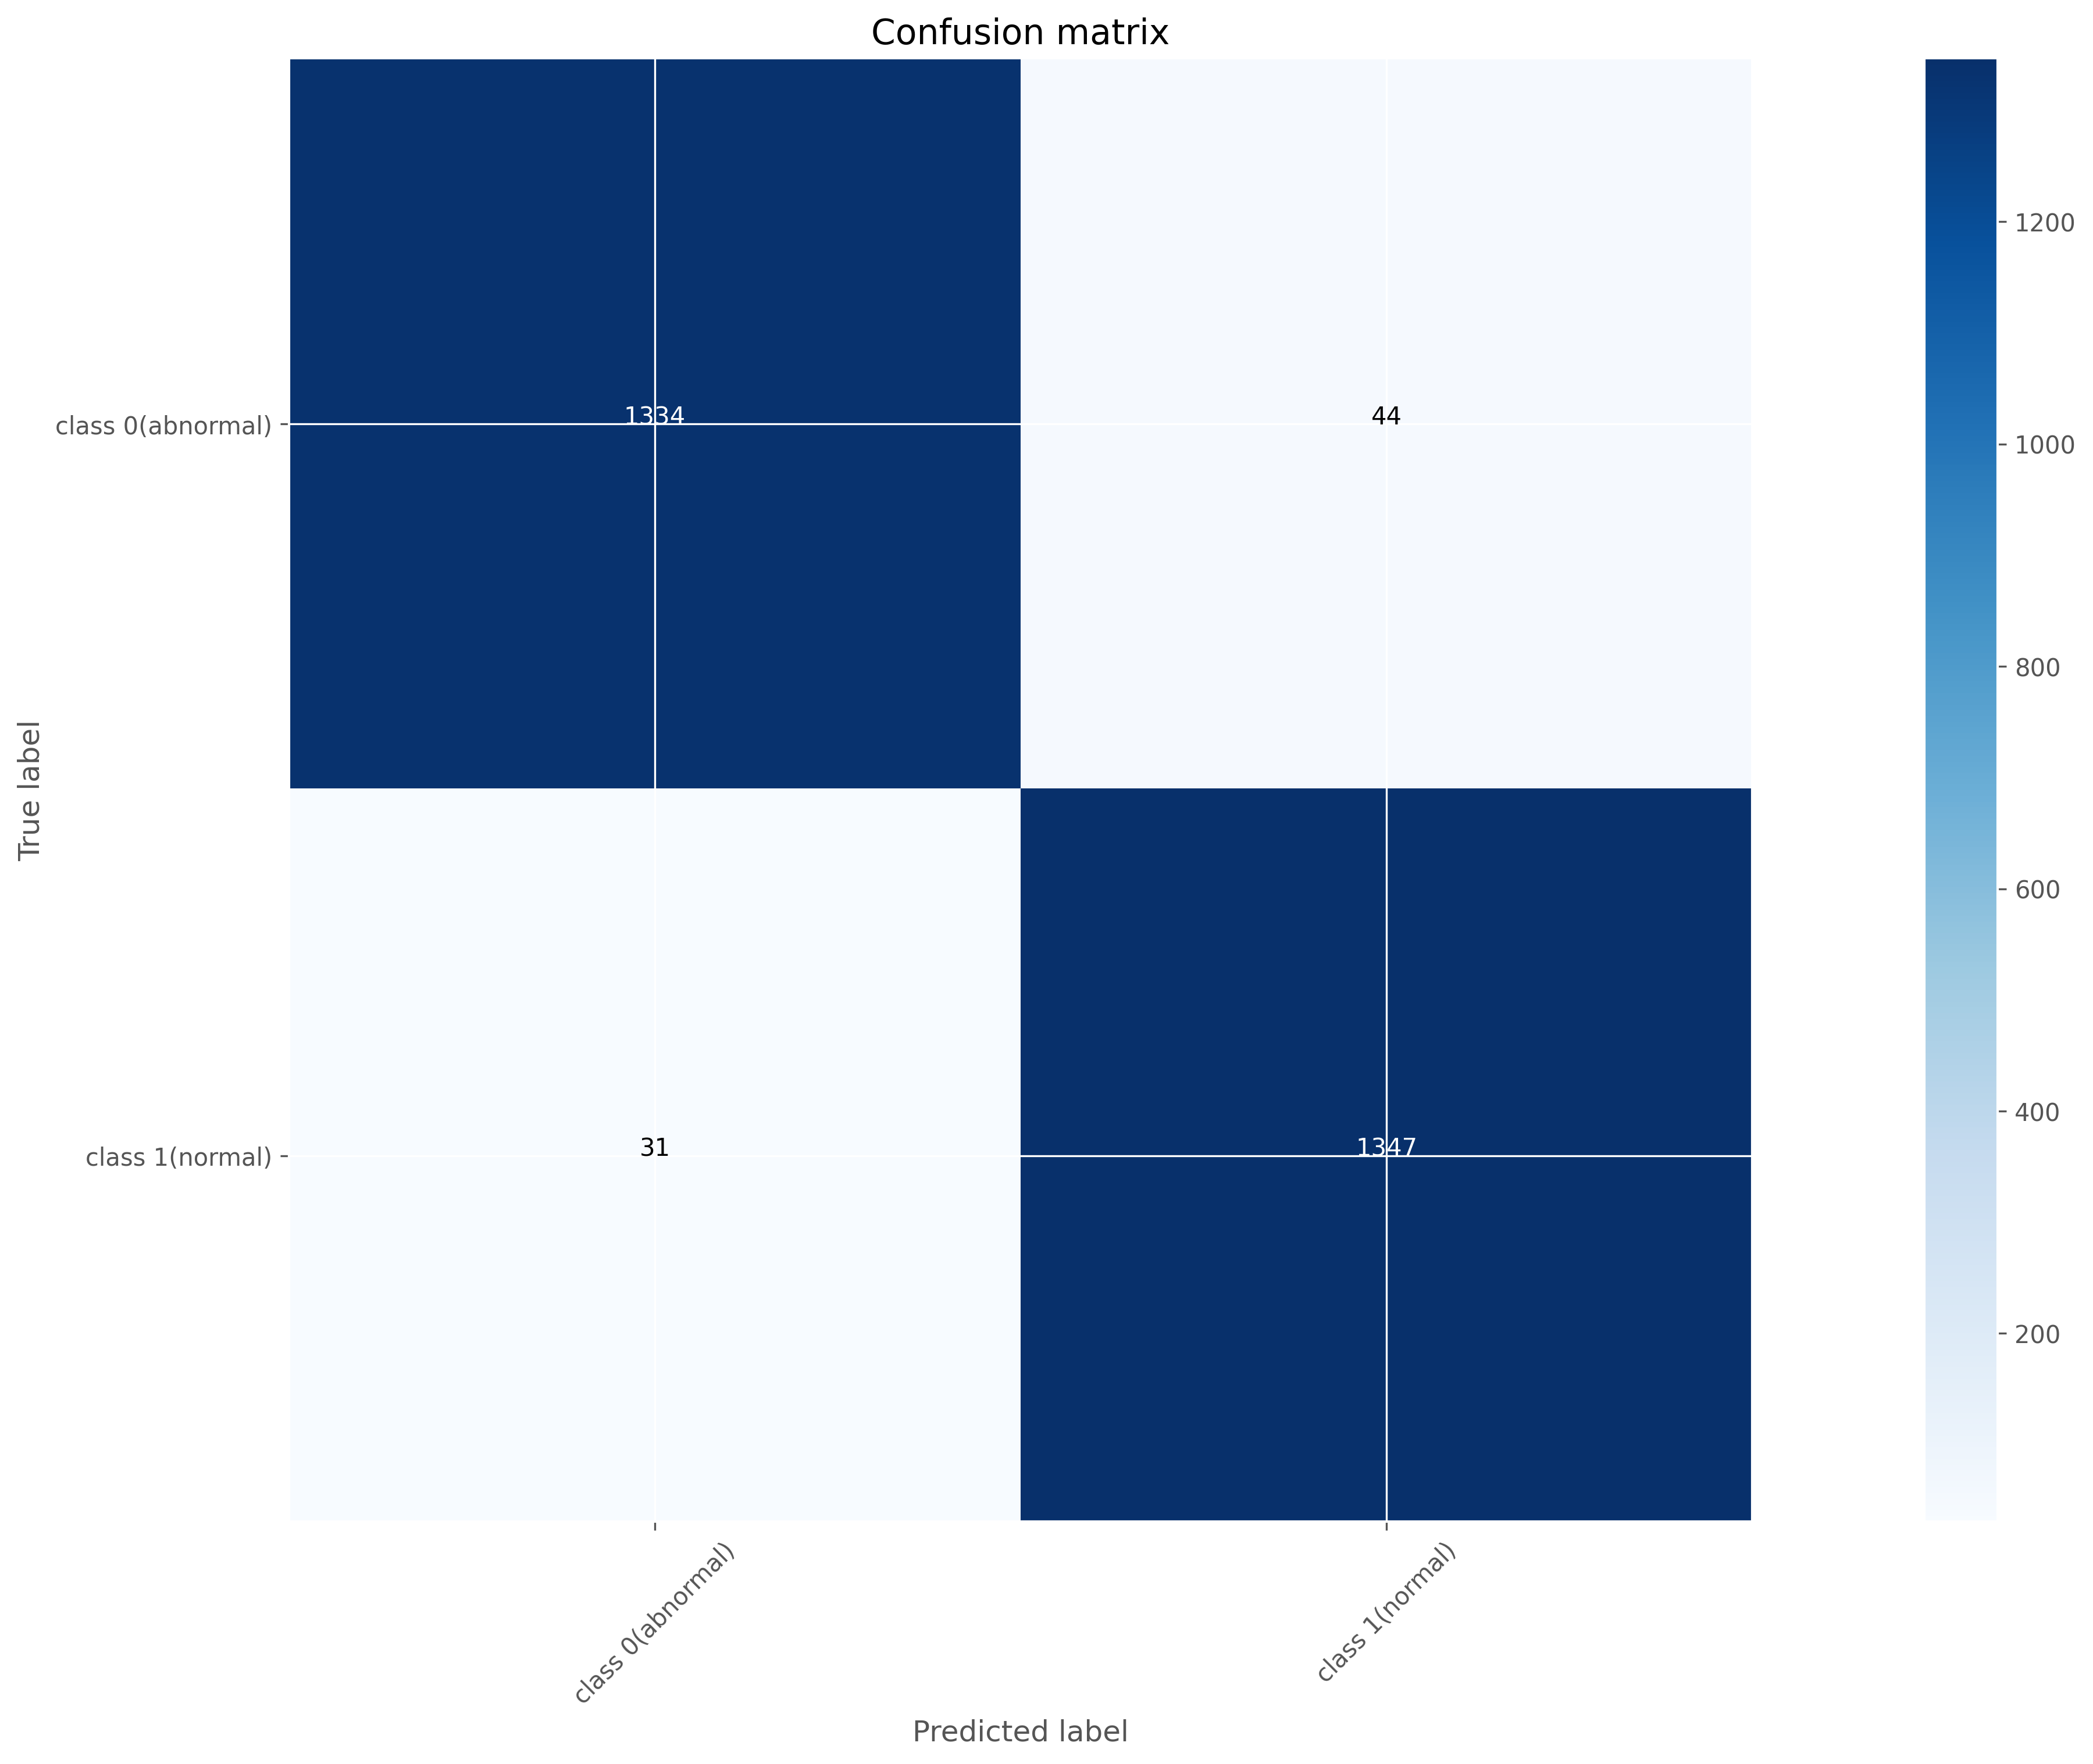

In [217]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,vgg19_custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


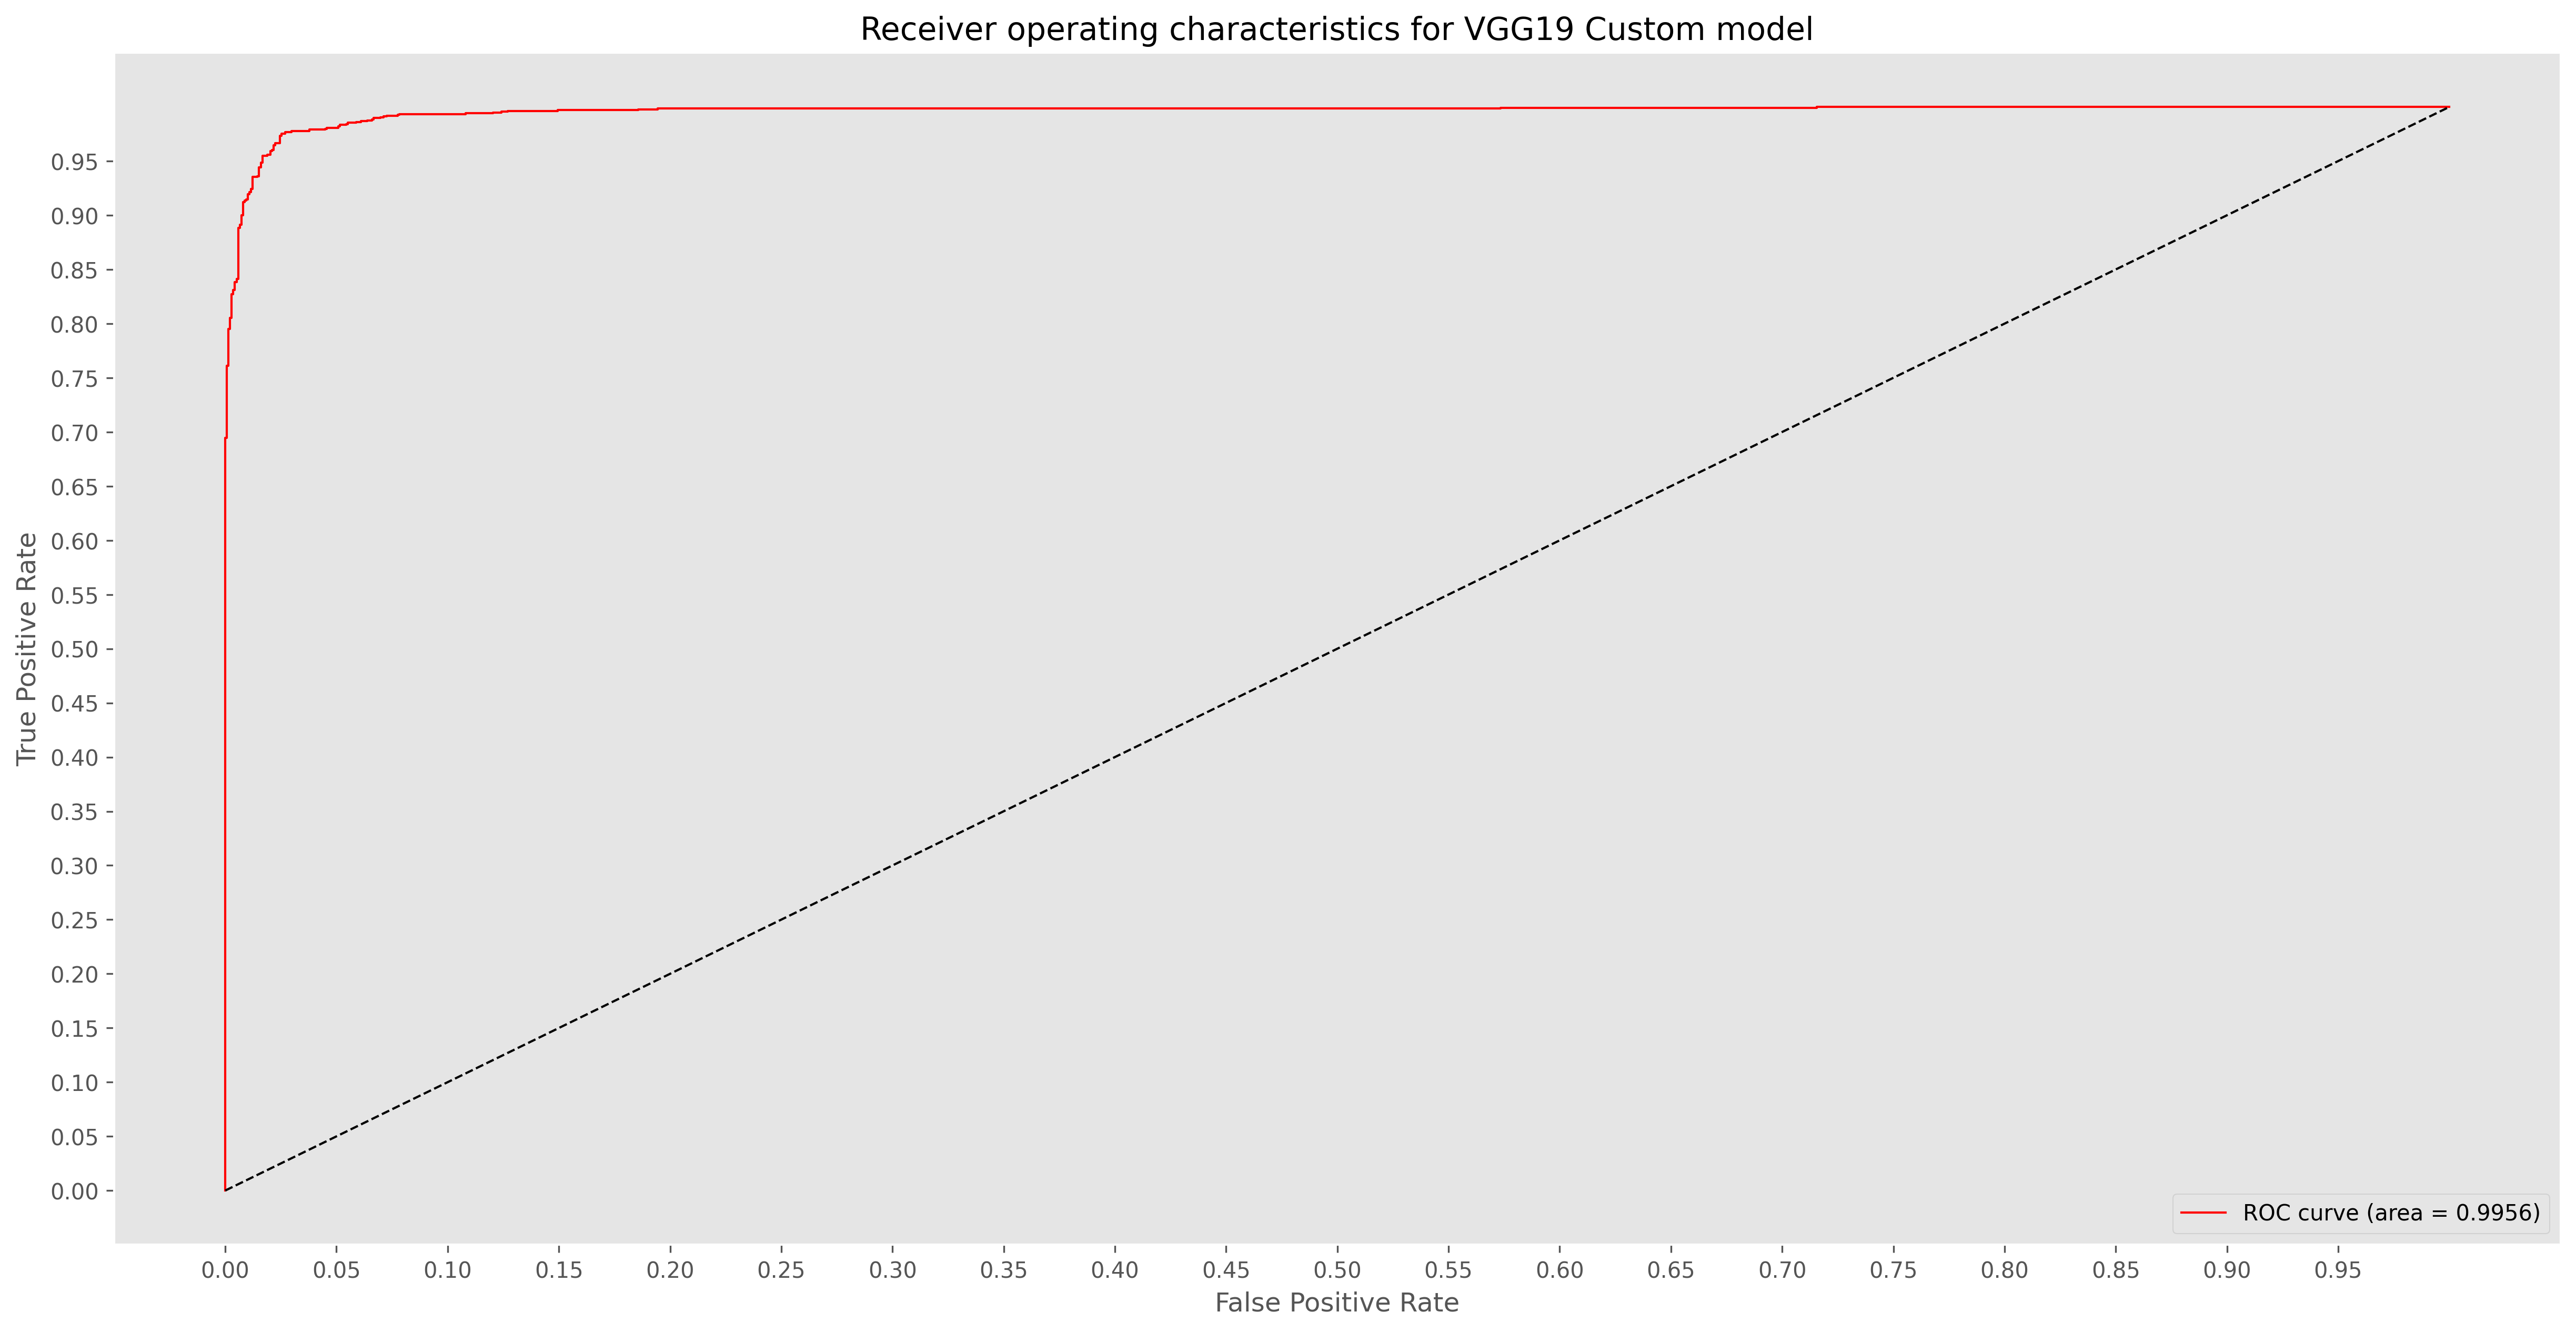

In [218]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, vgg19_custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for VGG19 Custom model')
plt.legend(loc="lower right")
plt.show()


In [219]:
#Evaluate the model by loading the best weights 
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')

#evaluate accuracy

squeeze_y_pred = squeeze_custom_model.predict(validation_generator,
                                                        nb_validation_samples/batch_size, workers=1)
squeeze_accuracy = accuracy_score(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The accuracy of the SqueezeNet Custom model is: ', squeeze_accuracy)

#evaluate mean squared error

squeeze_custom_mse = mean_squared_error(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the SqueezeNet Custom model is: ', squeeze_custom_mse)

#evaluate mean squared log error

squeeze_custom_msle = mean_squared_log_error(Y_test,squeeze_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the SqueezeNet Custom model is: ', squeeze_custom_msle)

The accuracy of the SqueezeNet Custom model is:  0.9691582002902758
The Mean Squared Error of the SqueezeNet Custom model is:  0.030841799709724237
The Mean Squared Log Error of the SqueezeNet Custom model is:  0.014818035625198518


                   precision    recall  f1-score   support

class 0(abnormal)     0.9743    0.9637    0.9690      1378
  class 1(normal)     0.9641    0.9746    0.9693      1378

         accuracy                         0.9692      2756
        macro avg     0.9692    0.9692    0.9692      2756
     weighted avg     0.9692    0.9692    0.9692      2756

Confusion matrix, without normalization
[[1328   50]
 [  35 1343]]


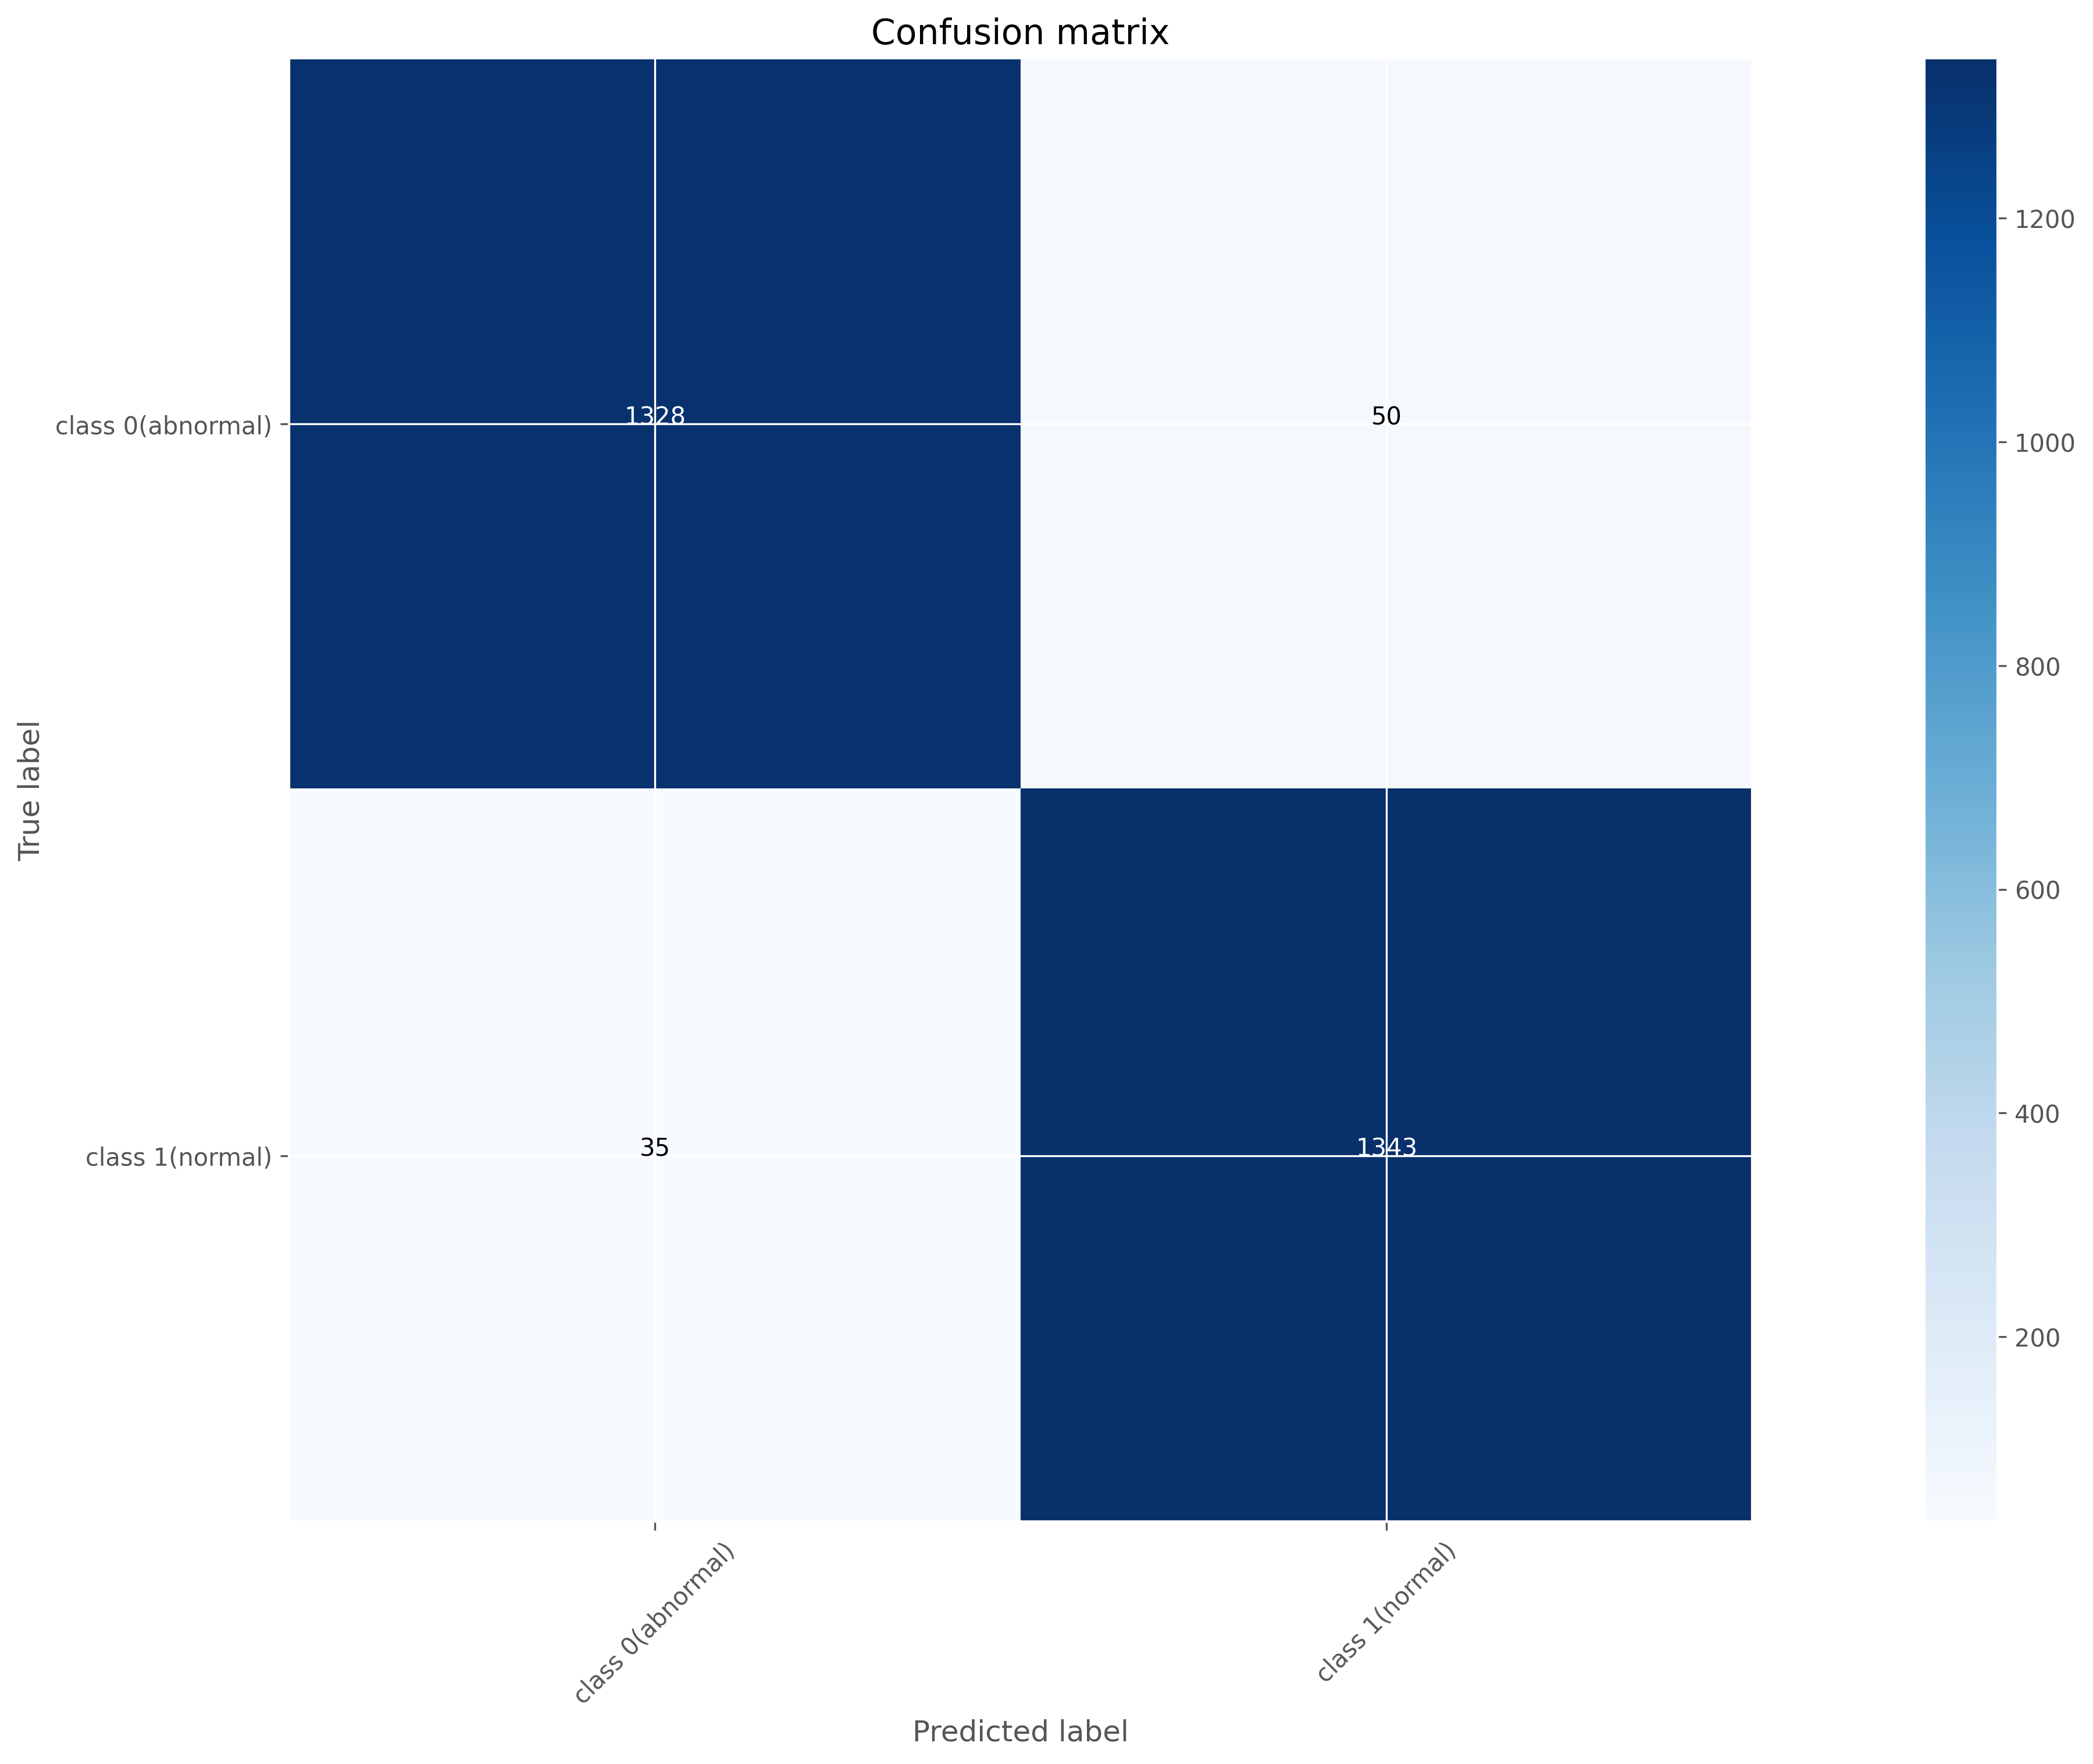

In [220]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,squeeze_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,squeeze_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


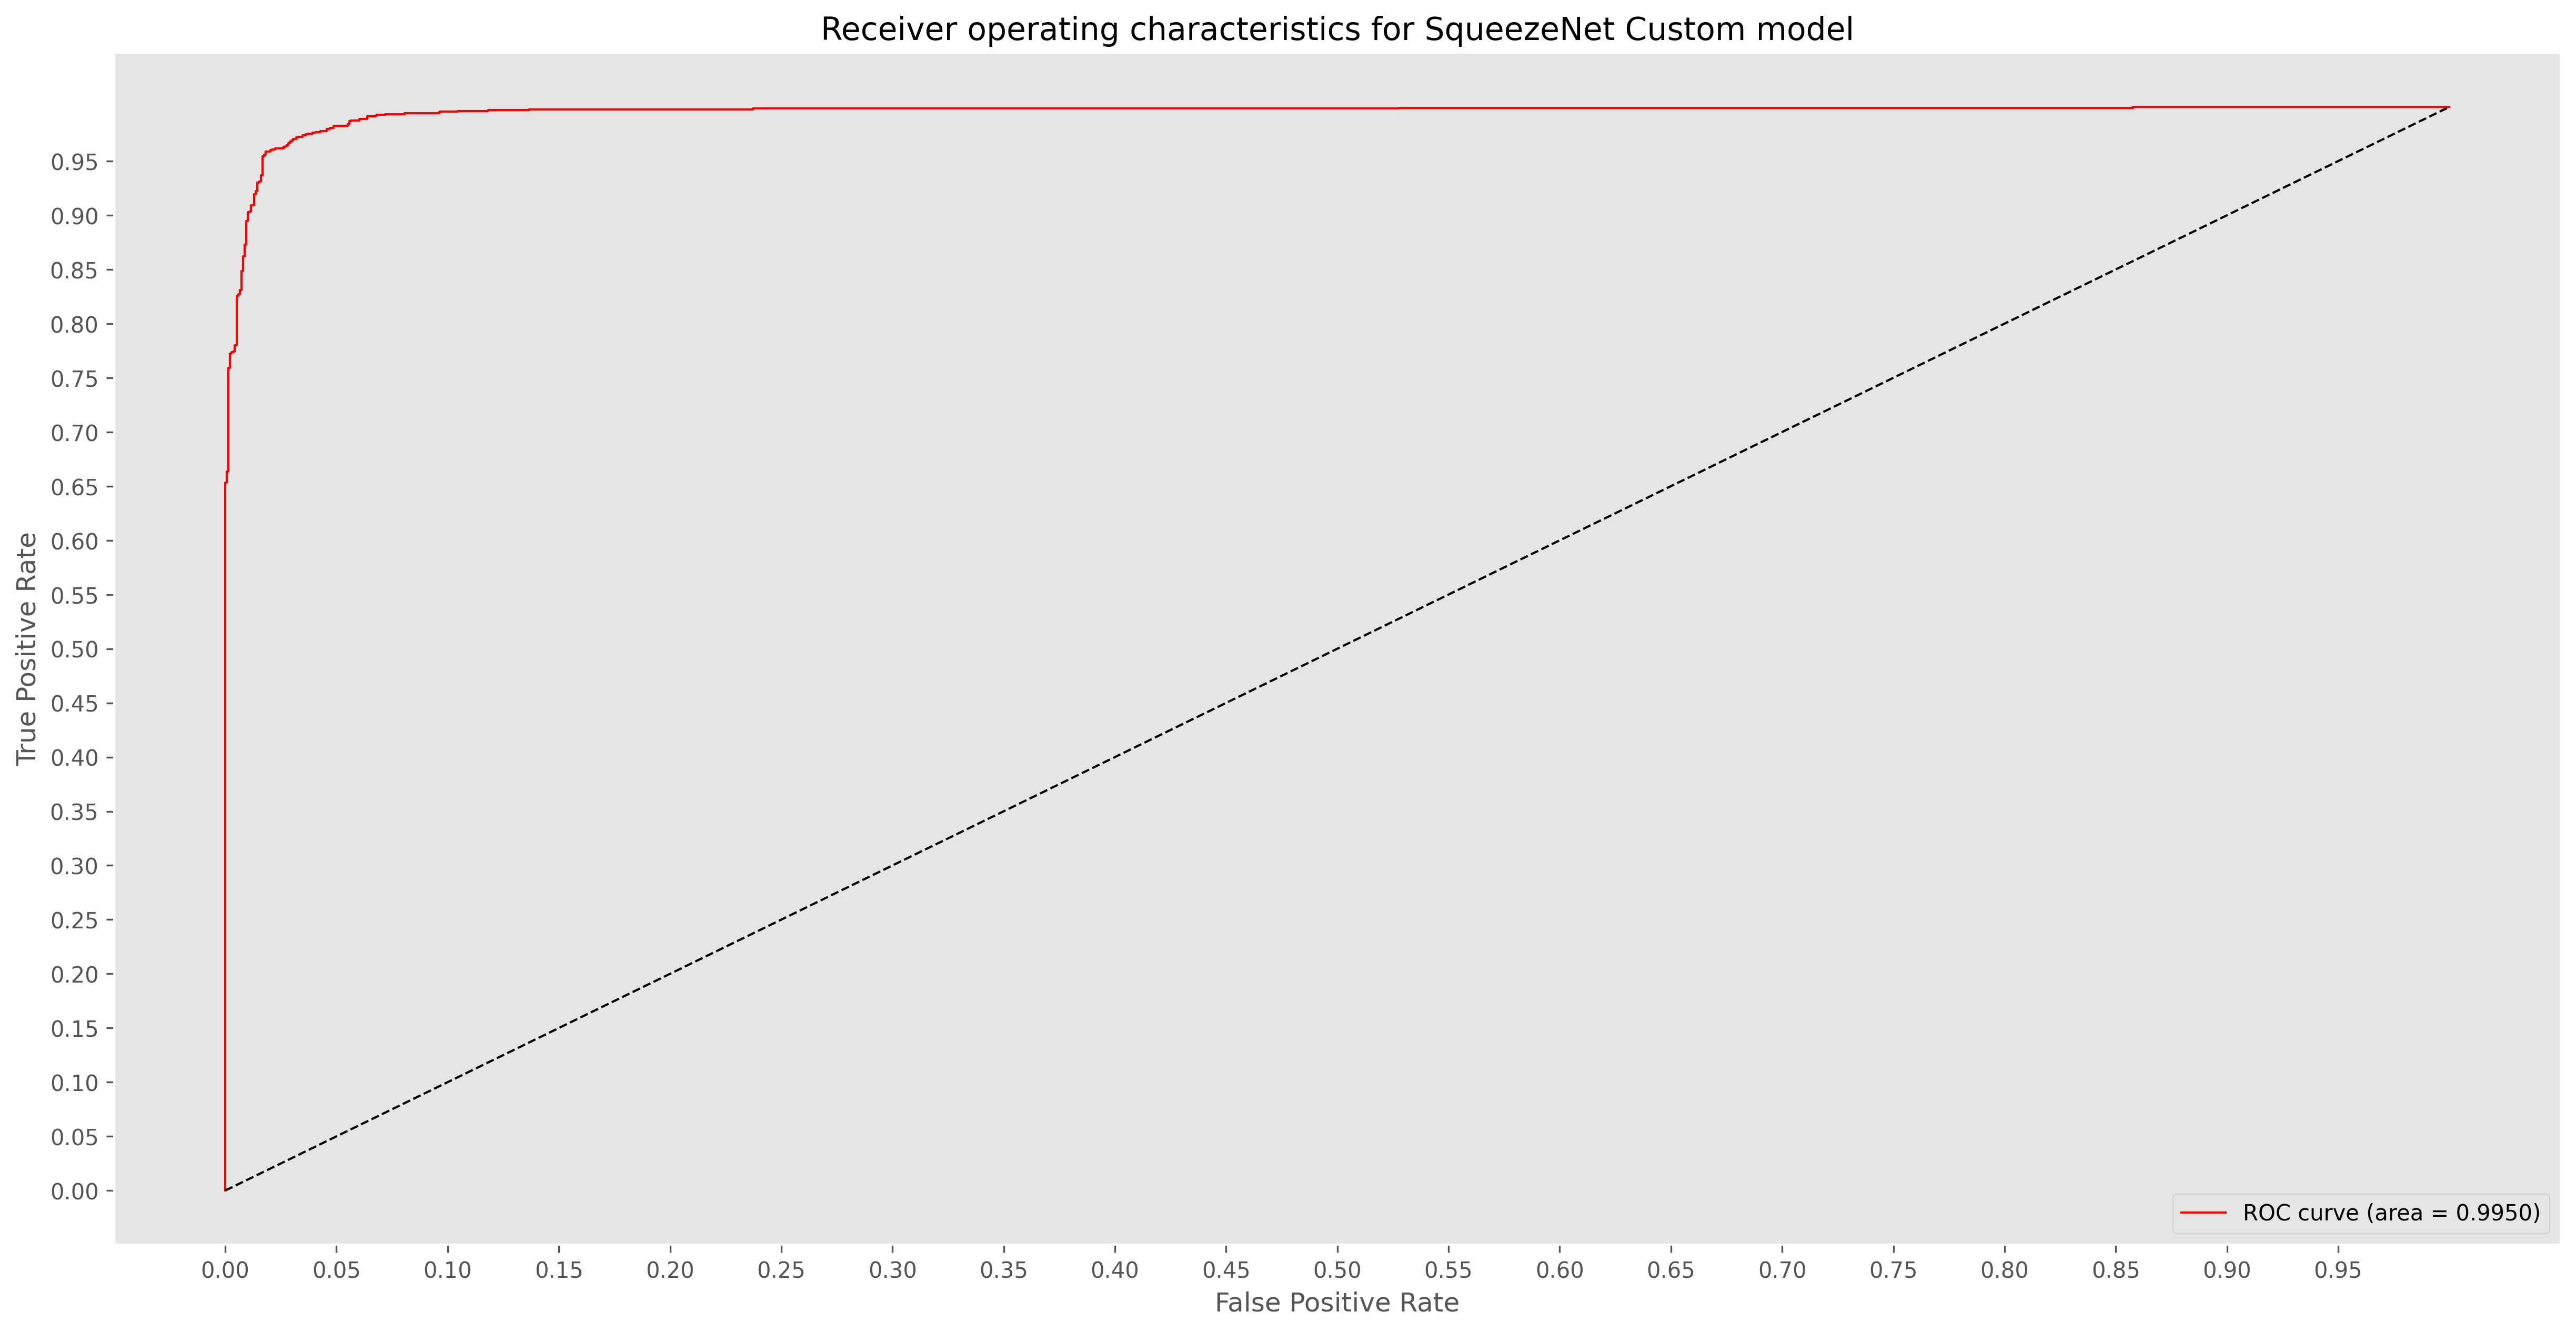

In [221]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, squeeze_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for SqueezeNet Custom model')
plt.legend(loc="lower right")
plt.show()


In [222]:
#Evaluate the model by loading the best weights 
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

#evaluate accuracy
incepres_y_pred = inceptionresnet_custom_model.predict(validation_generator,
                                                                 nb_validation_samples/batch_size, workers=1)
incepres_accuracy = accuracy_score(Y_test,incepres_y_pred.argmax(axis=-1))
print('The accuracy of the InceptionResNetV2 Custom model is: ', incepres_accuracy)

#evaluate mean squared error
incepres_custom_mse = mean_squared_error(Y_test,incepres_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the InceptionResNetv2 Custom model is: ', incepres_custom_mse)

#evaluate mean squared log error
incepres_custom_msle = mean_squared_log_error(Y_test,incepres_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the InceptionResNetv2 Custom model is: ', incepres_custom_msle)

The accuracy of the InceptionResNetV2 Custom model is:  0.9738751814223512
The Mean Squared Error of the InceptionResNetv2 Custom model is:  0.026124818577648767
The Mean Squared Log Error of the InceptionResNetv2 Custom model is:  0.012551747823697569


                   precision    recall  f1-score   support

class 0(abnormal)     0.9844    0.9630    0.9736      1378
  class 1(normal)     0.9638    0.9848    0.9742      1378

         accuracy                         0.9739      2756
        macro avg     0.9741    0.9739    0.9739      2756
     weighted avg     0.9741    0.9739    0.9739      2756

Confusion matrix, without normalization
[[1327   51]
 [  21 1357]]


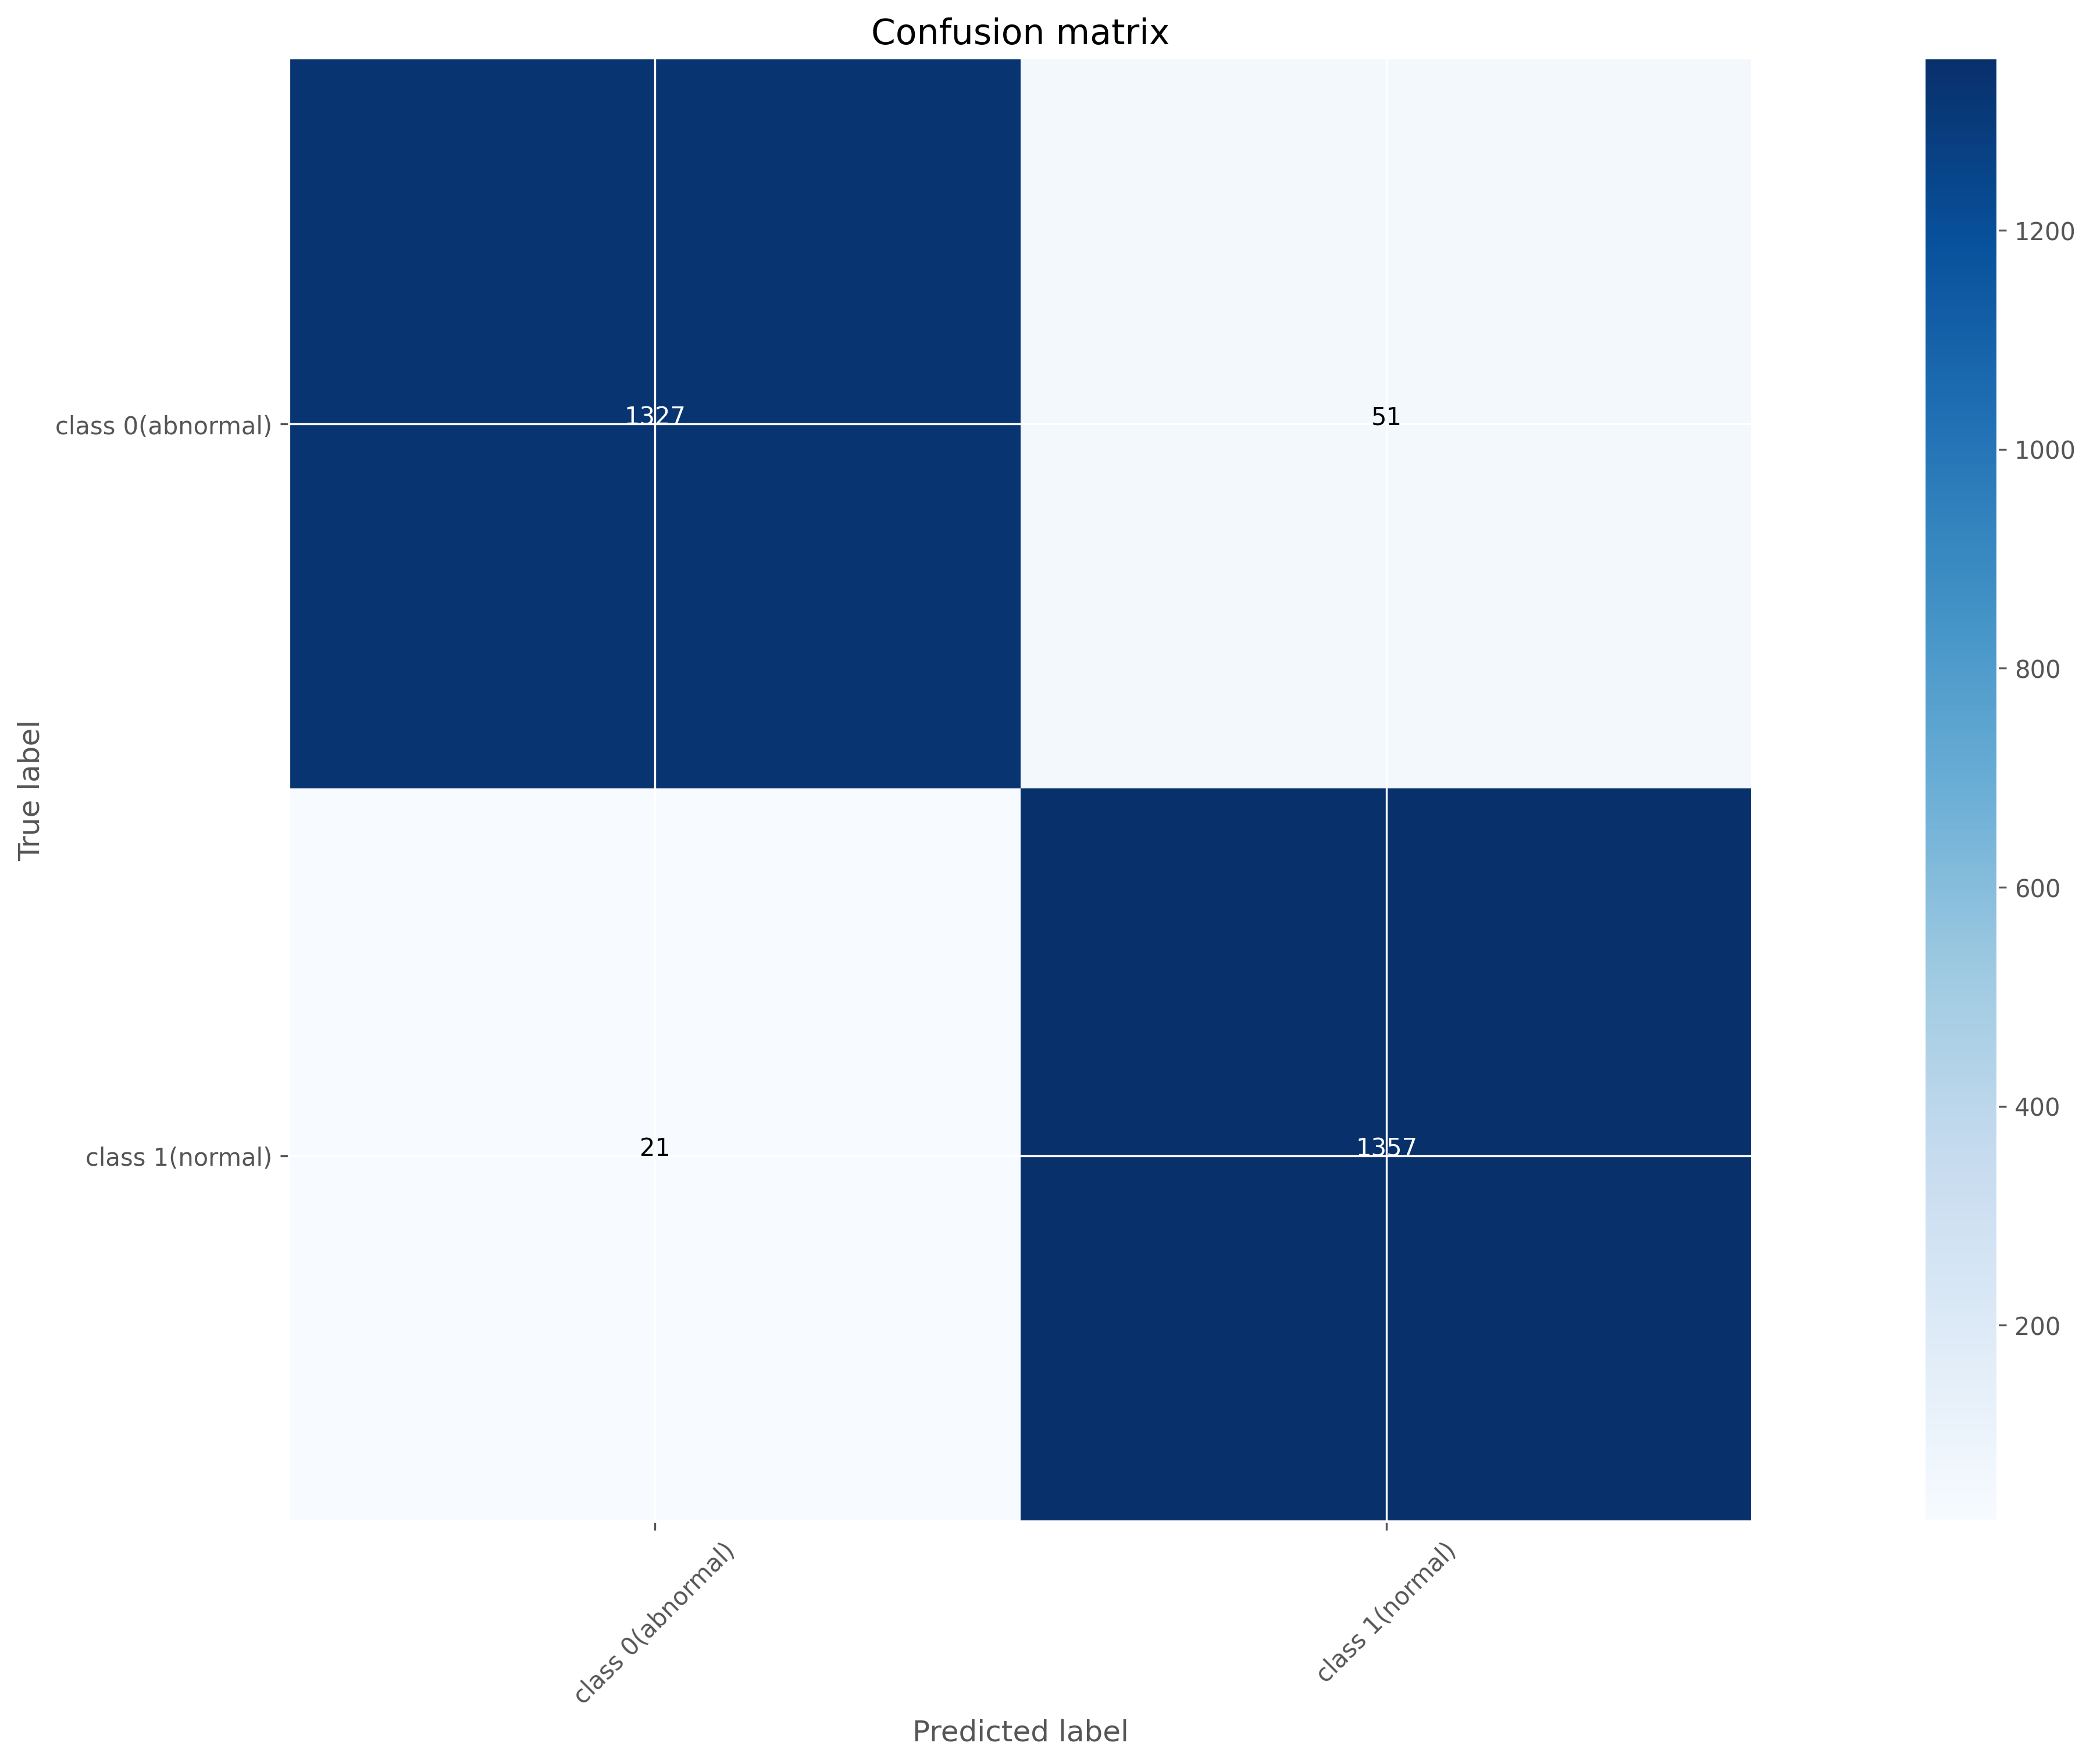

In [223]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,incepres_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,incepres_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


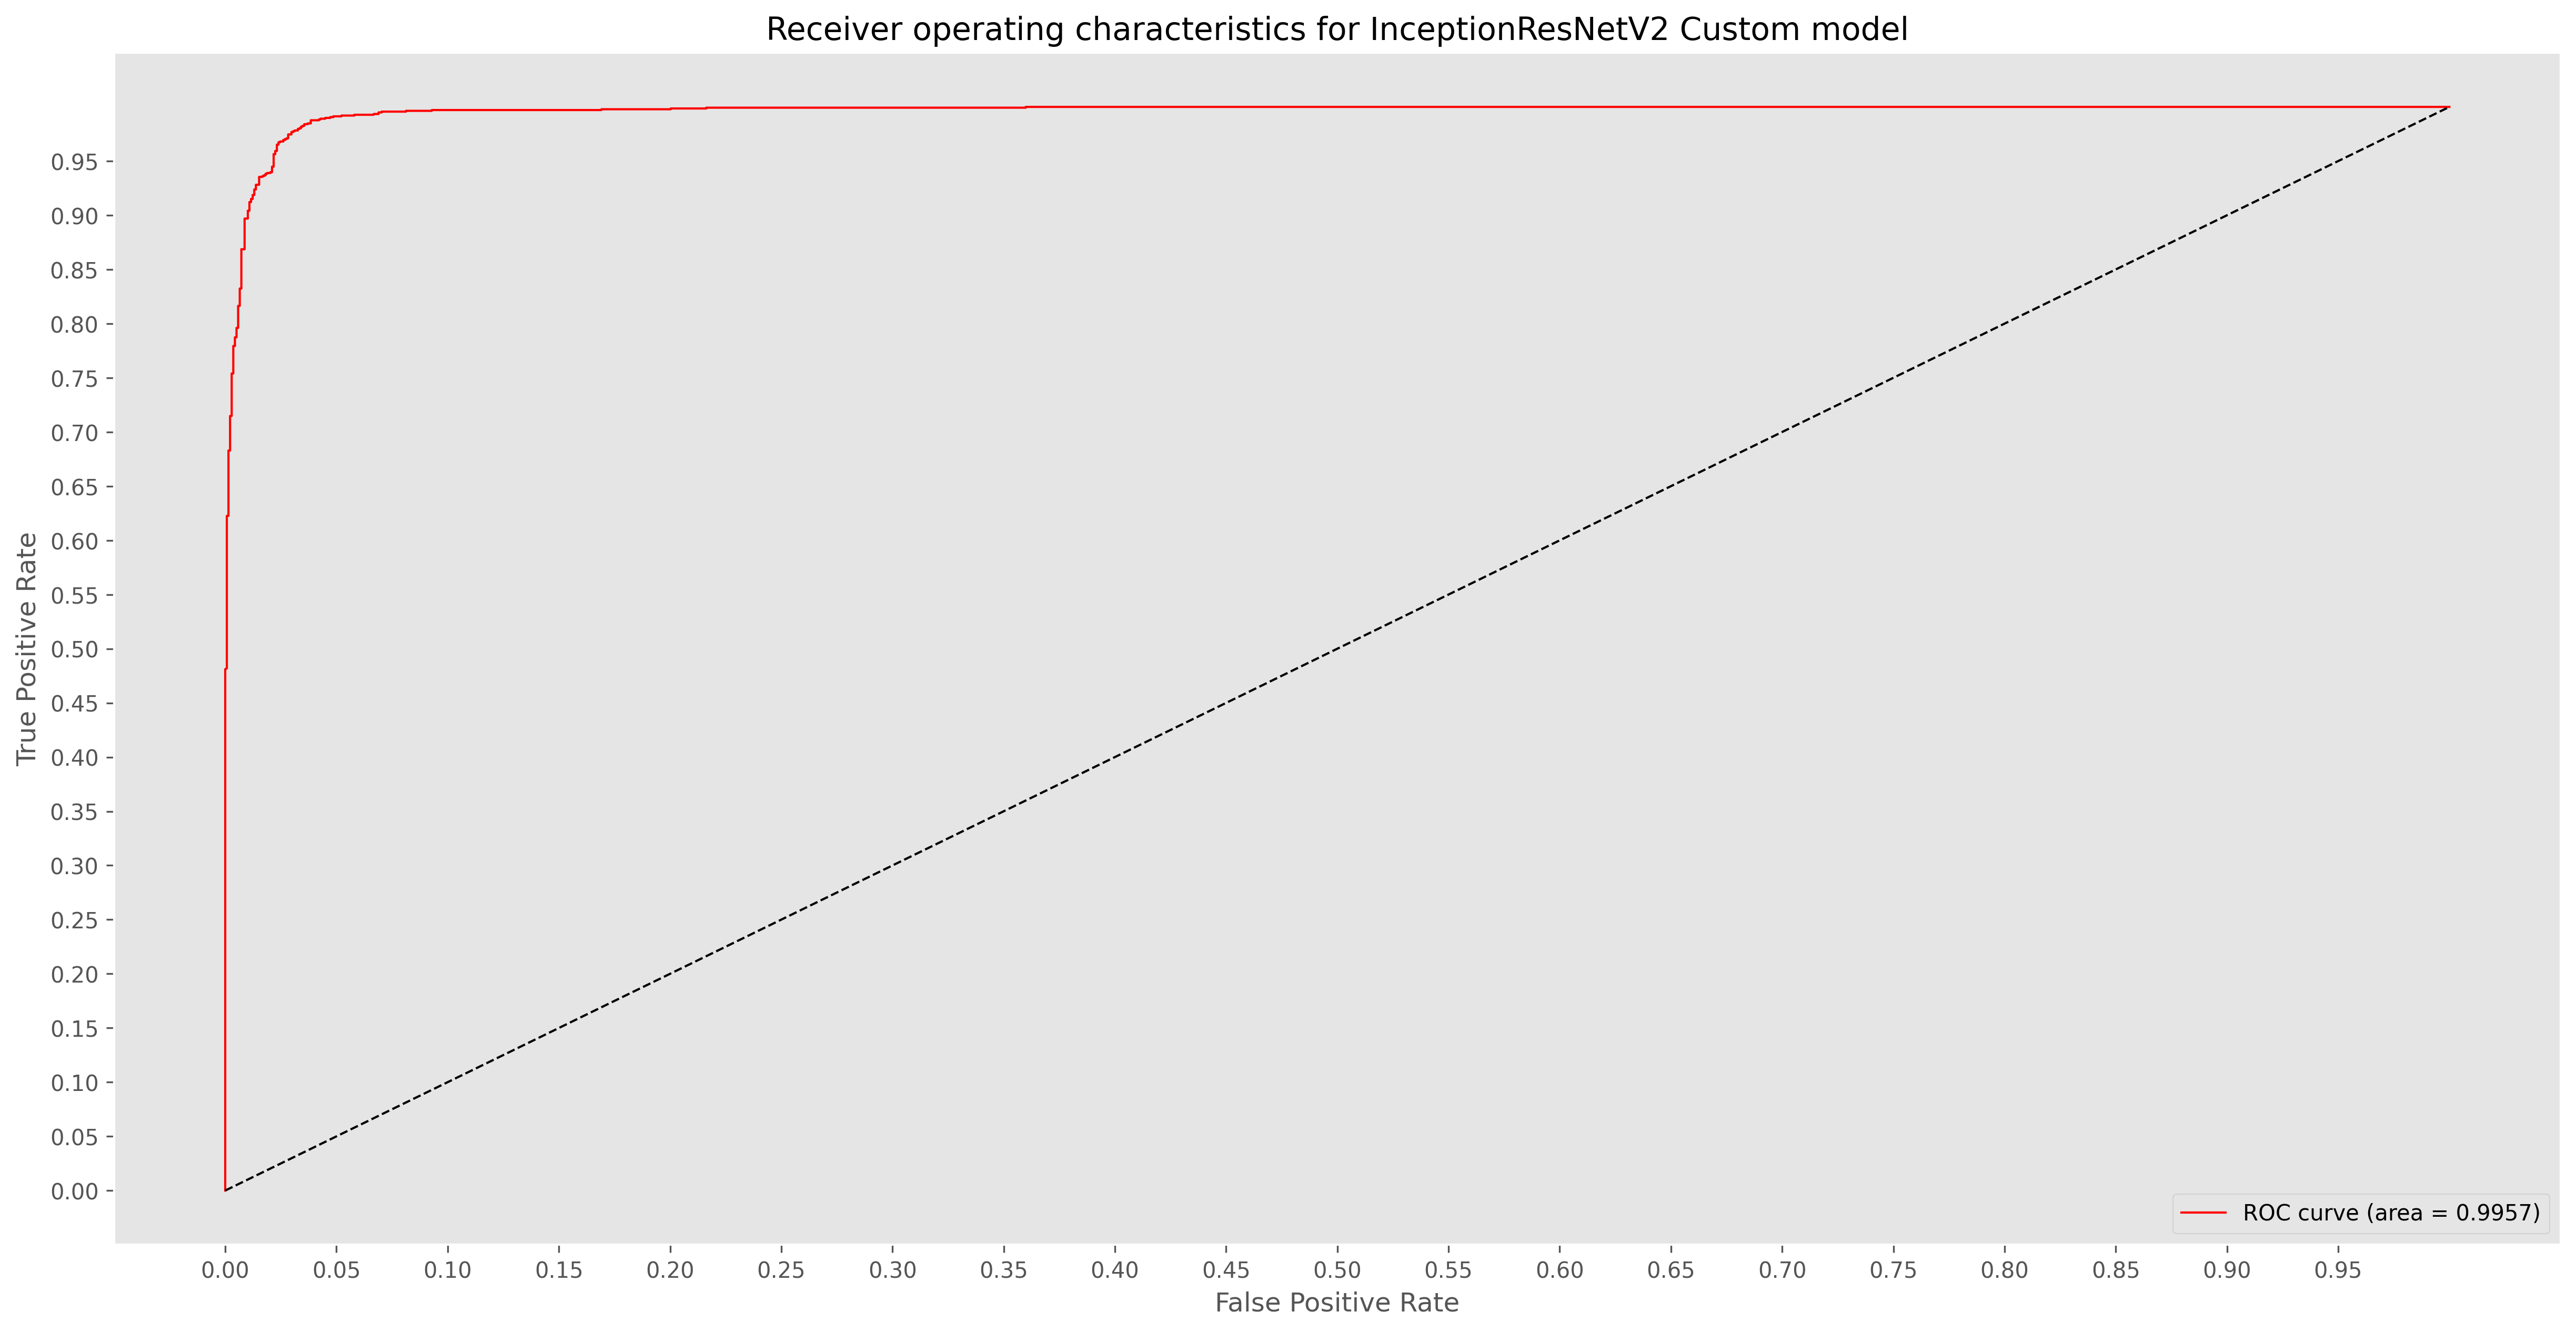

In [224]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, incepres_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for InceptionResNetV2 Custom model')
plt.legend(loc="lower right")
plt.show()


In [225]:
#%% construct the ensemble model
custom_model = custom_cnn(model_input)
vgg19_custom_model = vgg19_cnn(model_input)
squeeze_custom_model = squeeze_cnn(model_input)
inceptionresnet_custom_model = incepres_cnn(model_input)

#load the best weights
custom_model.load_weights('weights/custom_cnn.h5')
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

In [226]:
#append the models to the list

models = [custom_model, vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

Ensemble model definition is very straightforward. It uses the same input layer thas is shared between all previous models. 
In the top layer, the ensemble computes the average of three models' outputs (predictions) by using Average() layer. The ensemble is expected to have a lower error rate than any single model and better accuracy.

In [227]:
def ensemble(models, model_input):
    
    outputs = [m.output for m in models]
    print(outputs)
    y = Average()(outputs) 
    model = Model(model_input, y, name='ensemble')
    return model

#istantitate the ensemble model and report the summary
ensemble_model = ensemble(models,model_input)

#save the ensemble model with the architecture and the weights together
ensemble_model.save('weights/ensemblemodel.h5')
print('The Ensemble Model is Saved')

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_33')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_34')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_35')>]
The Ensemble Model is Saved


In [228]:
#%% load the ensemble model and make predictions on the test data
ensemble_model=load_model('weights/ensemblemodel.h5')
ensemble_model.summary()
#plot_model(ensemble_model, to_file='ensemble_model.png',show_shapes=True, show_layer_names=False)

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2030 (Conv2D)            (None, 49, 49, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2043 (Batch (None, 49, 49, 32)   96          conv2d_2030[0][0]                
__________________________________________________________________________________________________
activation_2030 (Activation)    (None, 49, 49, 32)   0           batch_normalization_2043[0][0]   
___________________________________________________________________________________________

block17_18_ac (Activation)      (None, 4, 4, 1088)   0           block17_18[0][0]                 
__________________________________________________________________________________________________
conv2d_2179 (Conv2D)            (None, 4, 4, 128)    139264      block17_18_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_2192 (Batch (None, 4, 4, 128)    384         conv2d_2179[0][0]                
__________________________________________________________________________________________________
activation_2179 (Activation)    (None, 4, 4, 128)    0           batch_normalization_2192[0][0]   
__________________________________________________________________________________________________
conv2d_2180 (Conv2D)            (None, 4, 4, 160)    143360      activation_2179[0][0]            
__________________________________________________________________________________________________
batch_norm

batch_normalization_2207 (Batch (None, 1, 1, 192)    576         conv2d_2194[0][0]                
__________________________________________________________________________________________________
activation_2194 (Activation)    (None, 1, 1, 192)    0           batch_normalization_2207[0][0]   
__________________________________________________________________________________________________
conv2d_2195 (Conv2D)            (None, 1, 1, 224)    129024      activation_2194[0][0]            
__________________________________________________________________________________________________
batch_normalization_2208 (Batch (None, 1, 1, 224)    672         conv2d_2195[0][0]                
__________________________________________________________________________________________________
activation_2195 (Activation)    (None, 1, 1, 224)    0           batch_normalization_2208[0][0]   
__________________________________________________________________________________________________
conv2d_219

In [229]:
#evaluate accuracy
ensem_y_pred = ensemble_model.predict(validation_generator,
                                                nb_validation_samples/batch_size, workers=1)
ensemble_model_accuracy = accuracy_score(Y_test,ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Ensemble model is: ', ensemble_model_accuracy)

#evaluate mean squared error
ensemble_model_custom_mse = mean_squared_error(Y_test,ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Ensemble model is: ', ensemble_model_custom_mse)

#evaluate mean squared log error
ensemble_model_custom_msle = mean_squared_log_error(Y_test,ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Ensemble model is: ', ensemble_model_custom_msle)

The accuracy of the Ensemble model is:  0.9720609579100146
The Mean Squared Error of the Ensemble model is:  0.027939042089985485
The Mean Squared Log Error of the Ensemble model is:  0.013423396978121012


                   precision    recall  f1-score   support

class 0(abnormal)     0.9808    0.9630    0.9718      1378
  class 1(normal)     0.9636    0.9811    0.9723      1378

         accuracy                         0.9721      2756
        macro avg     0.9722    0.9721    0.9721      2756
     weighted avg     0.9722    0.9721    0.9721      2756

Confusion matrix, without normalization
[[1327   51]
 [  26 1352]]


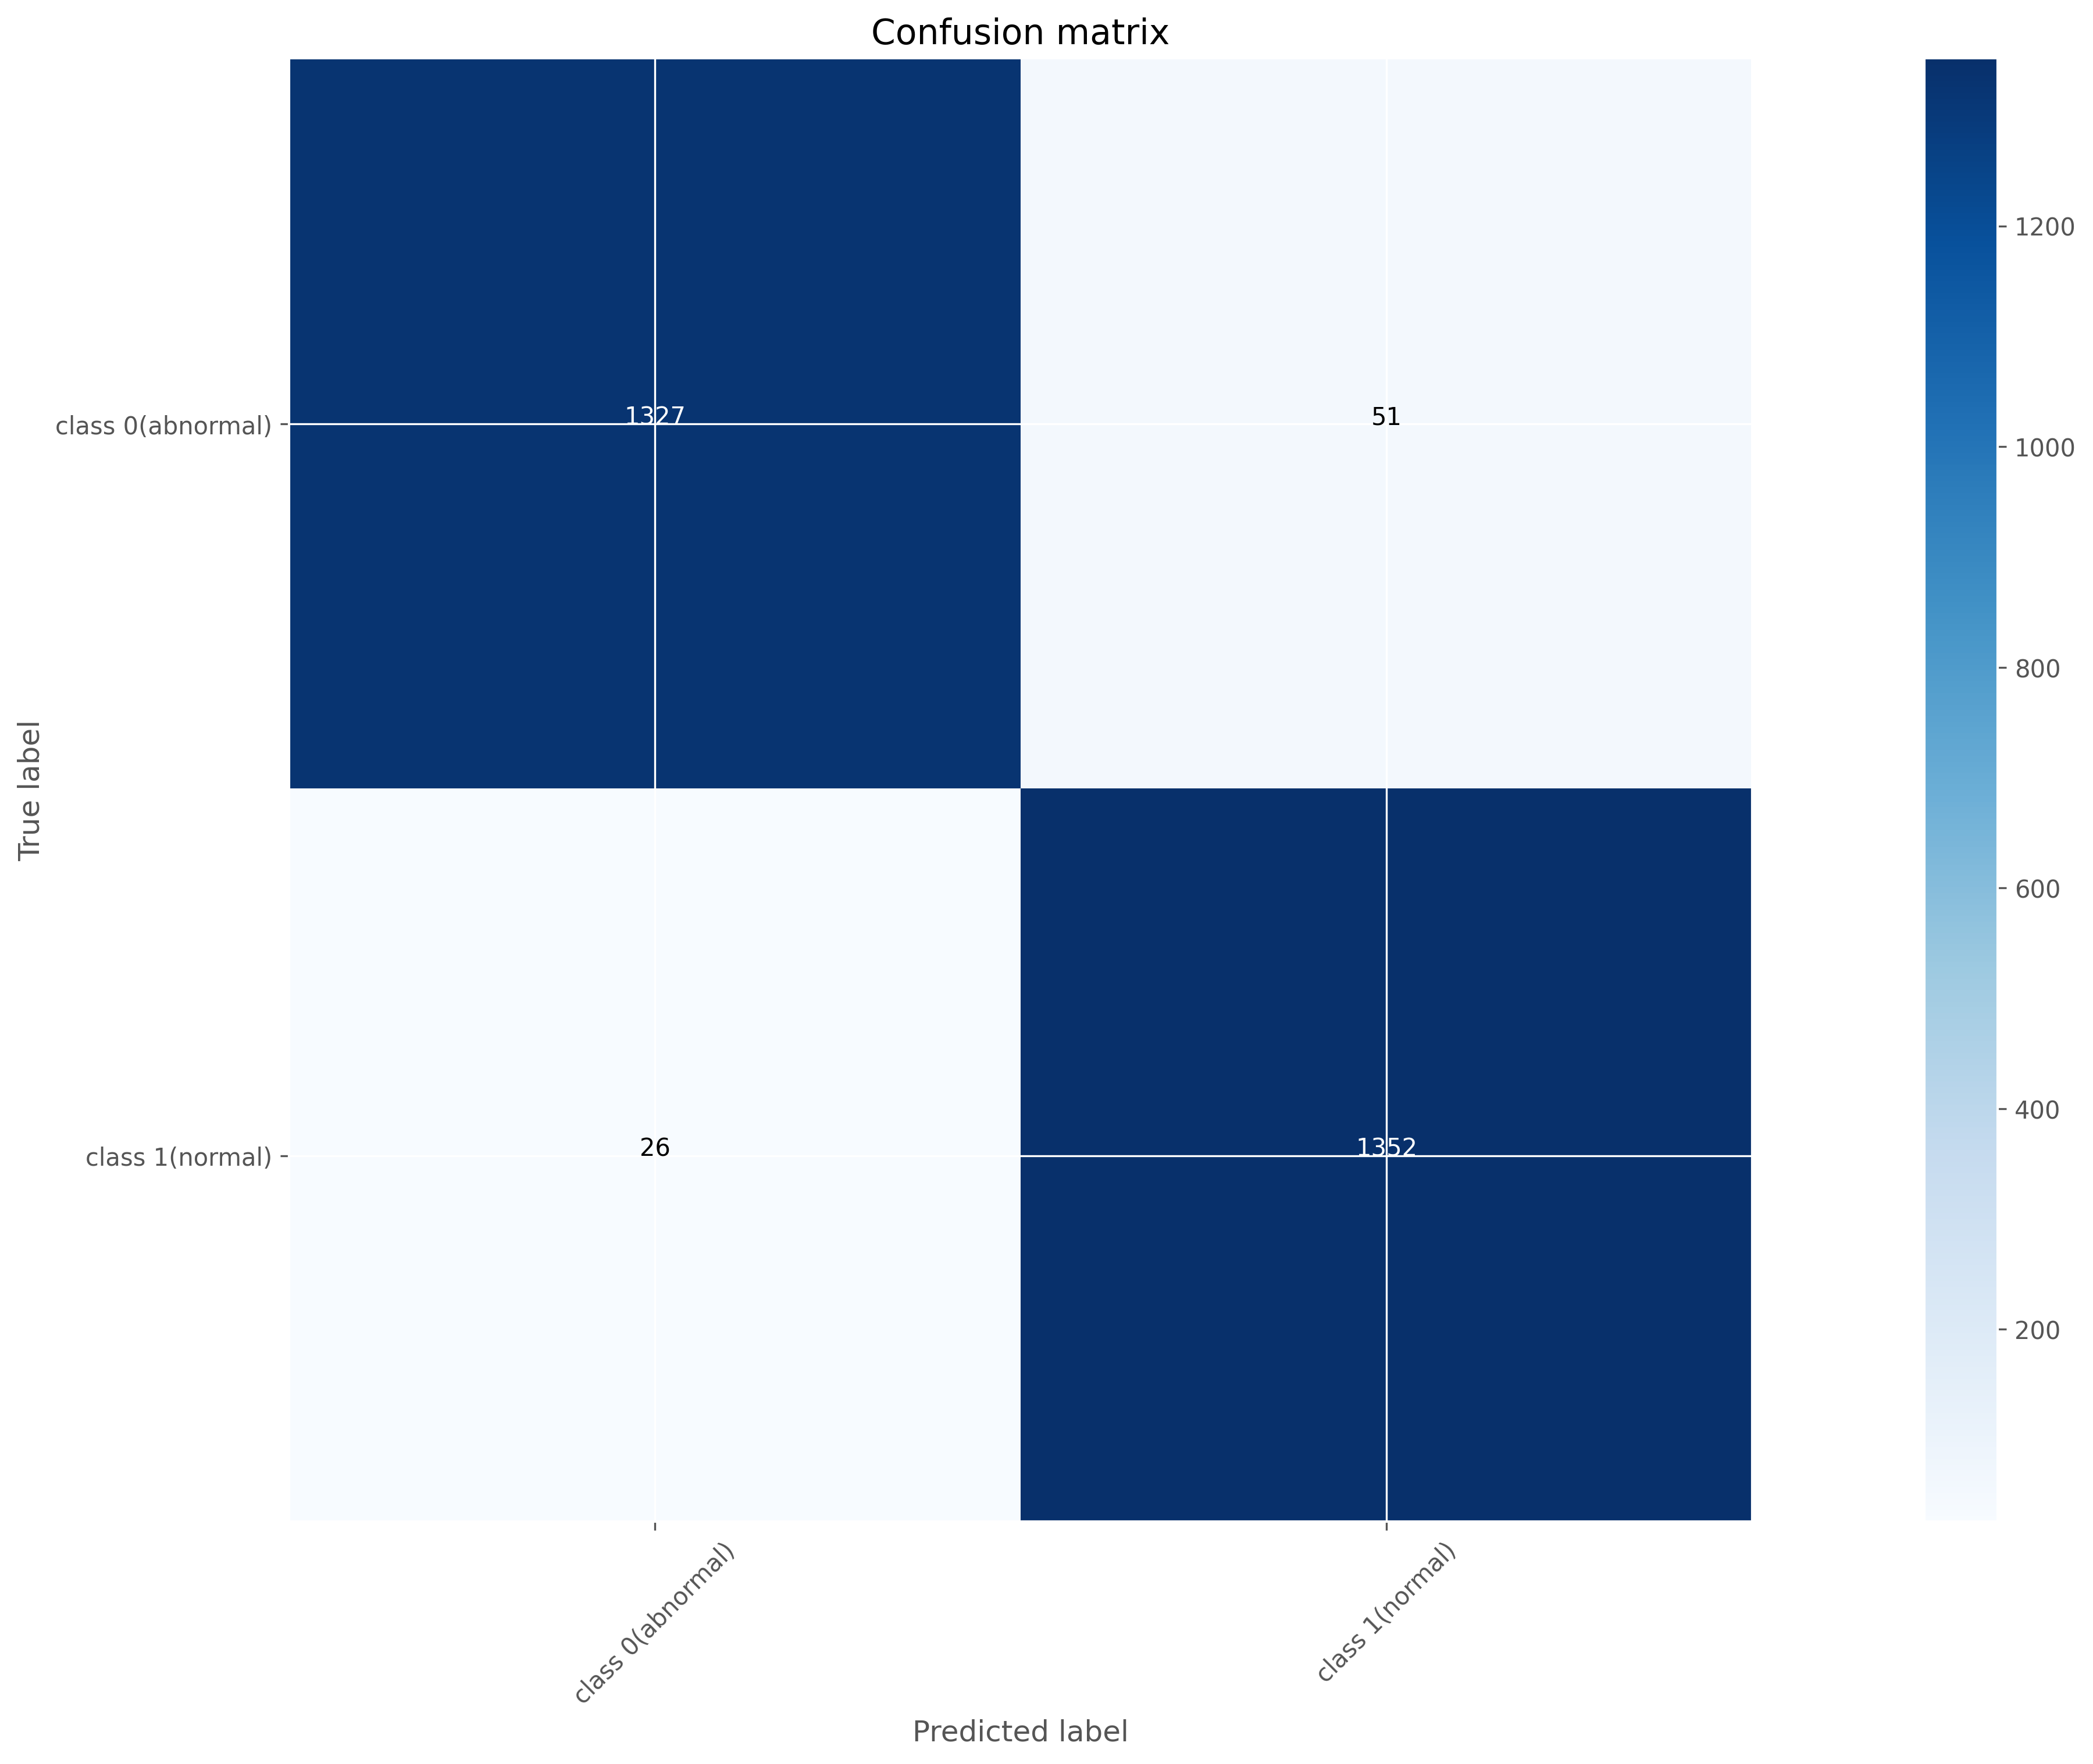

In [230]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


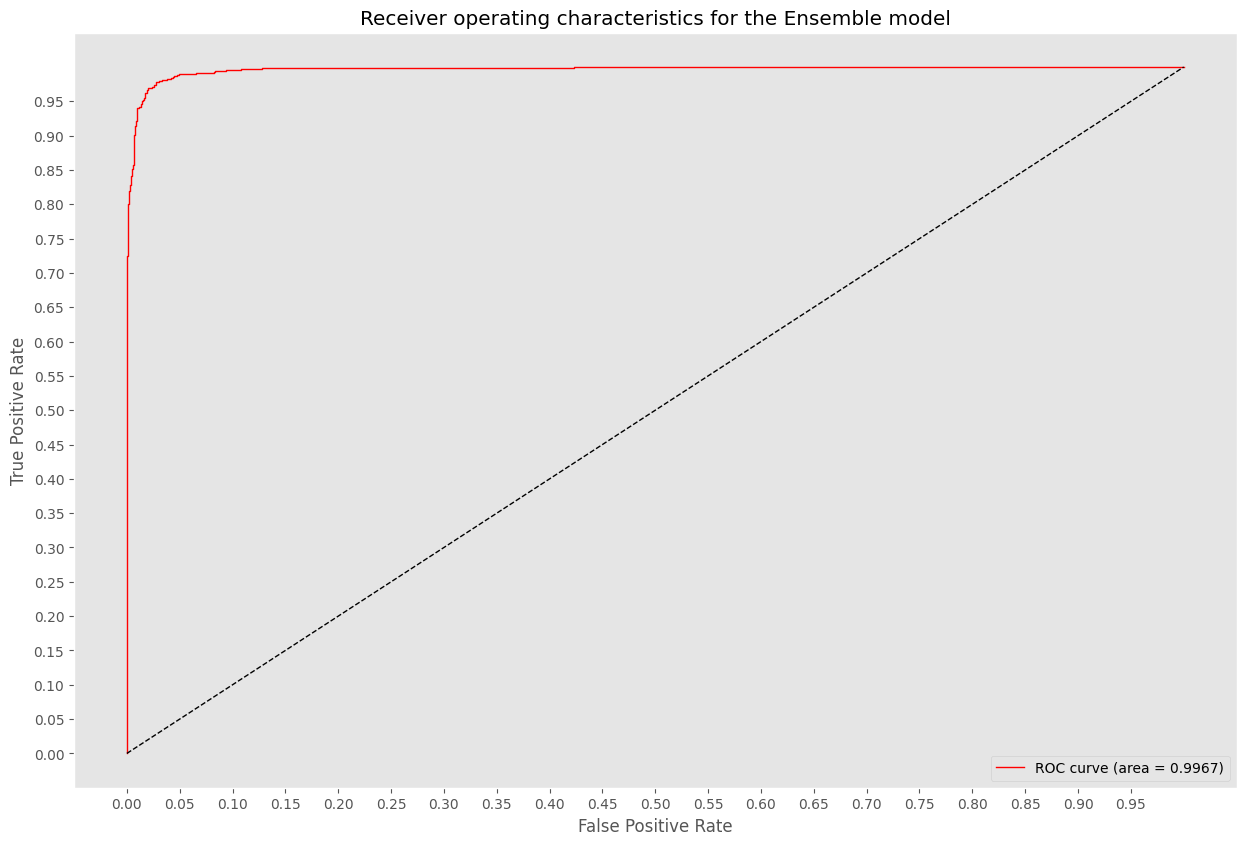

In [231]:
#%% compute the ROC-AUC values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for the Ensemble model')
plt.legend(loc="lower right")
plt.show()


In [232]:
#%% Other Possible Ensembles: 
# We can select the optimal ensemble from the collection of model combinations

pair_A = [custom_model, vgg19_custom_model]
pair_B = [custom_model, squeeze_custom_model]
pair_C = [custom_model, inceptionresnet_custom_model]
pair_D = [vgg19_custom_model, squeeze_custom_model]
pair_E = [vgg19_custom_model, inceptionresnet_custom_model]
pair_F = [squeeze_custom_model, inceptionresnet_custom_model]
pair_G = [custom_model, vgg19_custom_model, squeeze_custom_model]
pair_H = [custom_model, vgg19_custom_model, inceptionresnet_custom_model]
pair_I = [vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_33')>]
The Ensemble Model is Saved
The accuracy of the Pair A Ensemble model is:  0.9680696661828737
The Mean Squared Error of the Pair A Ensemble model is:  0.03193033381712627
The Mean Squared Log Error of the Pair A Ensemble model is:  0.015341025117852583
                   precision    recall  f1-score   support

class 0(abnormal)     0.9771    0.9586    0.9678      1378
  class 1(normal)     0.9594    0.9775    0.9684      1378

         accuracy                         0.9681      2756
        macro avg     0.9682    0.9681    0.9681      2756
     weighted avg     0.9682    0.9681    0.9681      2756

Confusion matrix, without normalization
[[1321   57]
 [  31 1347]]


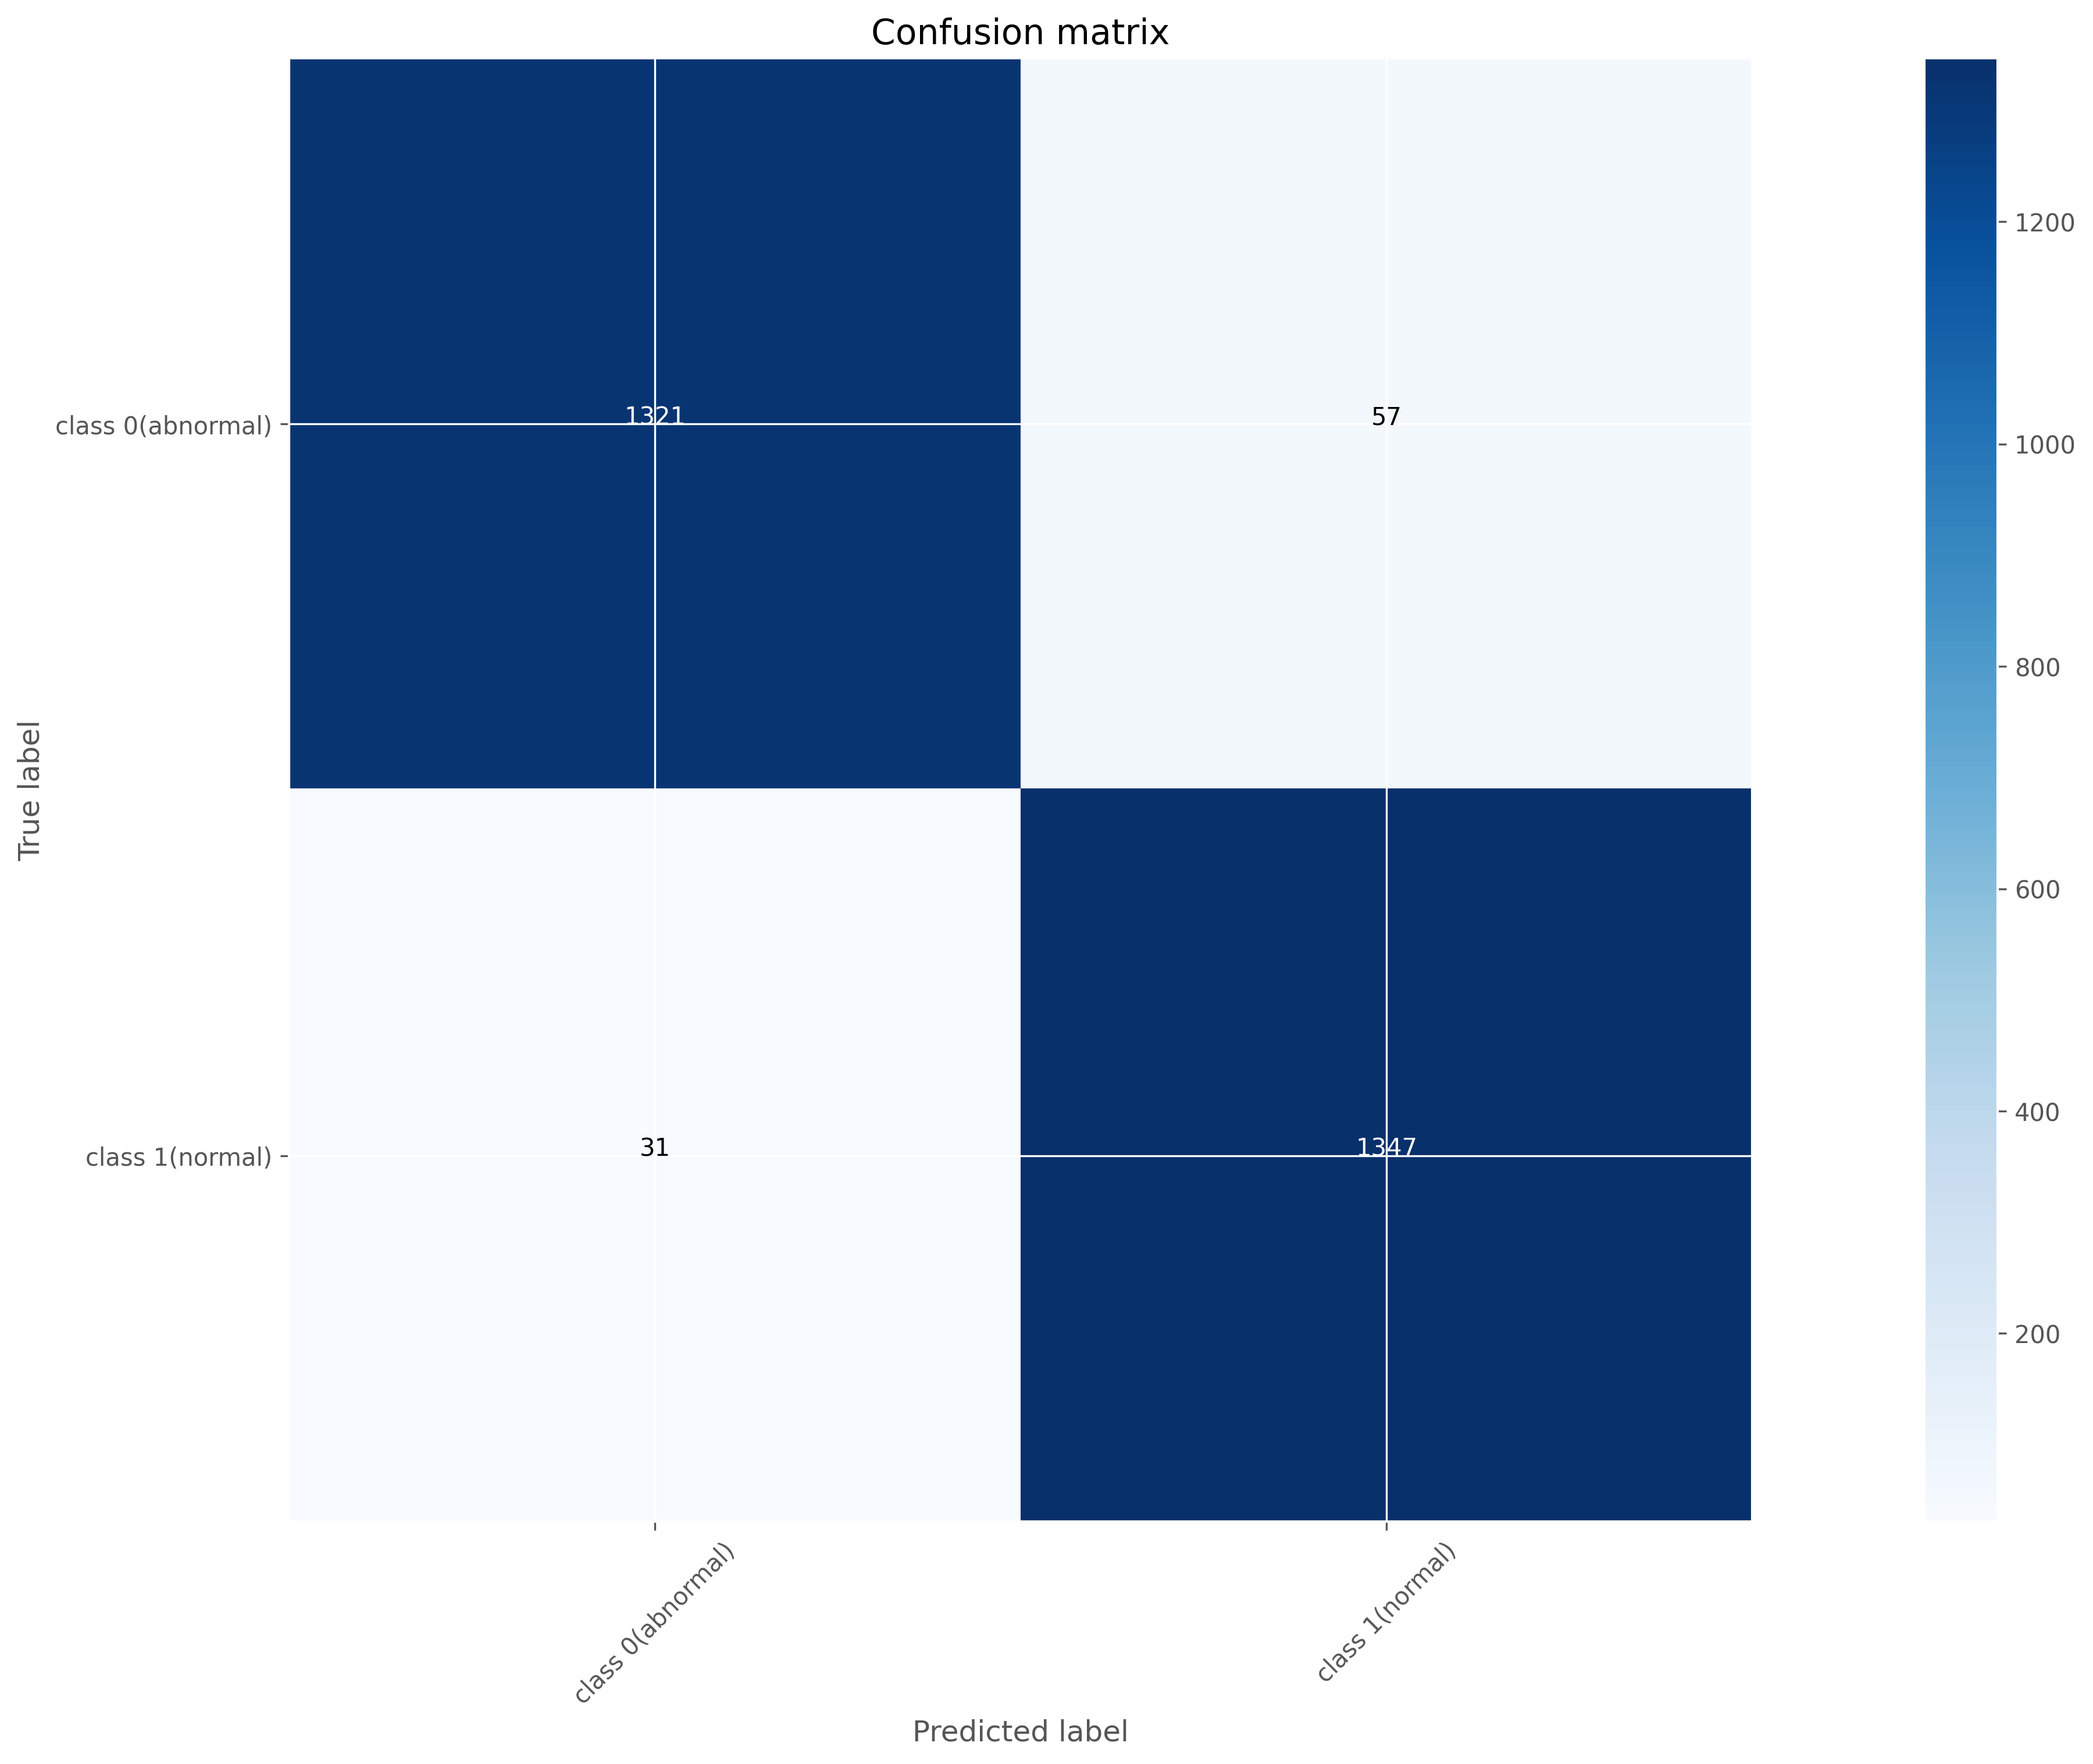

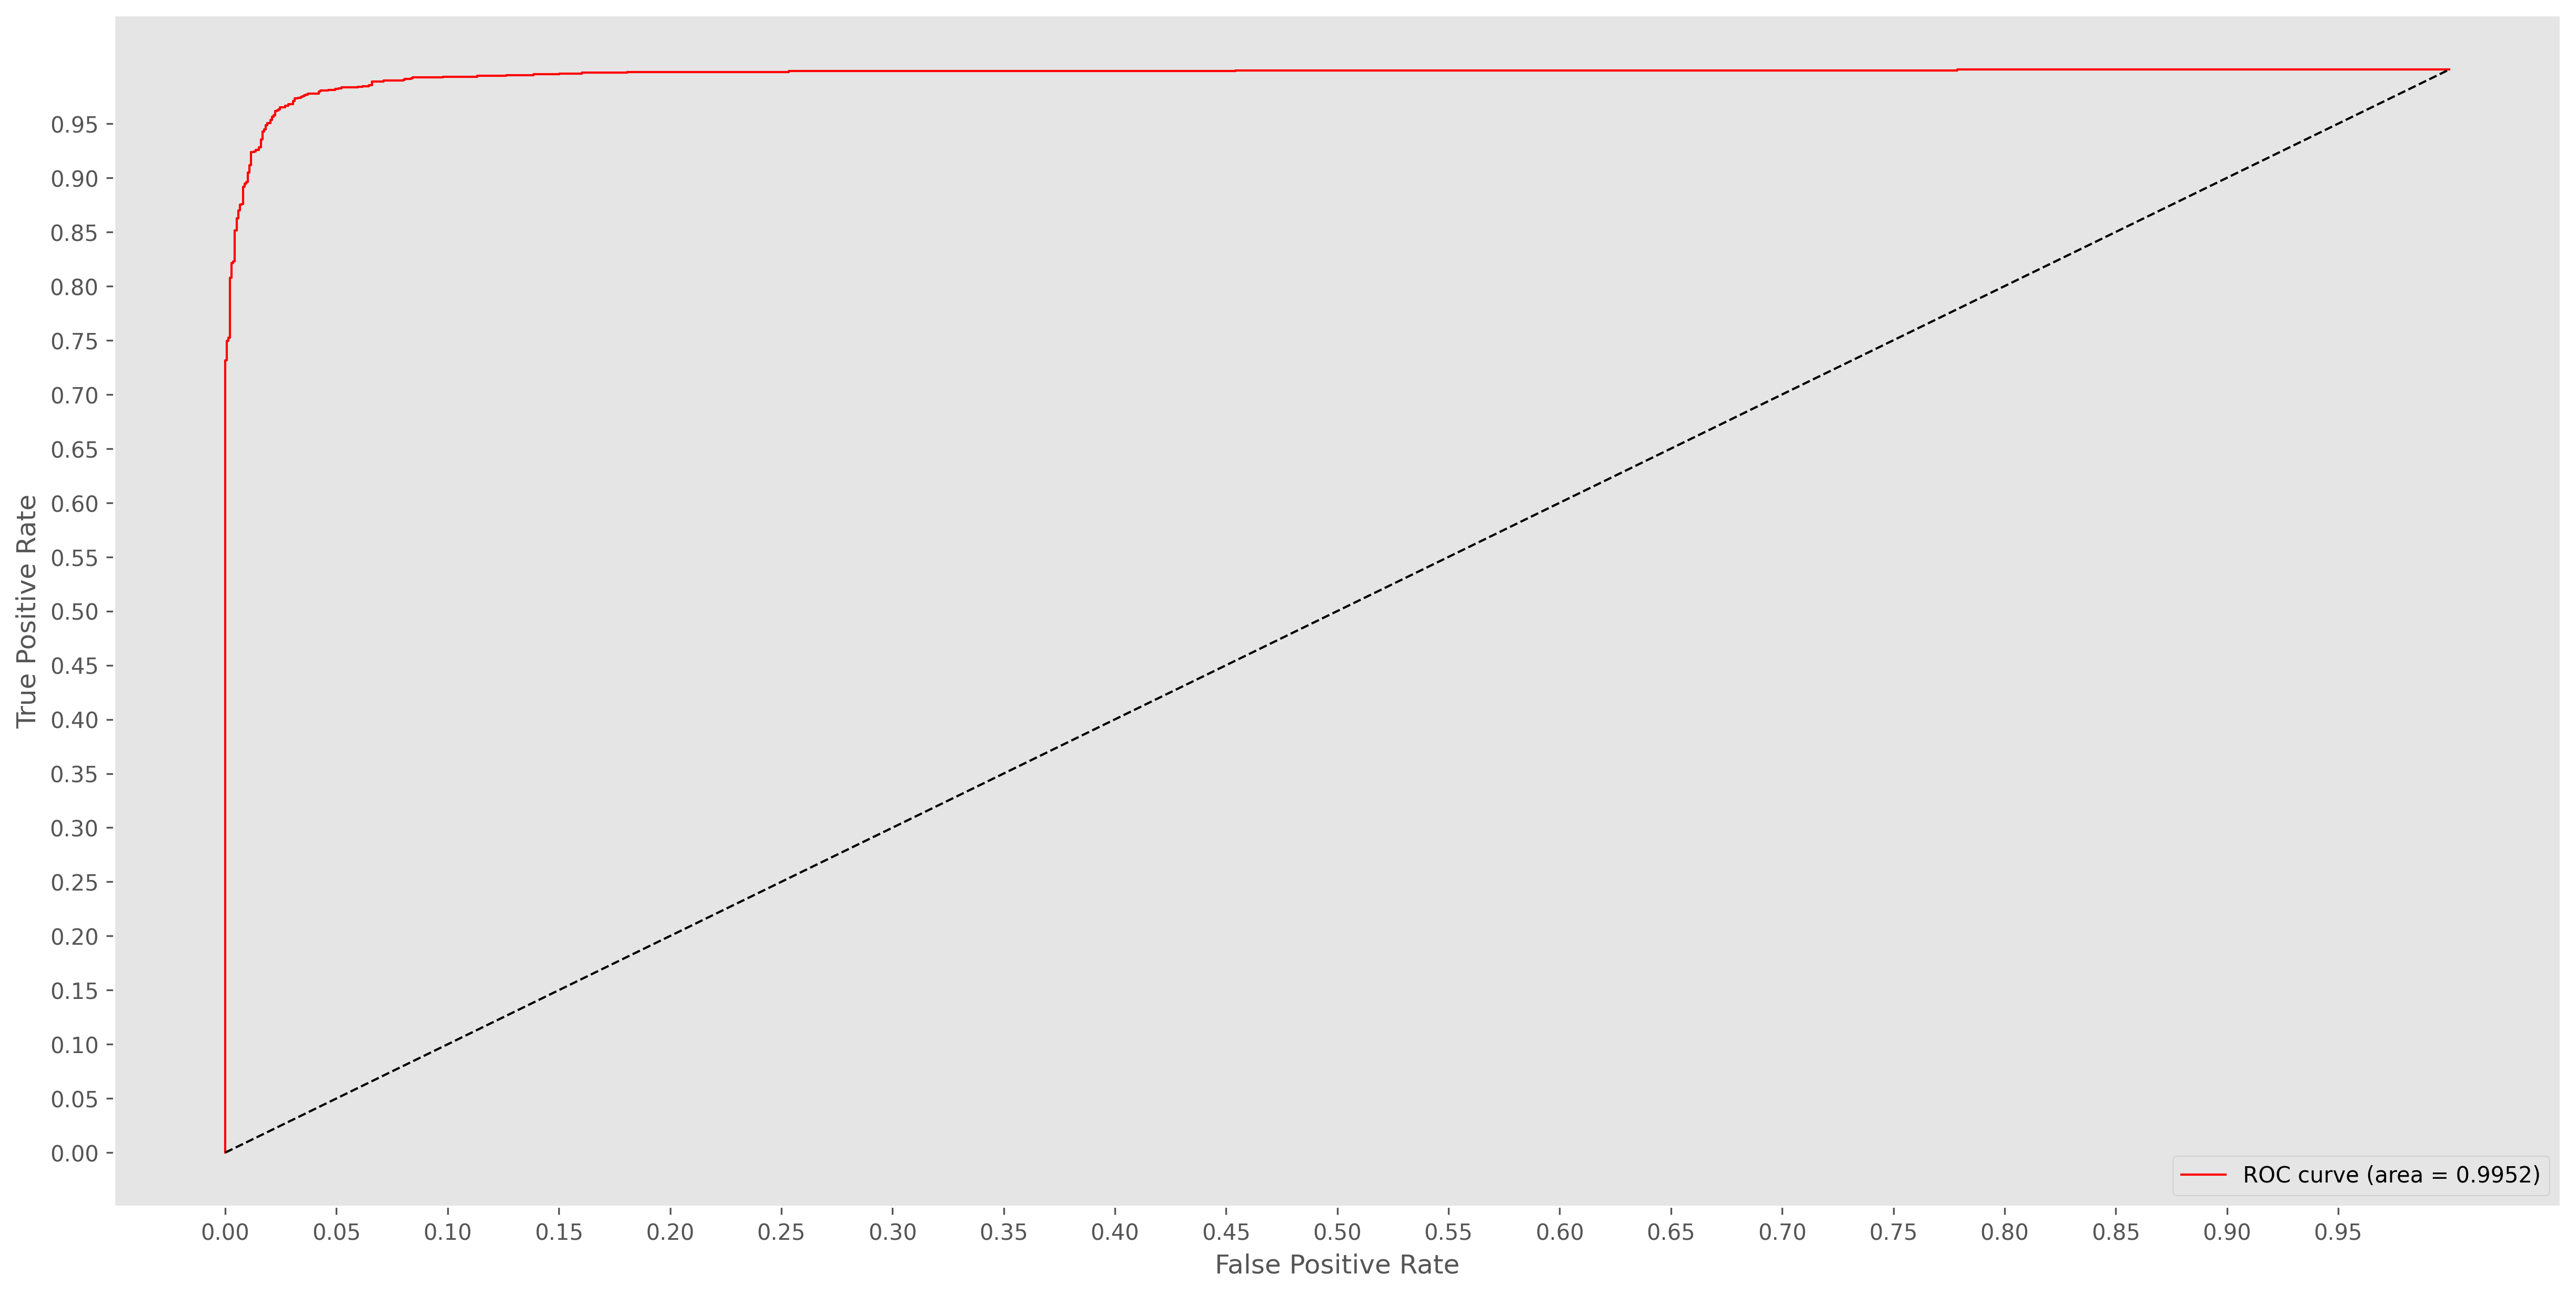

In [233]:
#%% evaluate the performance of these paired ensembles

pair_A_ensemble_model = ensemble(pair_A, model_input)
pair_A_ensemble_model.save('weights/ensemblemodel_pairA.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
A_ensem_y_pred = pair_A_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
A_ensemble_model_accuracy = accuracy_score(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair A Ensemble model is: ', A_ensemble_model_accuracy)

#evaluate mean squared error
A_ensemble_model_custom_mse = mean_squared_error(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_mse)

#evaluate mean squared log error
A_ensemble_model_custom_msle = mean_squared_log_error(Y_test,A_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,A_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,A_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, A_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_34')>]
The Ensemble Model is Saved
The accuracy of the Pair B Ensemble model is:  0.9684325108853411
The Mean Squared Error of the Pair B Ensemble model is:  0.031567489114658925
The Mean Squared Log Error of the Pair B Ensemble model is:  0.015166695286967895
                   precision    recall  f1-score   support

class 0(abnormal)     0.9771    0.9594    0.9681      1378
  class 1(normal)     0.9601    0.9775    0.9687      1378

         accuracy                         0.9684      2756
        macro avg     0.9686    0.9684    0.9684      2756
     weighted avg     0.9686    0.9684    0.9684      2756

Confusion matrix, without normalization
[[1322   56]
 [  31 1347]]


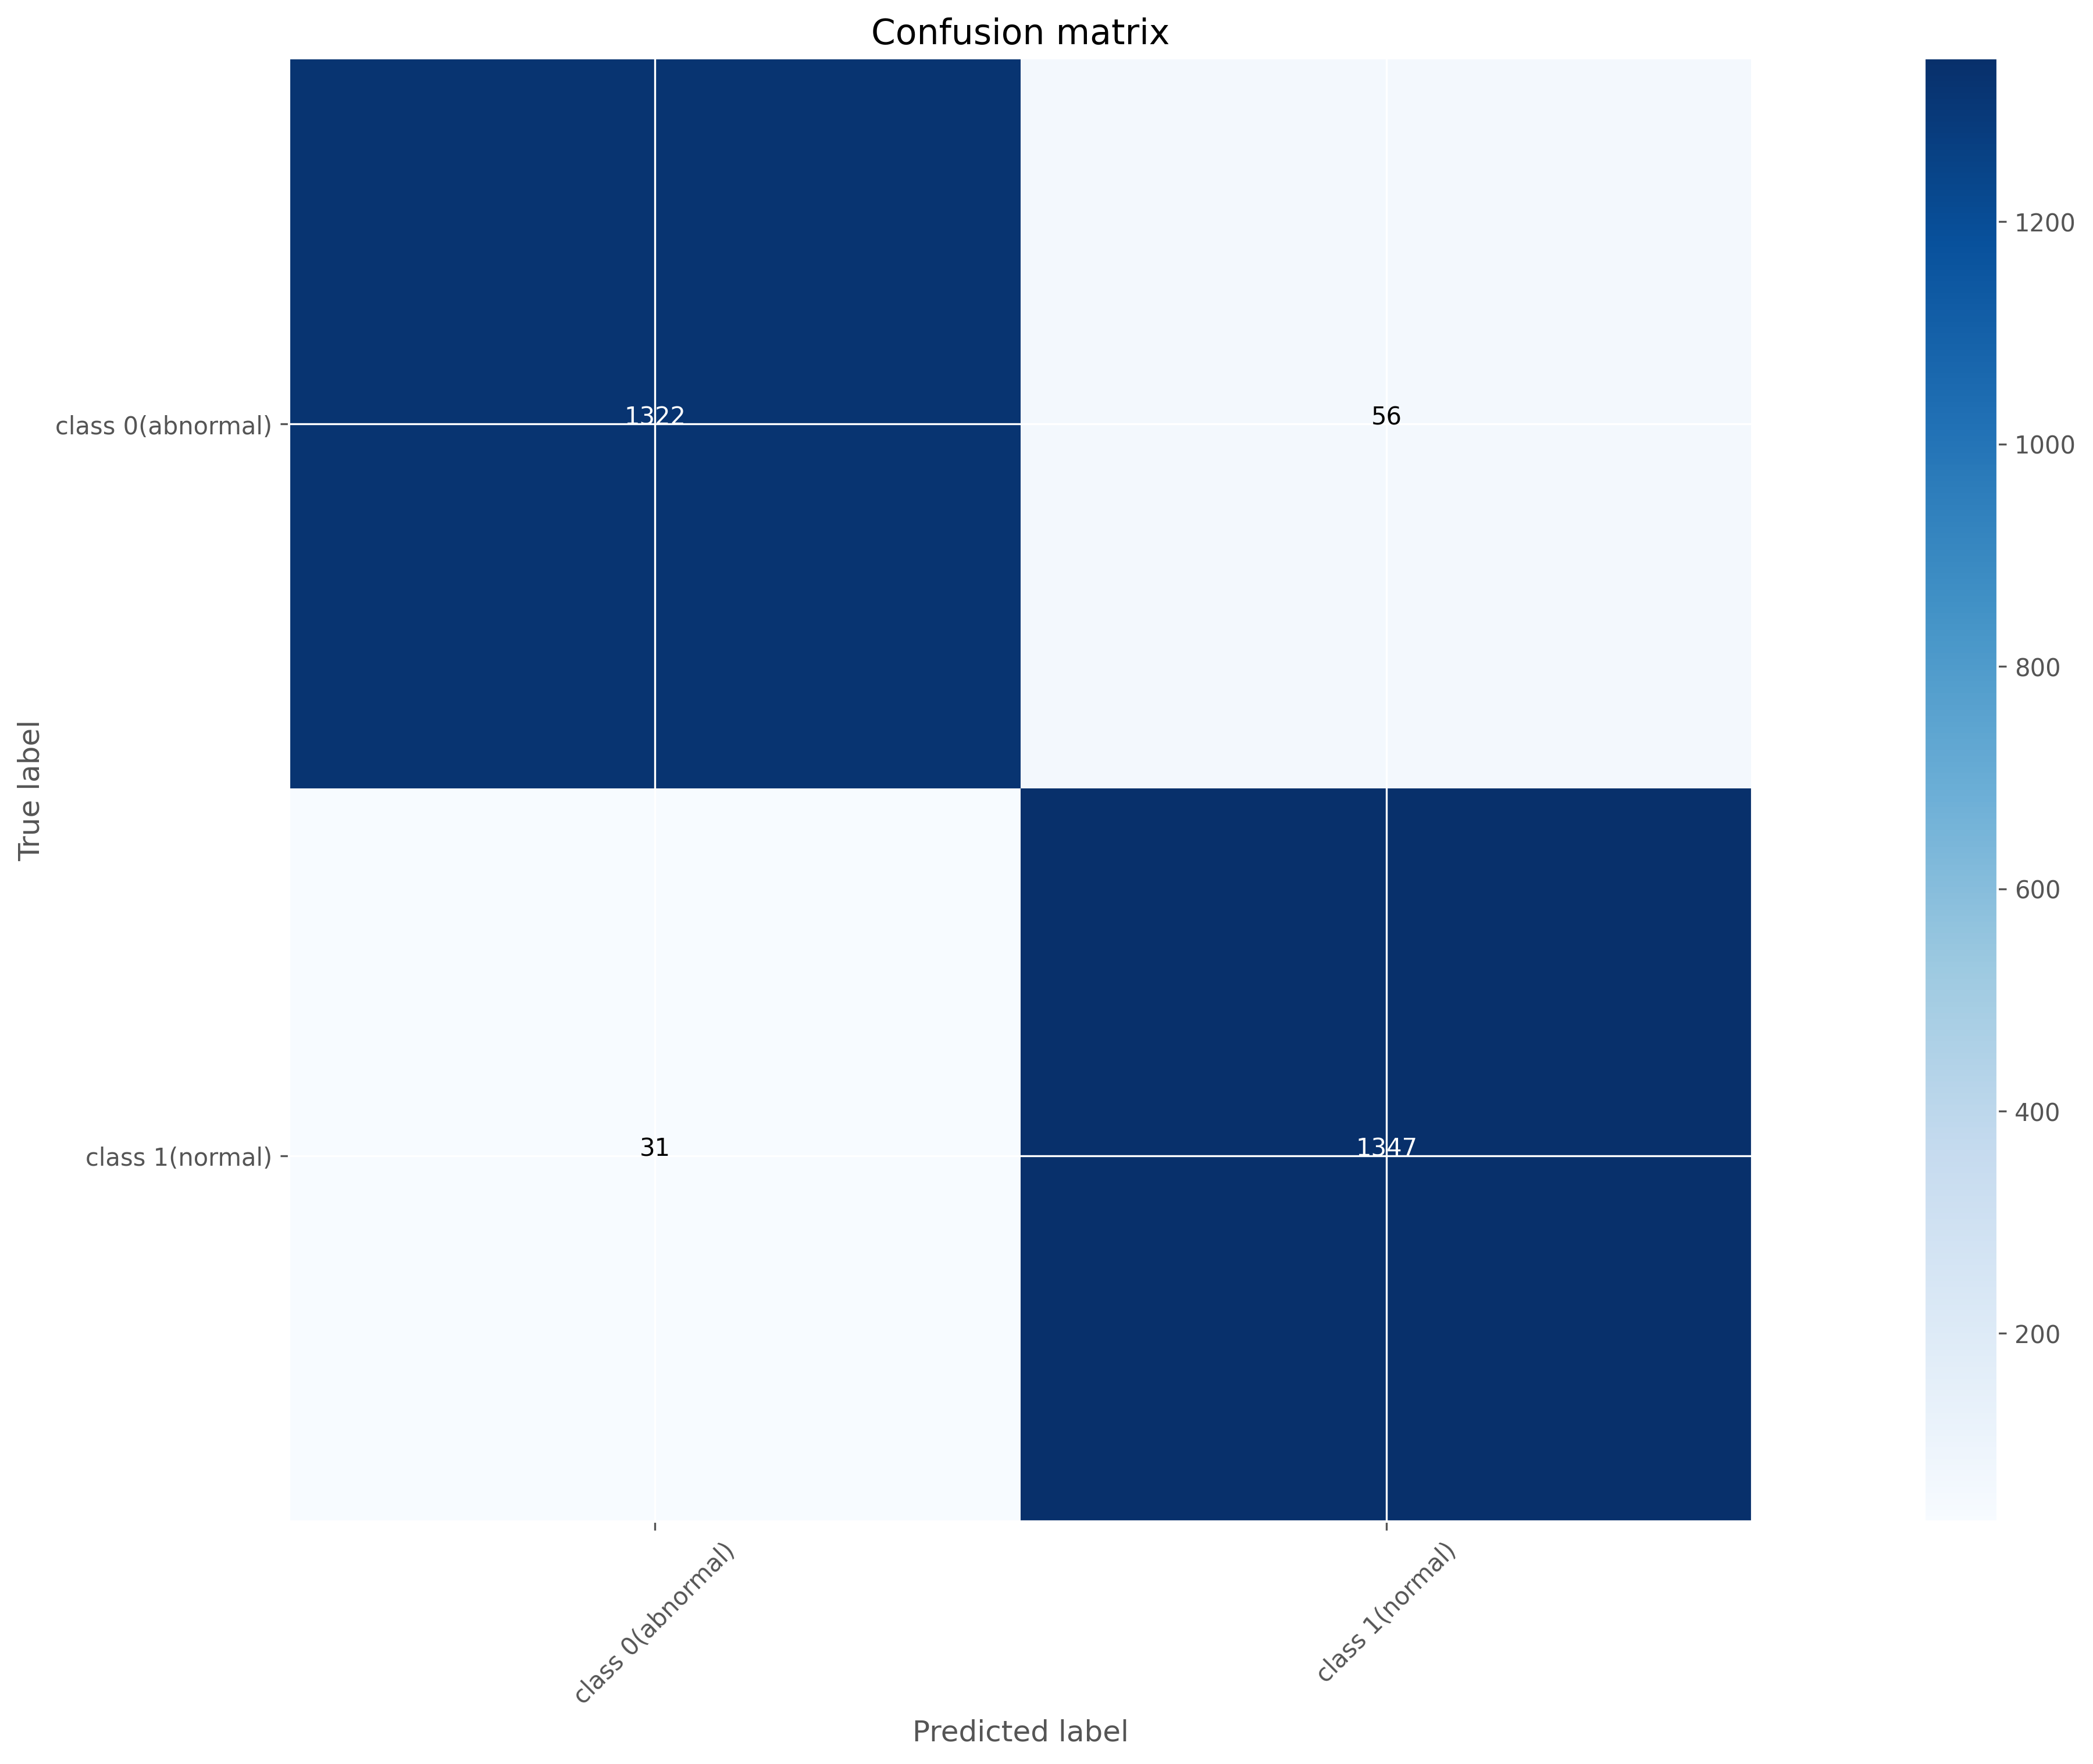

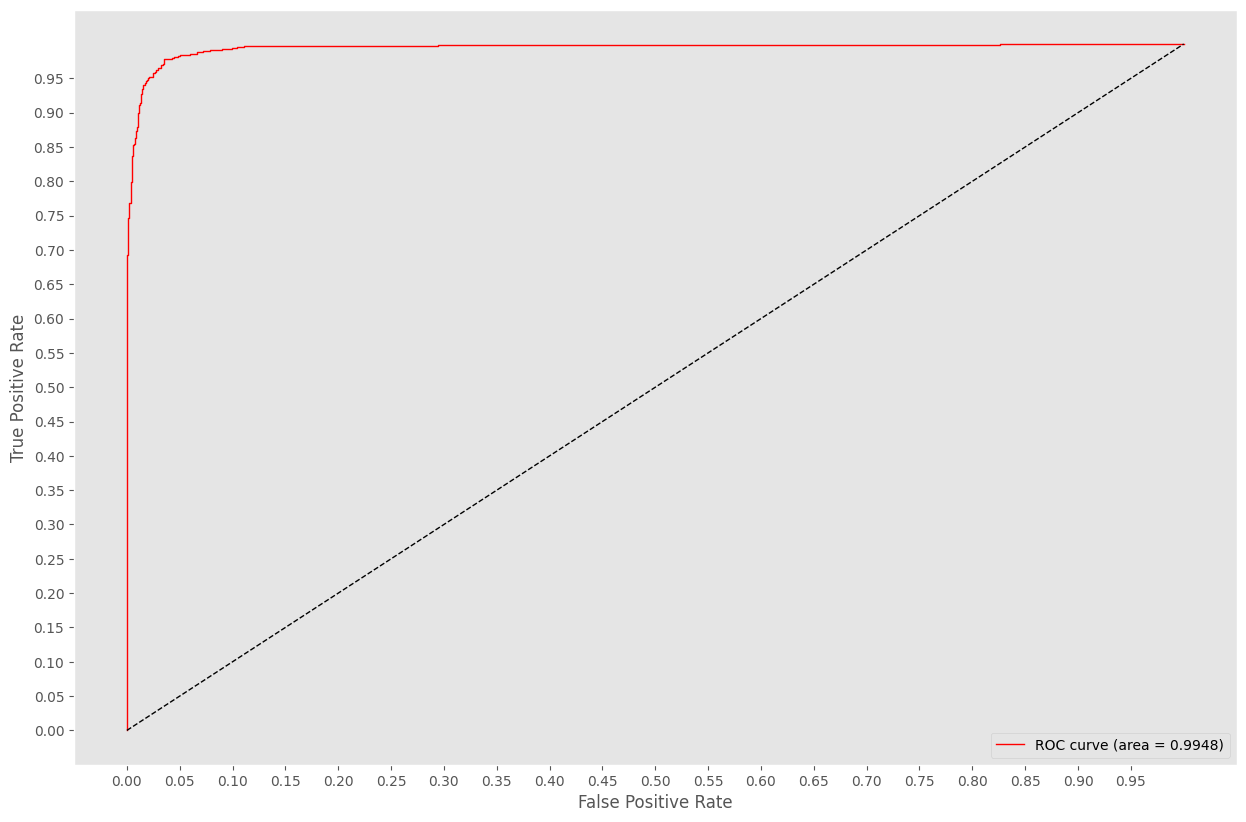

In [234]:
#%% Pair B 

pair_B_ensemble_model = ensemble(pair_B, model_input)
pair_B_ensemble_model.save('weights/ensemblemodel_pairB.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
B_ensem_y_pred = pair_B_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
B_ensemble_model_accuracy = accuracy_score(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair B Ensemble model is: ', B_ensemble_model_accuracy)

#evaluate mean squared error
B_ensemble_model_custom_mse = mean_squared_error(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_mse)

#evaluate mean squared log error
B_ensemble_model_custom_msle = mean_squared_log_error(Y_test,B_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,B_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,B_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, B_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_35')>]
The Ensemble Model is Saved
The accuracy of the Pair C Ensemble model is:  0.9738751814223512
The Mean Squared Error of the Pair C Ensemble model is:  0.026124818577648767
The Mean Squared Log Error of the Pair C Ensemble model is:  0.012551747823697569
                   precision    recall  f1-score   support

class 0(abnormal)     0.9837    0.9637    0.9736      1378
  class 1(normal)     0.9644    0.9840    0.9741      1378

         accuracy                         0.9739      2756
        macro avg     0.9741    0.9739    0.9739      2756
     weighted avg     0.9741    0.9739    0.9739      2756

Confusion matrix, without normalization
[[1328   50]
 [  22 1356]]


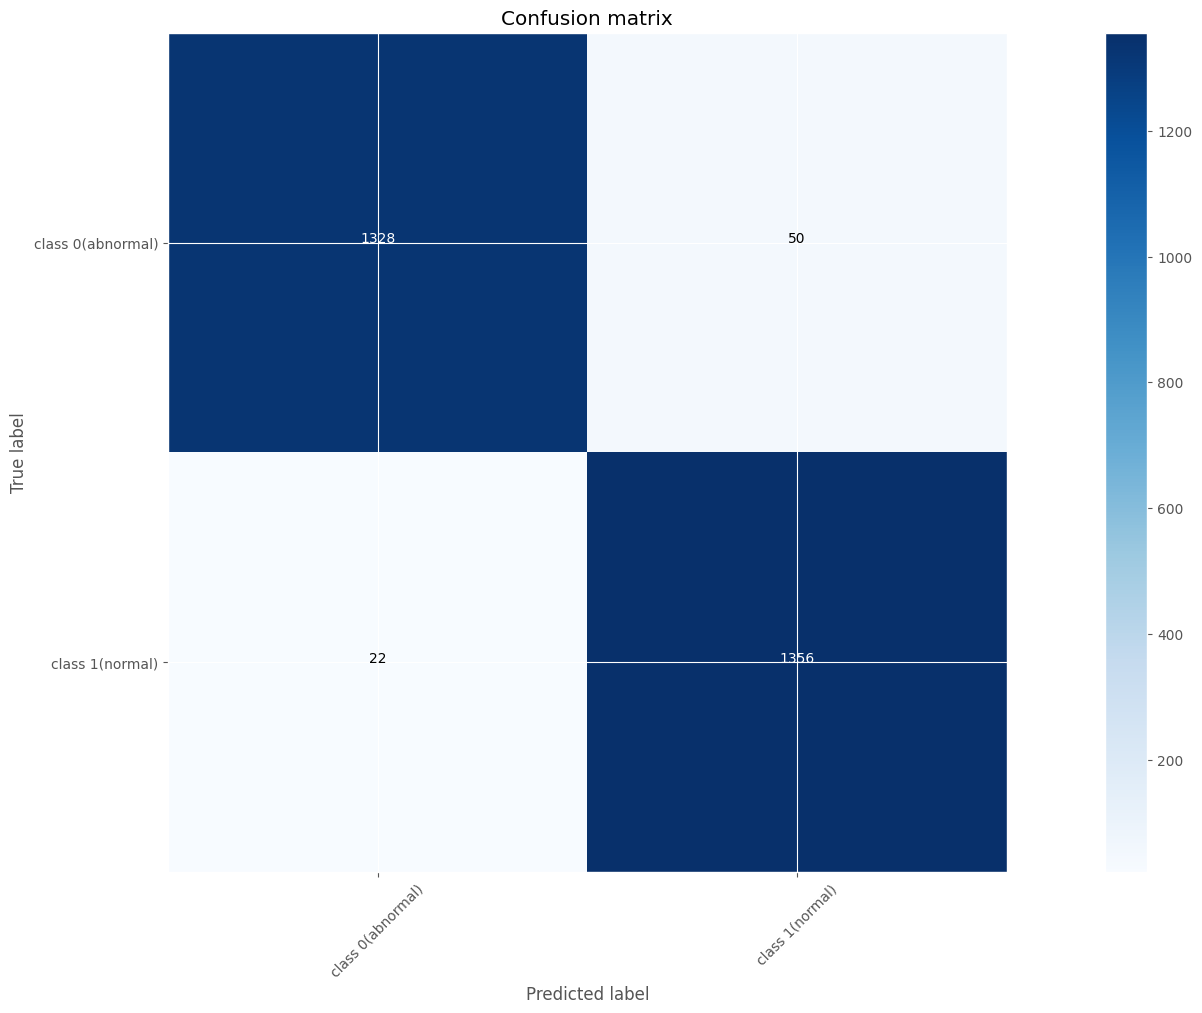

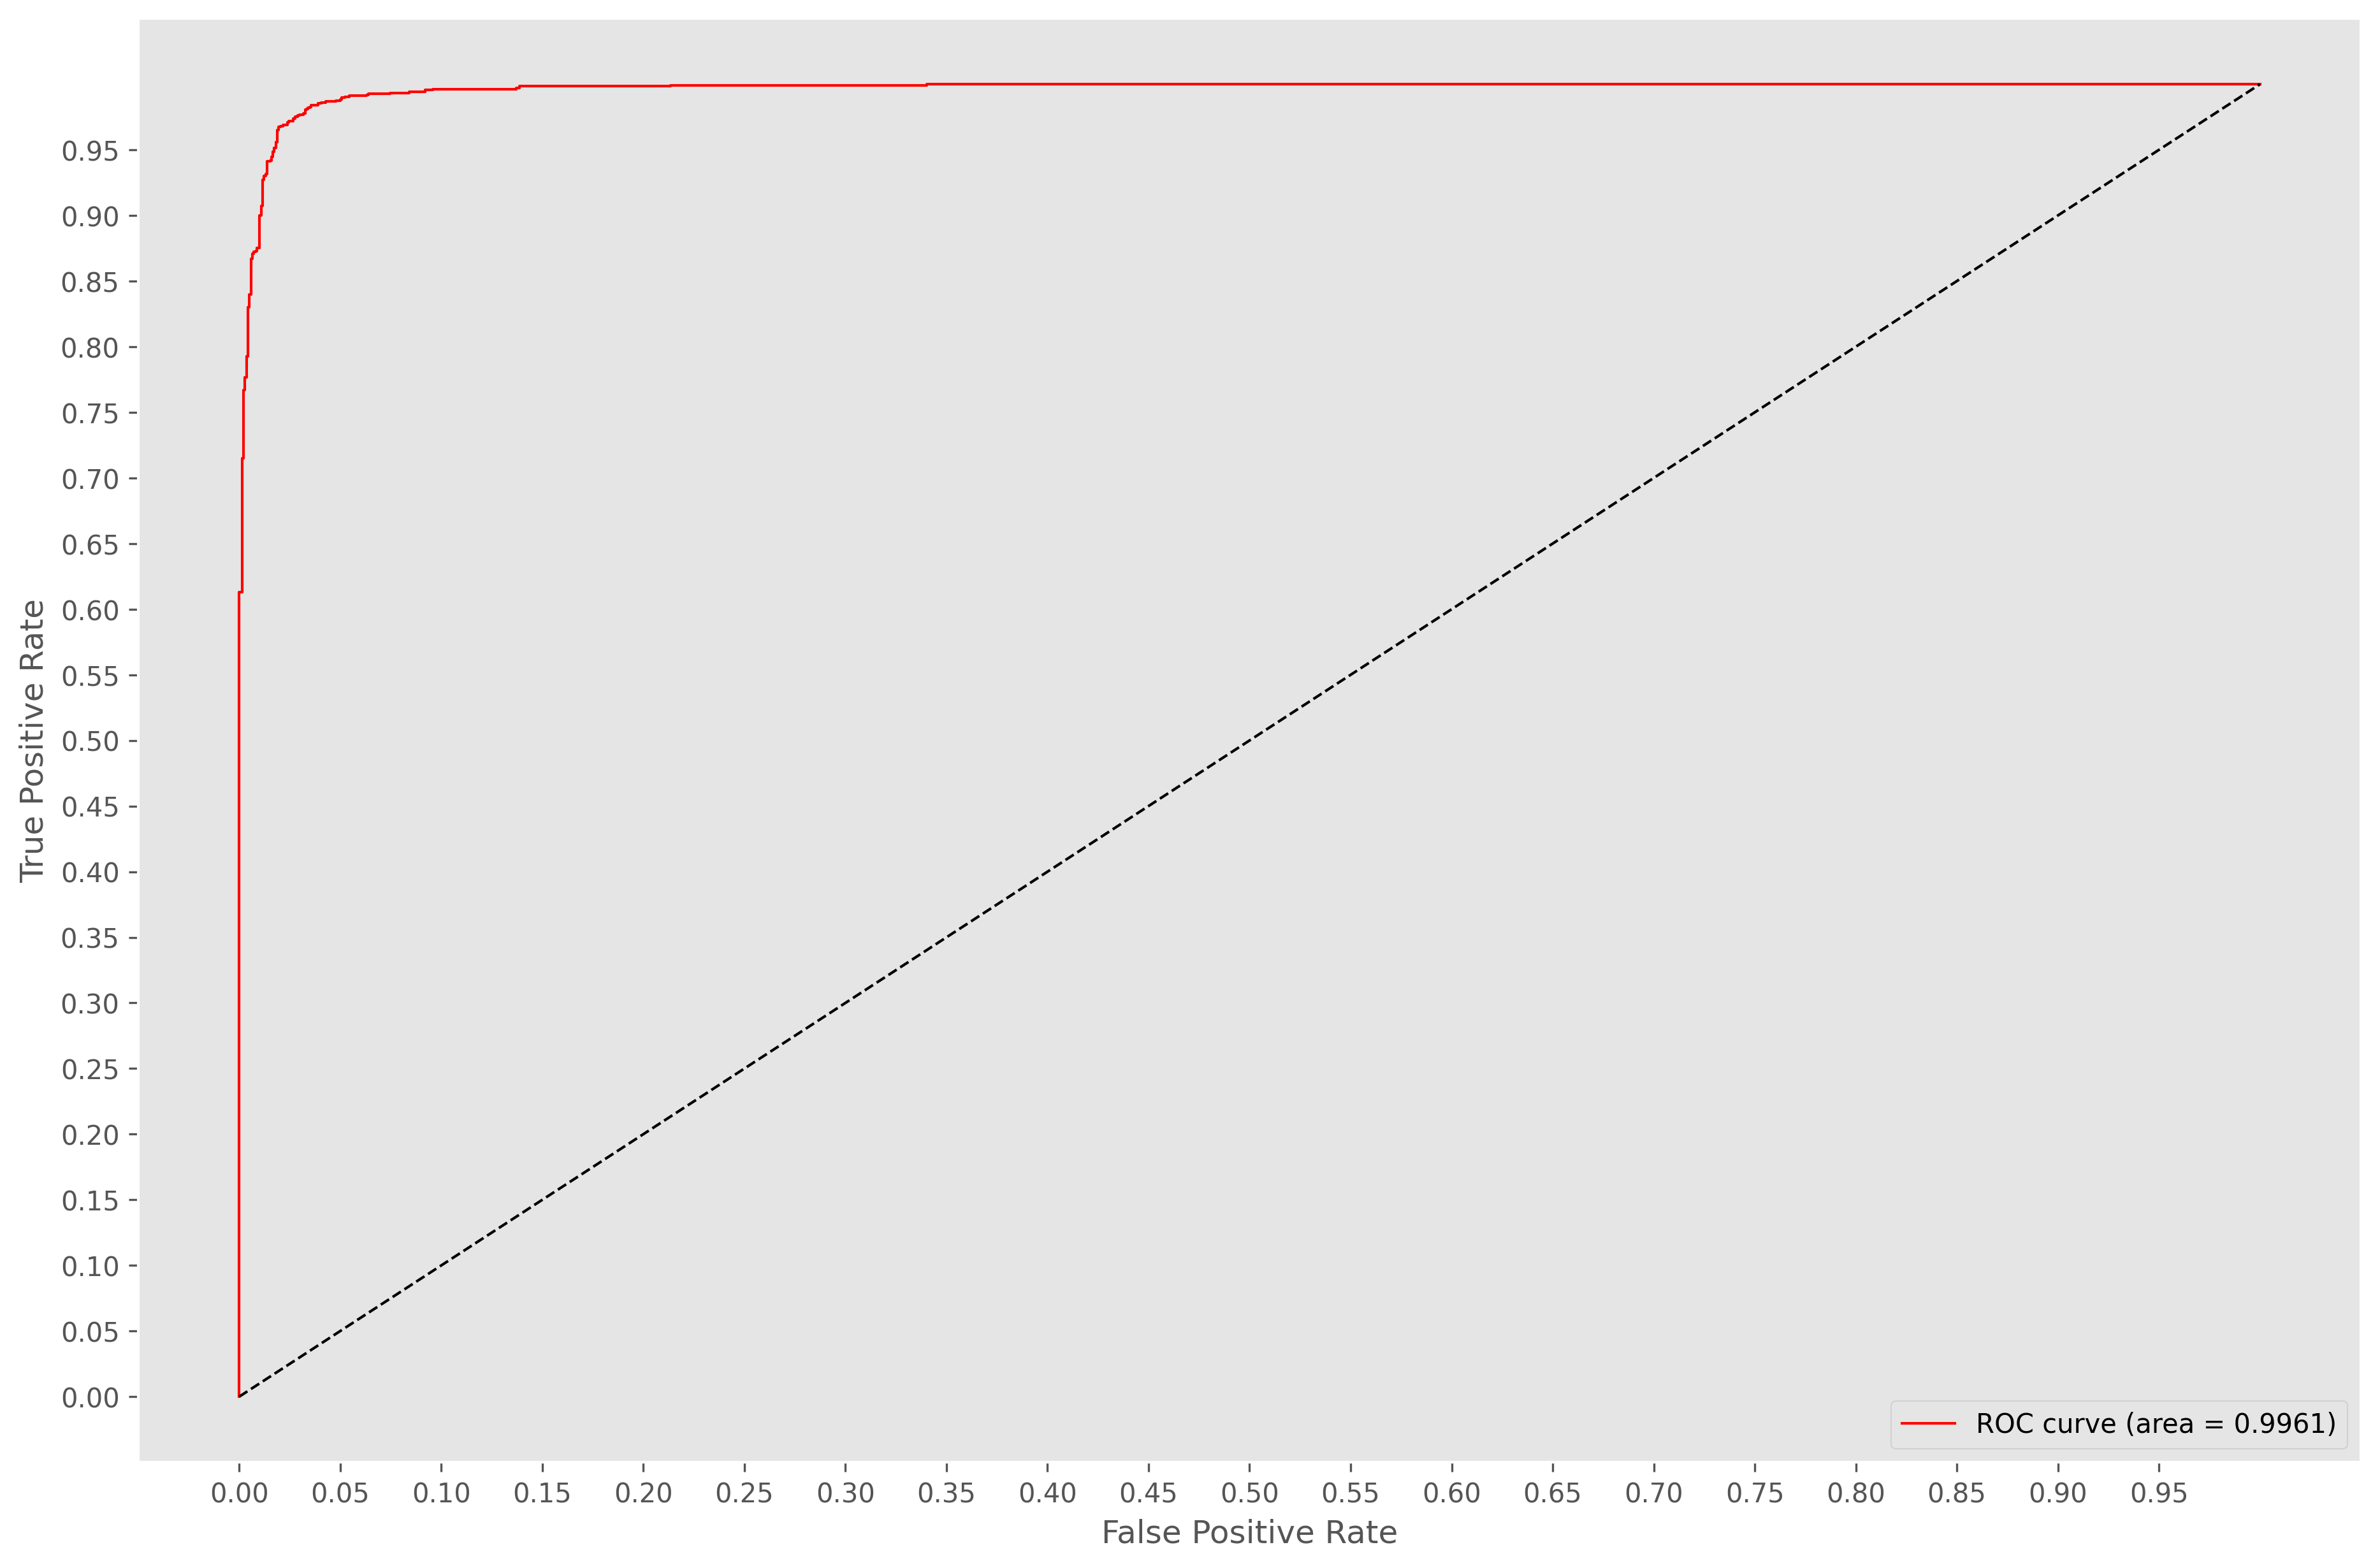

In [235]:
#%% Pair C

pair_C_ensemble_model = ensemble(pair_C, model_input)
pair_C_ensemble_model.save('weights/ensemblemodel_pairC.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
C_ensem_y_pred = pair_C_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
C_ensemble_model_accuracy = accuracy_score(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair C Ensemble model is: ', C_ensemble_model_accuracy)

#evaluate mean squared error
C_ensemble_model_custom_mse = mean_squared_error(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_mse)

#evaluate mean squared log error
C_ensemble_model_custom_msle = mean_squared_log_error(Y_test,C_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,C_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,C_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, C_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_33')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_34')>]
The Ensemble Model is Saved
The accuracy of the Pair D_ Ensemble model is:  0.9716981132075472
The Mean Squared Error of the Pair D_ Ensemble model is:  0.02830188679245283
The Mean Squared Log Error of the Pair D_ Ensemble model is:  0.013597726809005698
                   precision    recall  f1-score   support

class 0(abnormal)     0.9745    0.9688    0.9716      1378
  class 1(normal)     0.9690    0.9746    0.9718      1378

         accuracy                         0.9717      2756
        macro avg     0.9717    0.9717    0.9717      2756
     weighted avg     0.9717    0.9717    0.9717      2756

Confusion matrix, without normalization
[[1335   43]
 [  35 1343]]


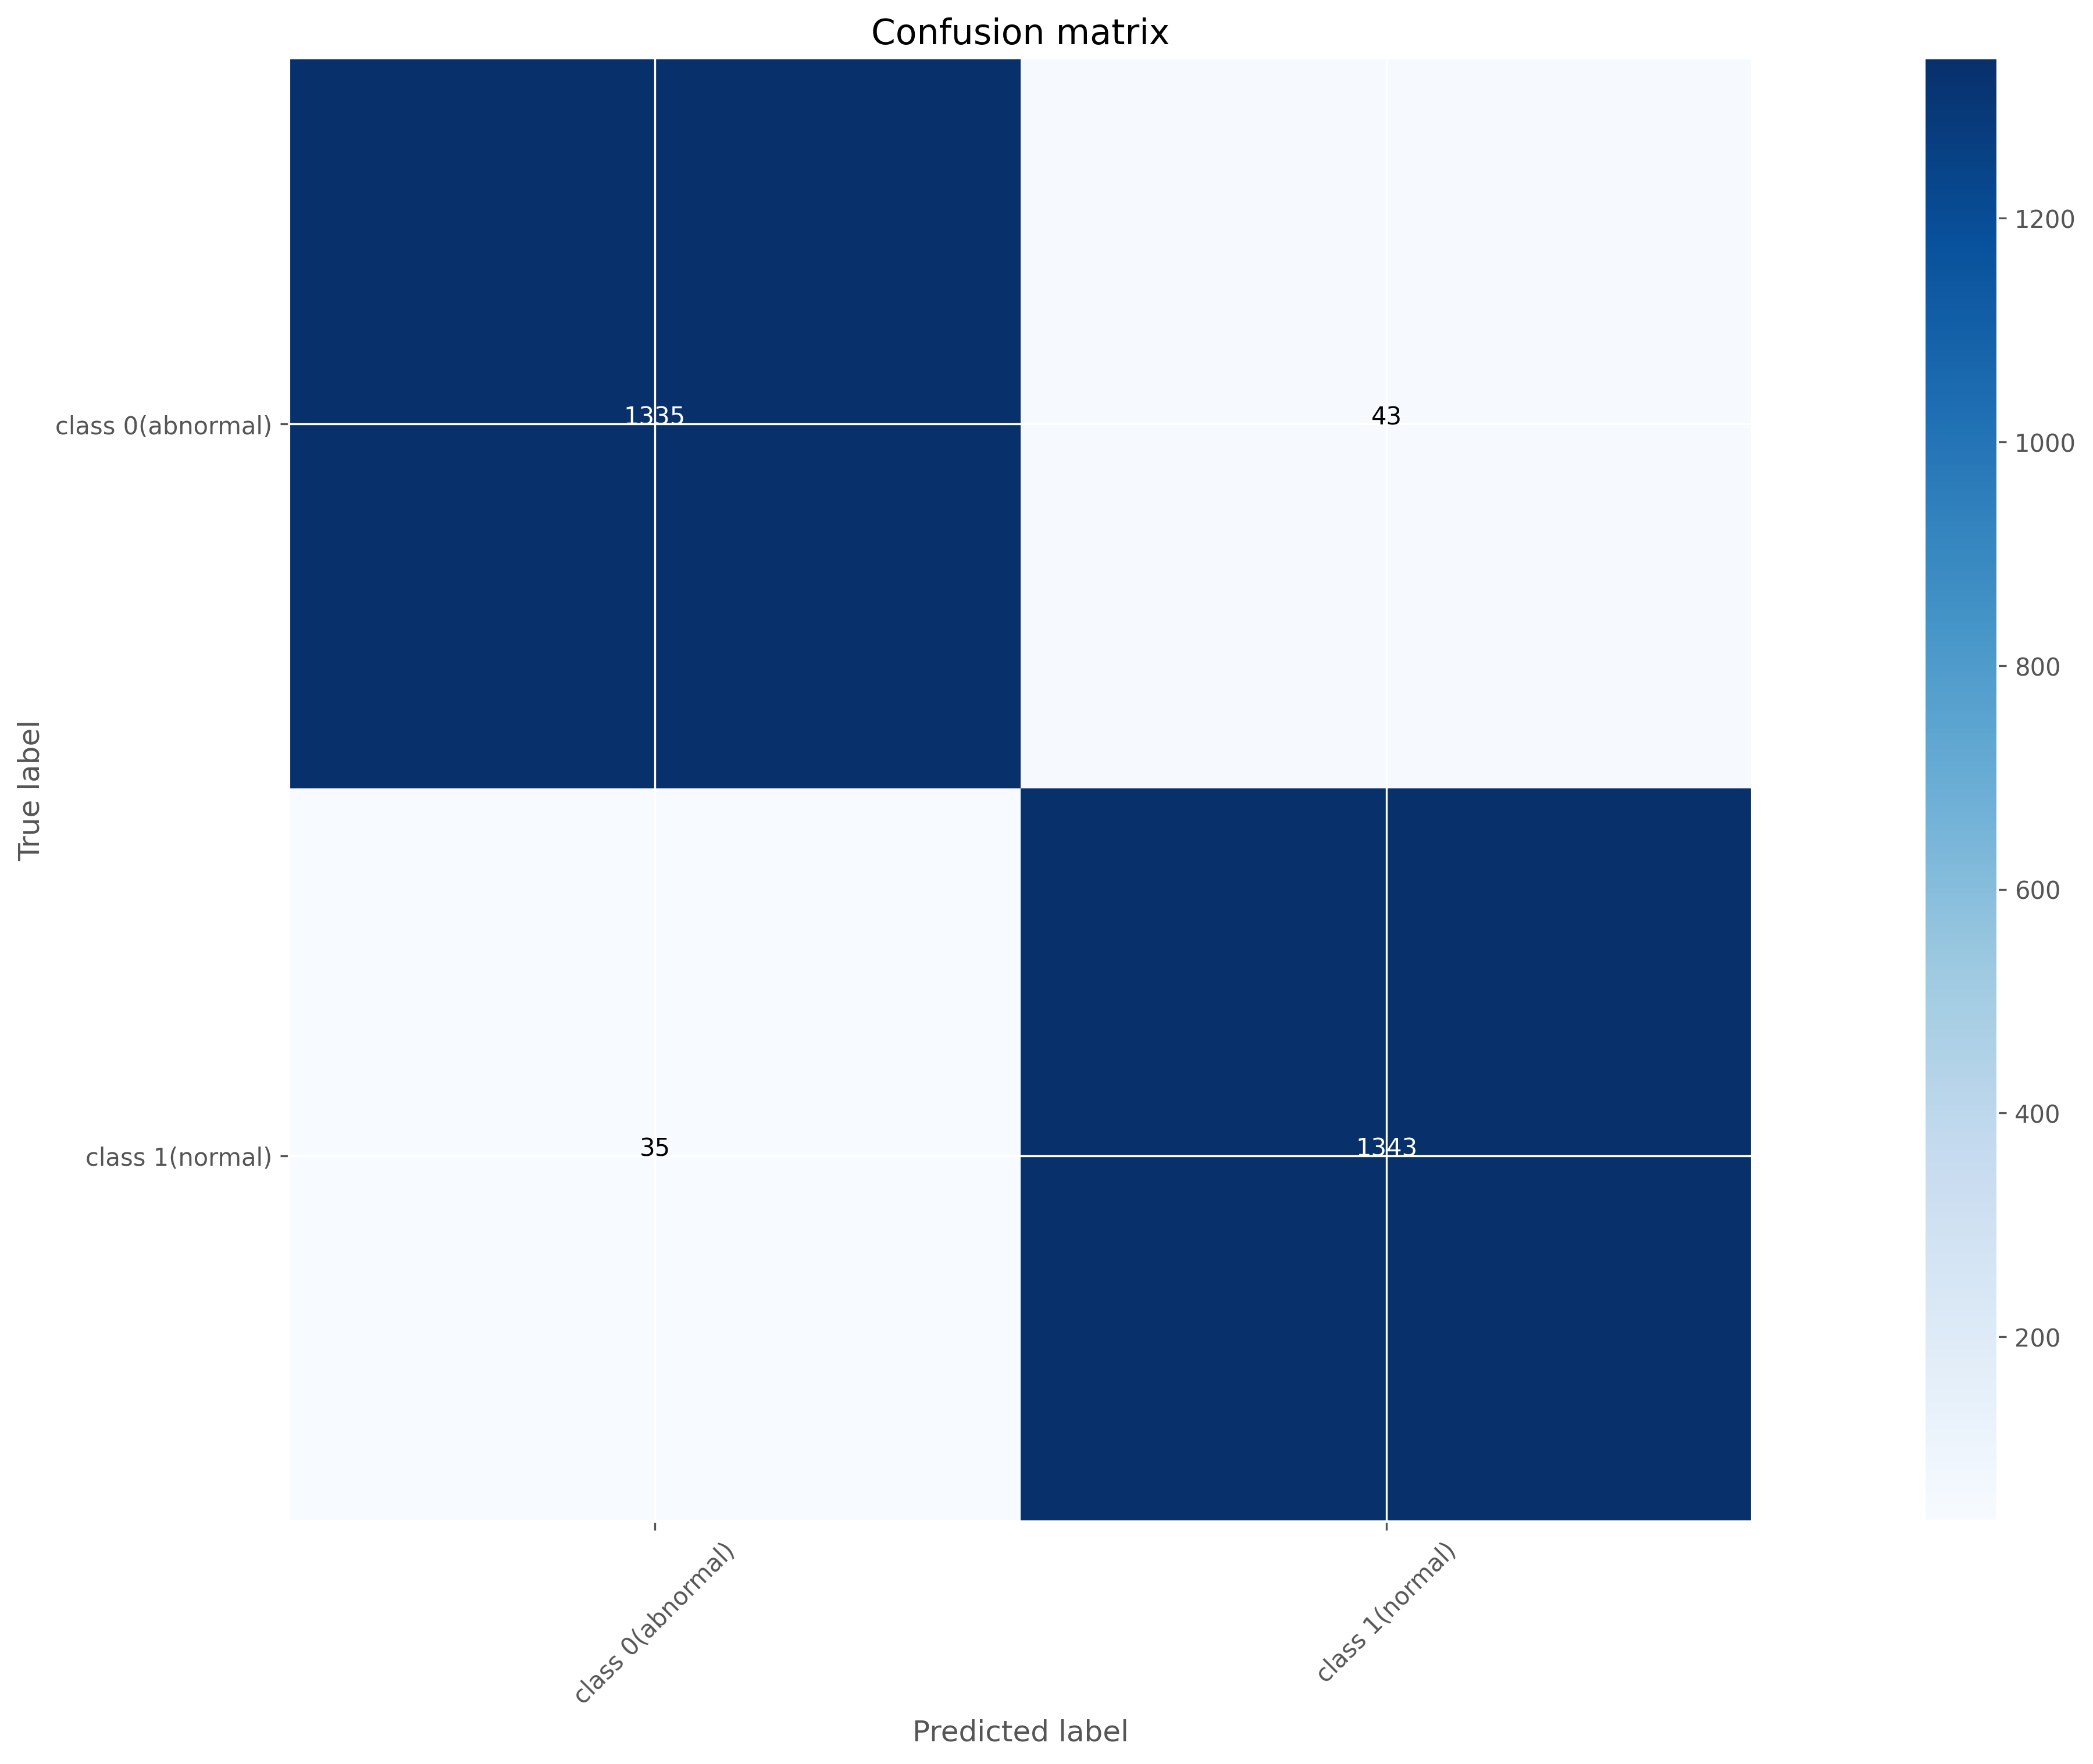

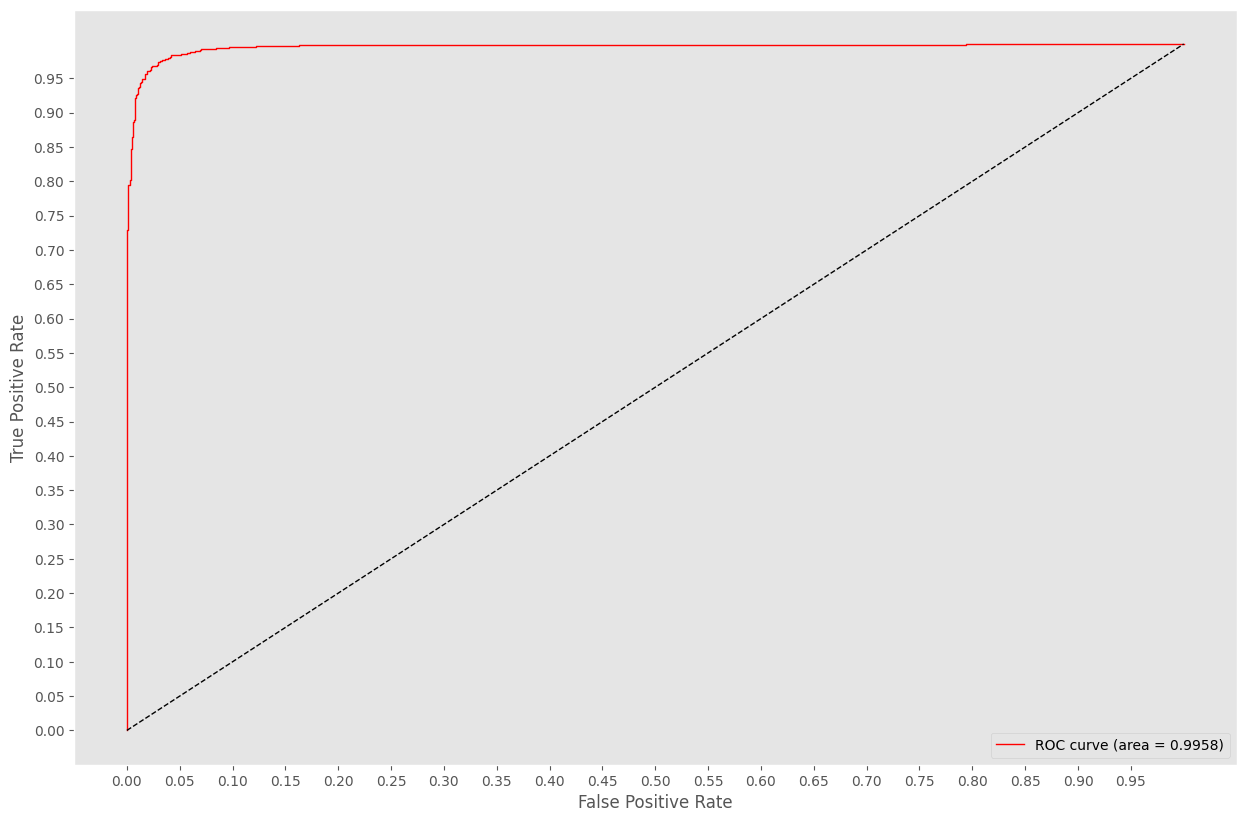

In [236]:
#%% Pair D

pair_D_ensemble_model = ensemble(pair_D, model_input)
pair_D_ensemble_model.save('weights/ensemblemodel_pairD.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
D_ensem_y_pred = pair_D_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
D_ensemble_model_accuracy = accuracy_score(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair D_ Ensemble model is: ', D_ensemble_model_accuracy)

#evaluate mean squared error
D_ensemble_model_custom_mse = mean_squared_error(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_mse)

#evaluate mean squared log error
D_ensemble_model_custom_msle = mean_squared_log_error(Y_test,D_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,D_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,D_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, D_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_33')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_35')>]
The Ensemble Model is Saved
The accuracy of the Pair E_ Ensemble model is:  0.9756894049346879
The Mean Squared Error of the Pair E Ensemble model is:  0.024310595065312045
The Mean Squared Log Error of the Pair E Ensemble model is:  0.011680098669274126
                   precision    recall  f1-score   support

class 0(abnormal)     0.9852    0.9659    0.9754      1378
  class 1(normal)     0.9665    0.9855    0.9759      1378

         accuracy                         0.9757      2756
        macro avg     0.9759    0.9757    0.9757      2756
     weighted avg     0.9759    0.9757    0.9757      2756

Confusion matrix, without normalization
[[1331   47]
 [  20 1358]]


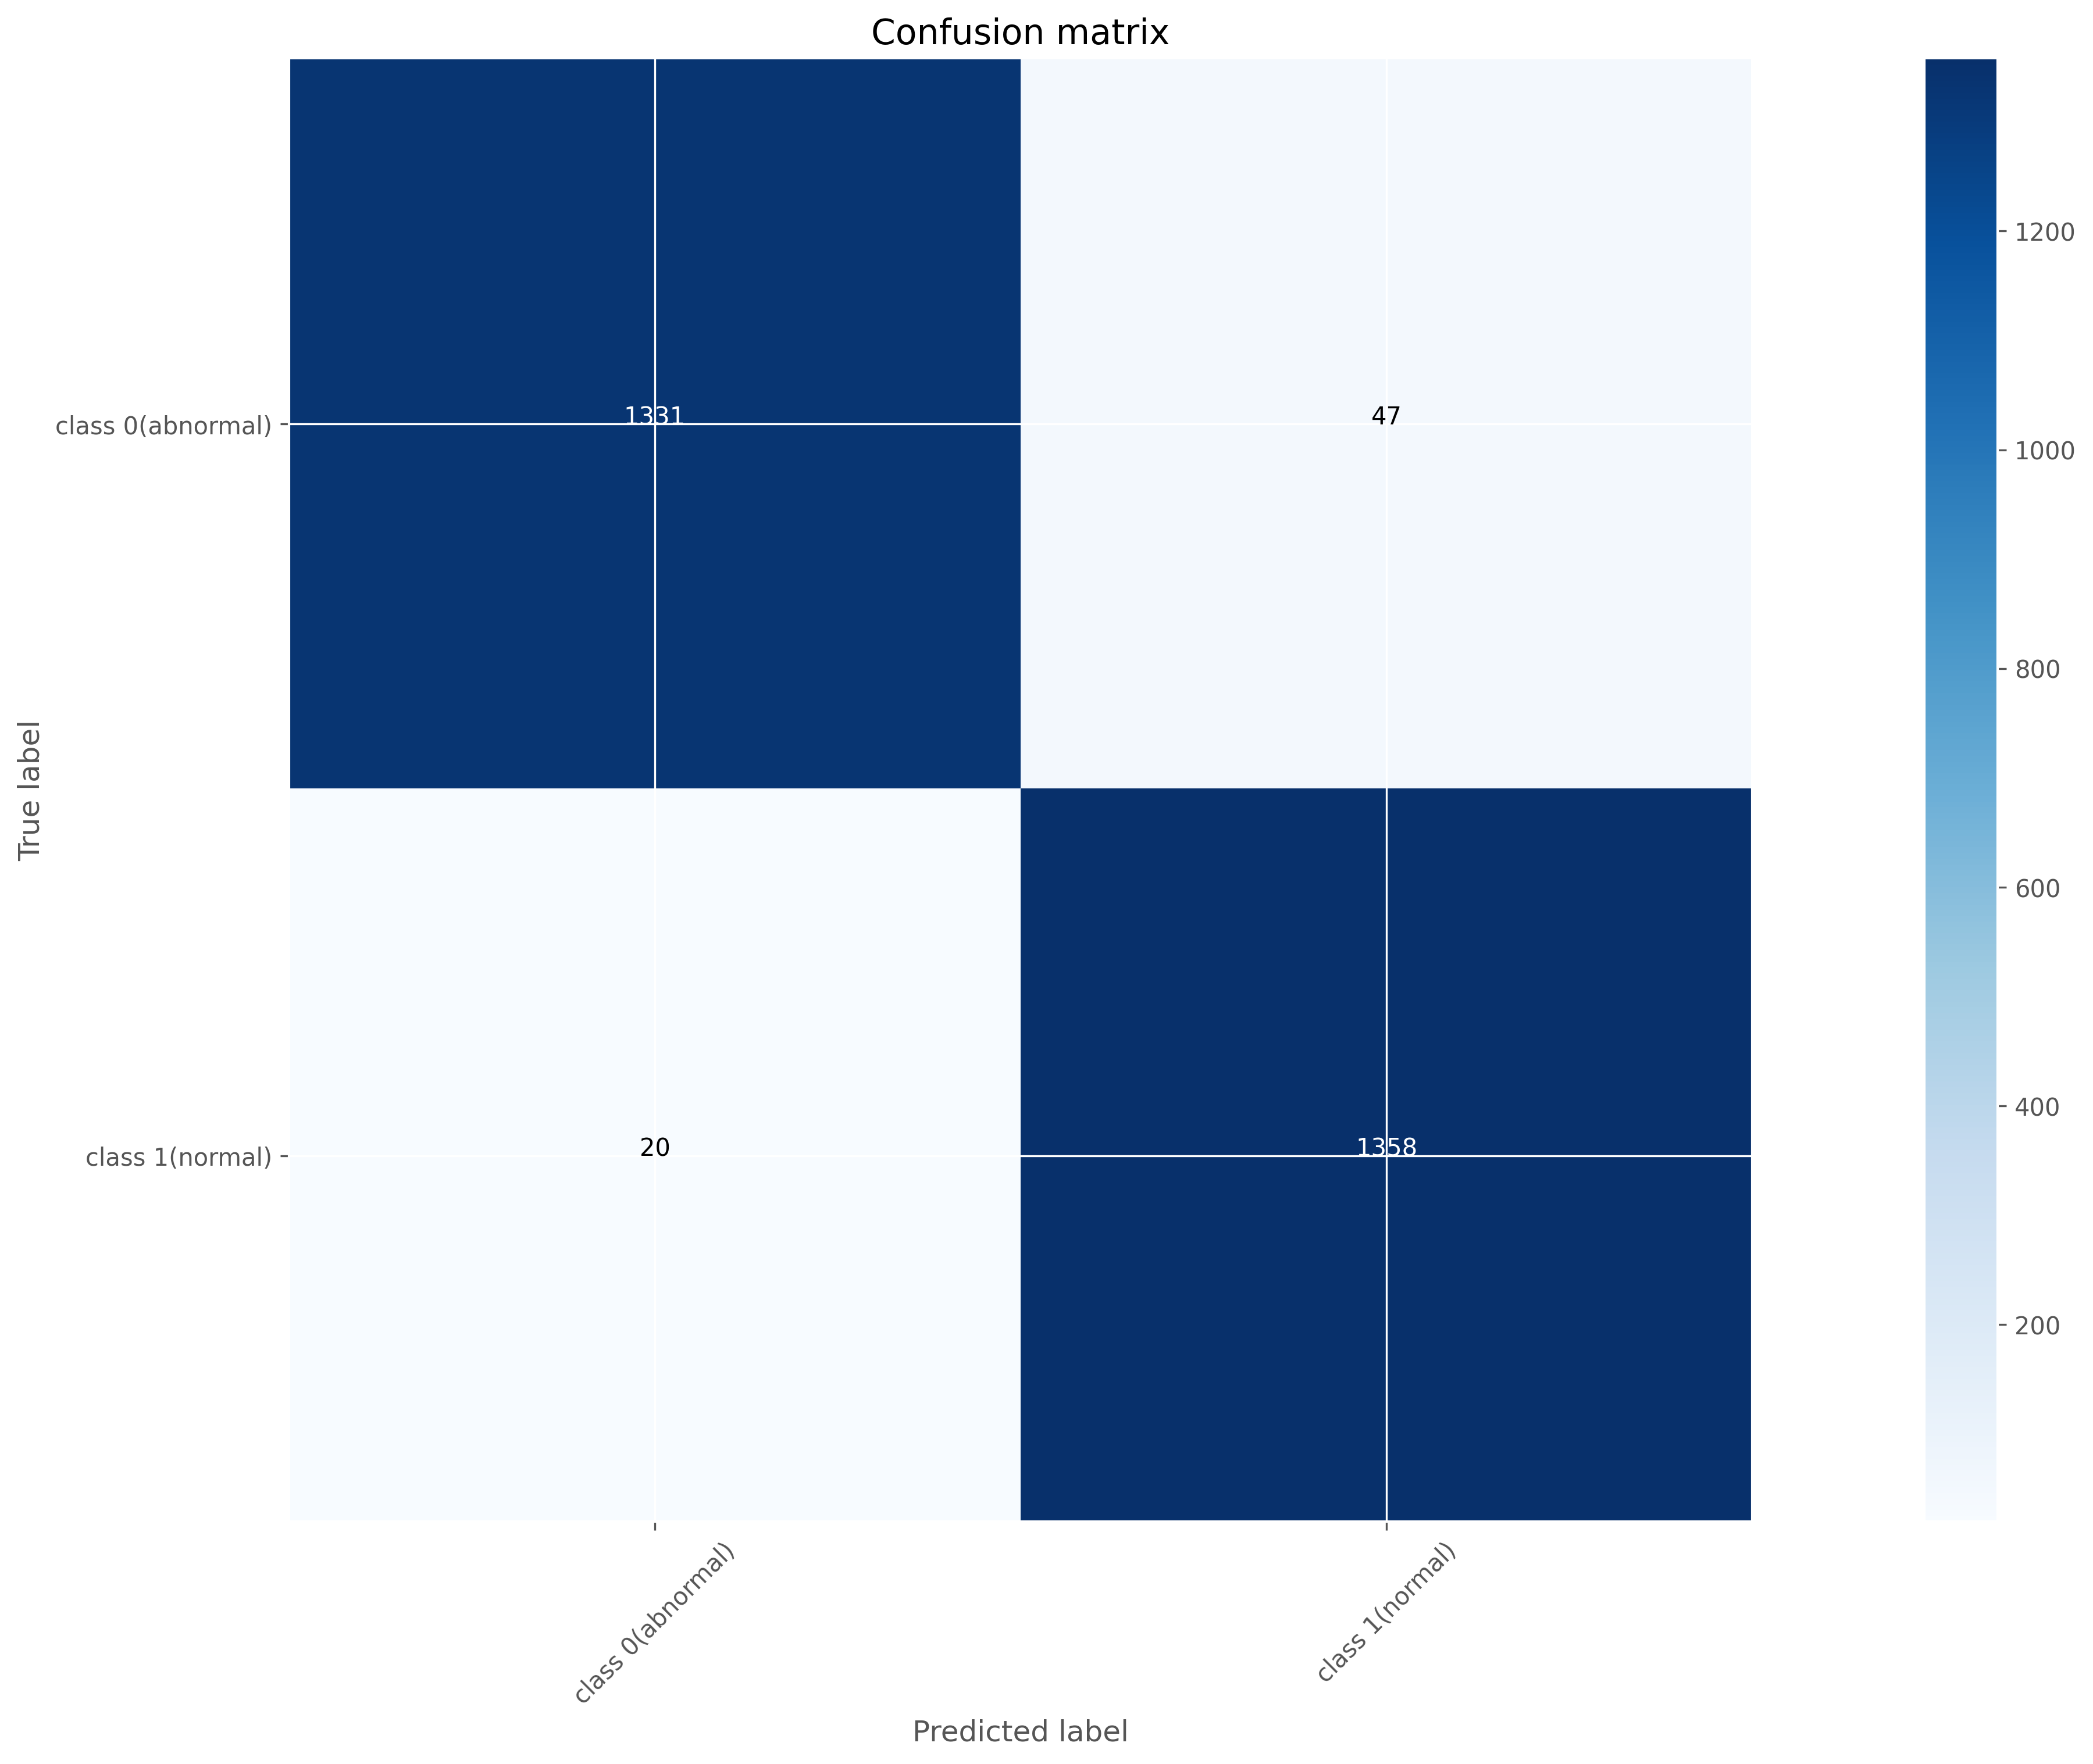

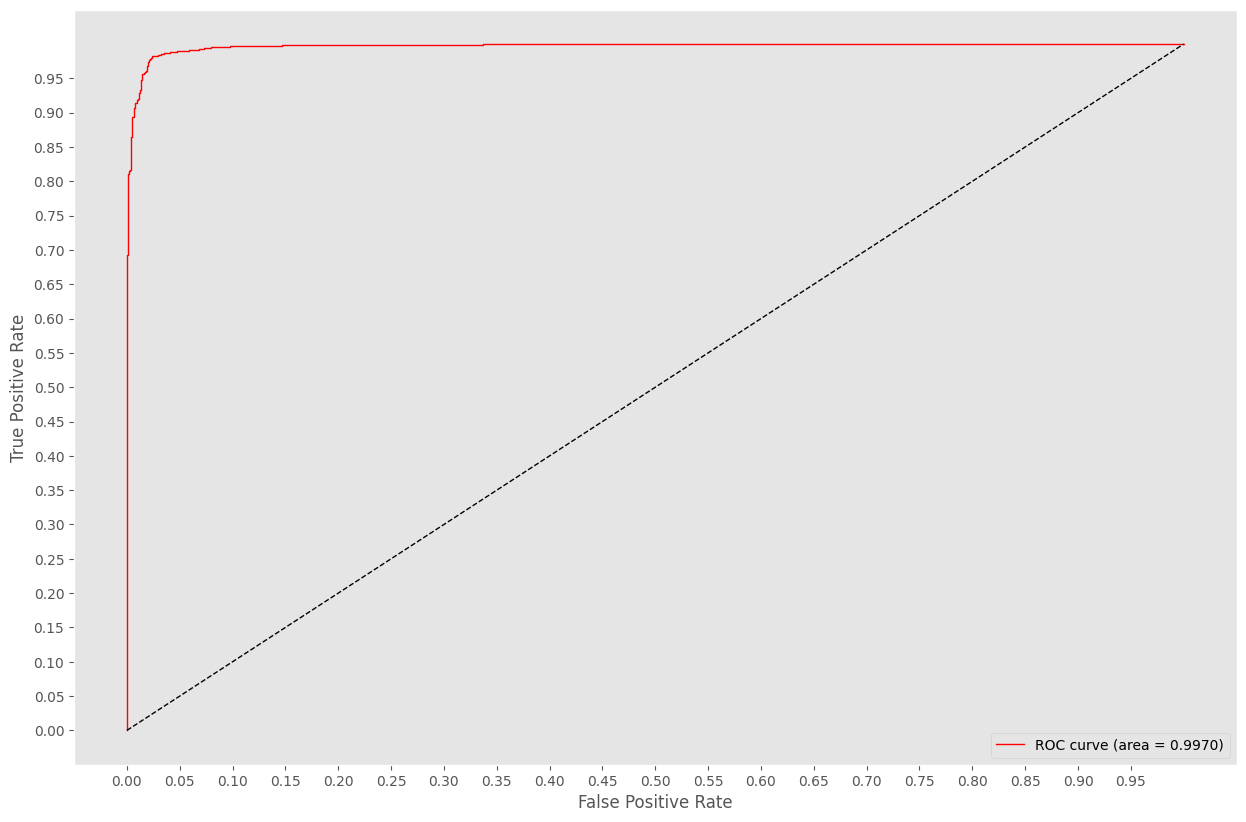

In [237]:
 #%% Pair E

pair_E_ensemble_model = ensemble(pair_E, model_input)
pair_E_ensemble_model.save('weights/ensemblemodel_pairE.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
E_ensem_y_pred = pair_E_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
E_ensemble_model_accuracy = accuracy_score(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair E_ Ensemble model is: ', E_ensemble_model_accuracy)

#evaluate mean squared error
E_ensemble_model_custom_mse = mean_squared_error(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_mse)

#evaluate mean squared log error
E_ensemble_model_custom_msle = mean_squared_log_error(Y_test,E_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,E_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, E_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_34')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_35')>]
The Ensemble Model is Saved
The accuracy of the Pair F_ Ensemble model is:  0.9738751814223512
The Mean Squared Error of the Pair F_ Ensemble model is:  0.026124818577648767
The Mean Squared Log Error of the Pair F_Ensemble model is:  0.012551747823697569
                   precision    recall  f1-score   support

class 0(abnormal)     0.9823    0.9652    0.9736      1378
  class 1(normal)     0.9658    0.9826    0.9741      1378

         accuracy                         0.9739      2756
        macro avg     0.9740    0.9739    0.9739      2756
     weighted avg     0.9740    0.9739    0.9739      2756

Confusion matrix, without normalization
[[1330   48]
 [  24 1354]]


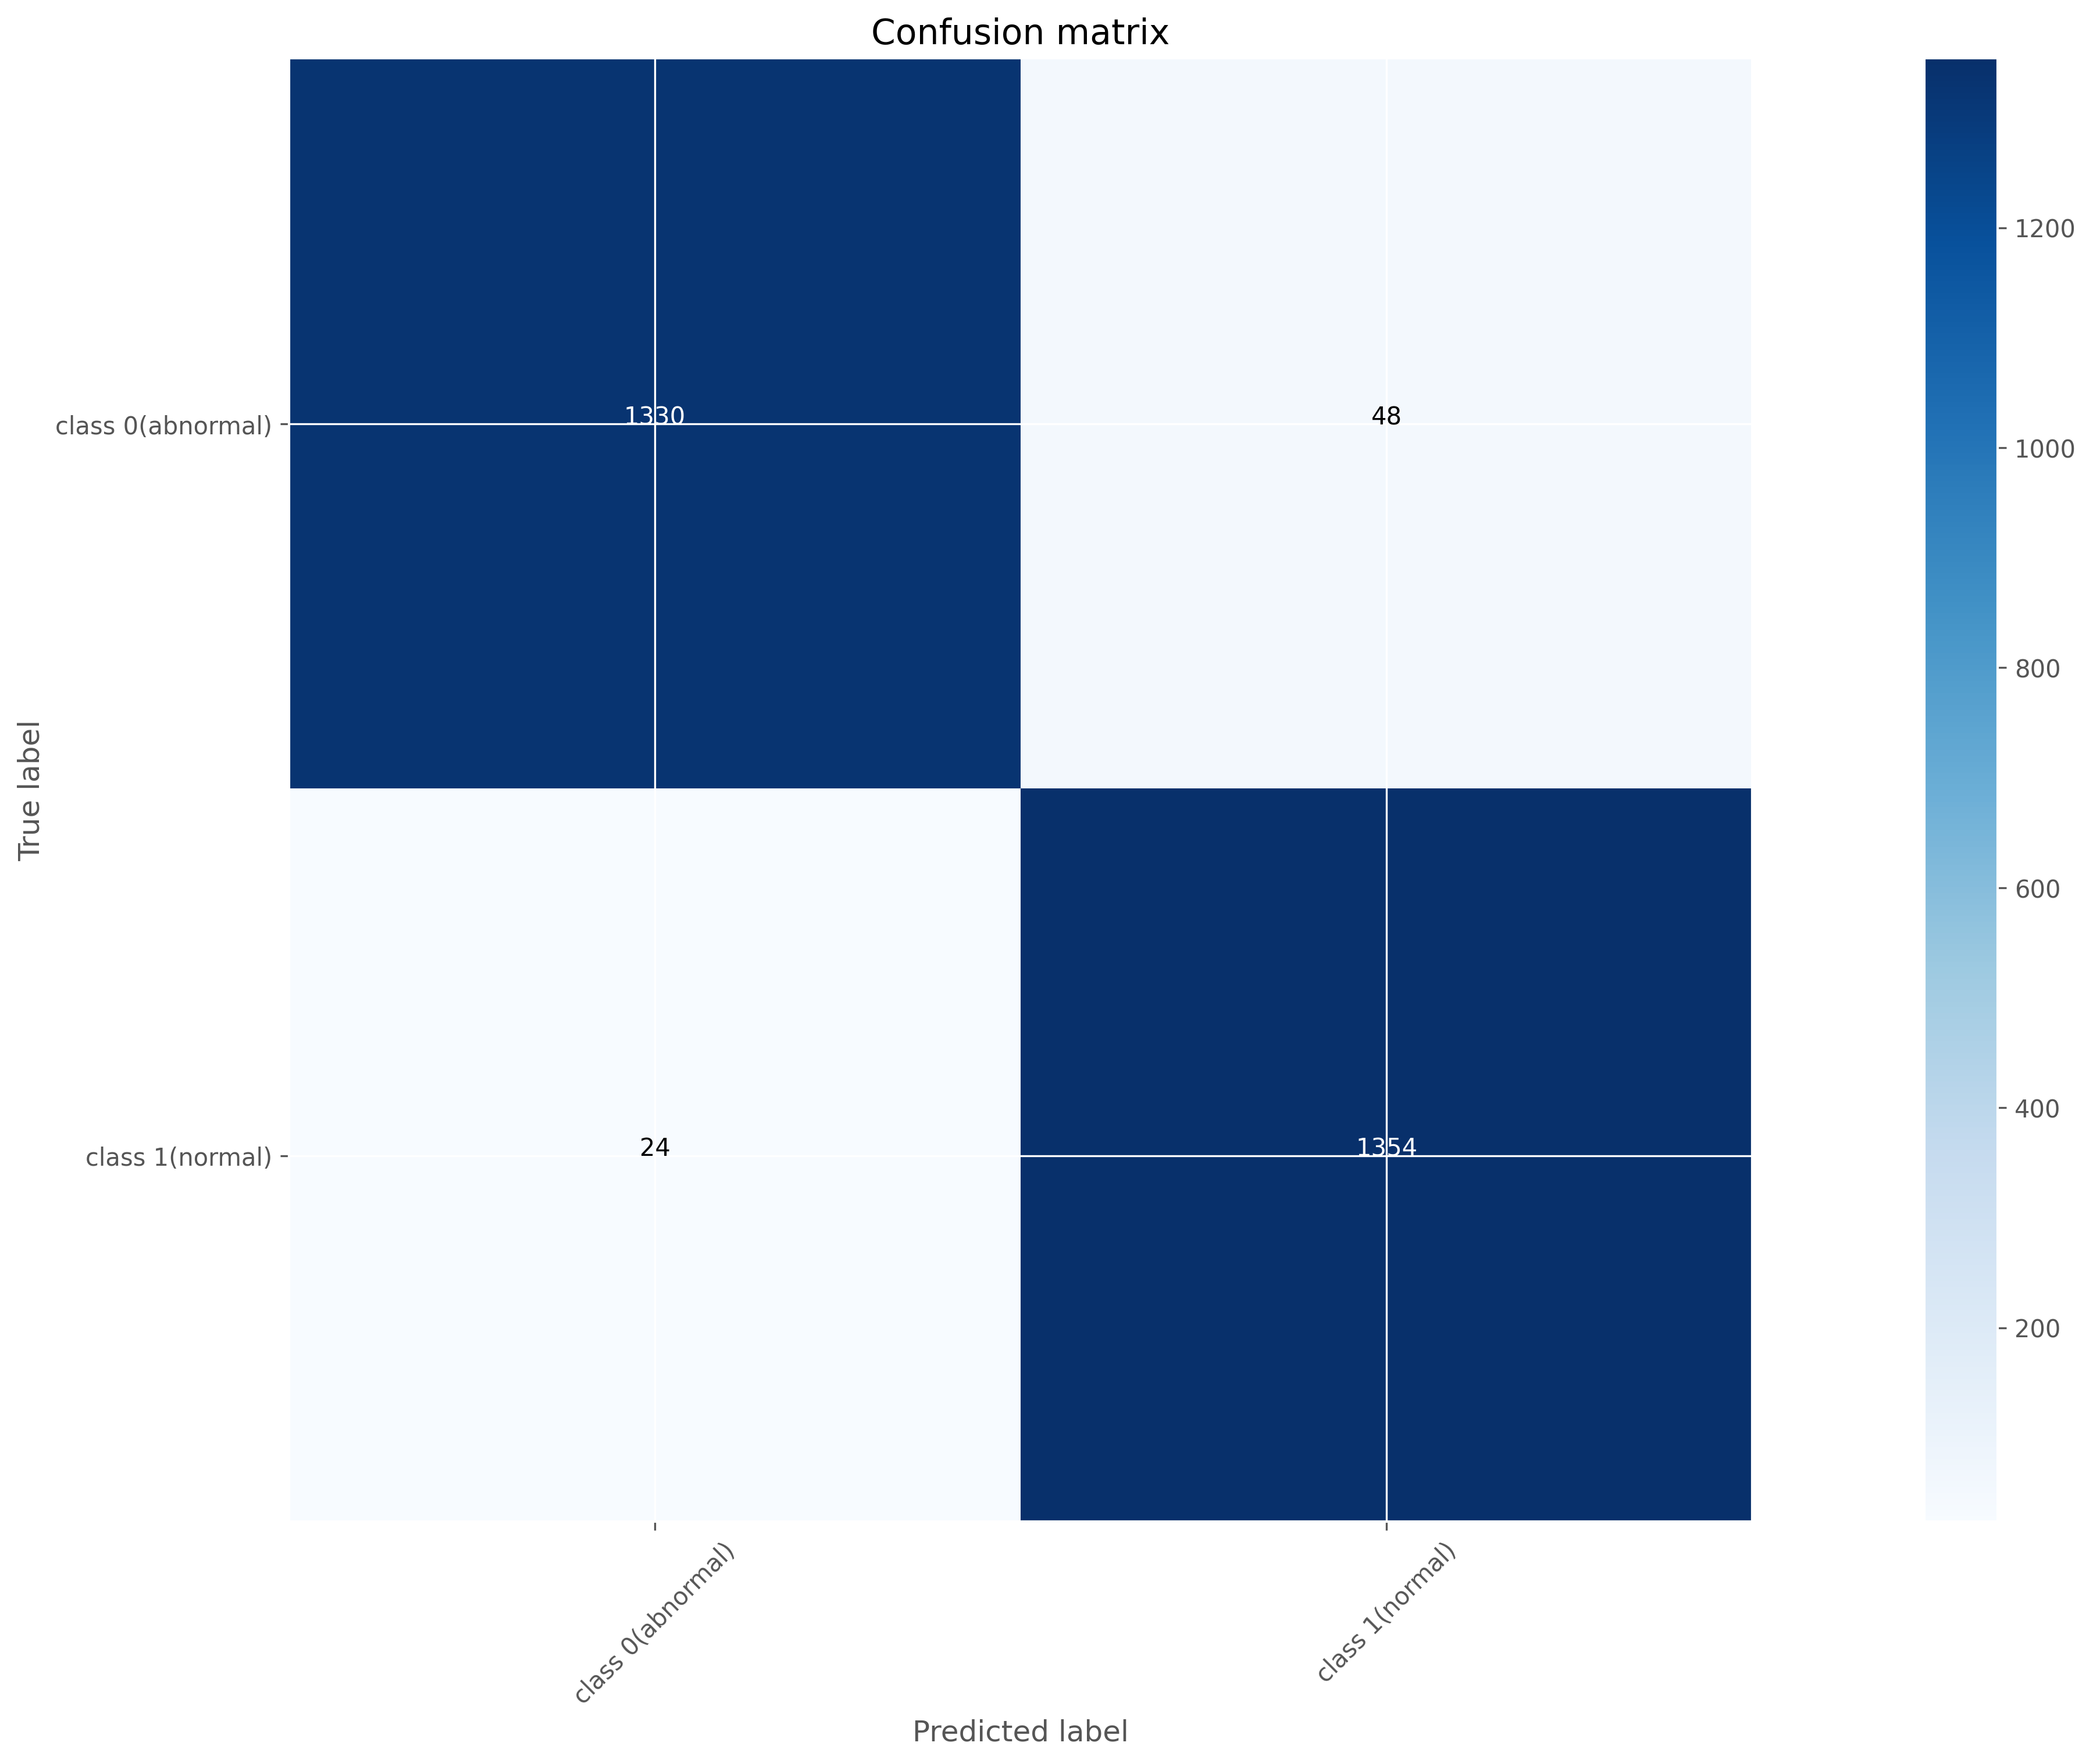

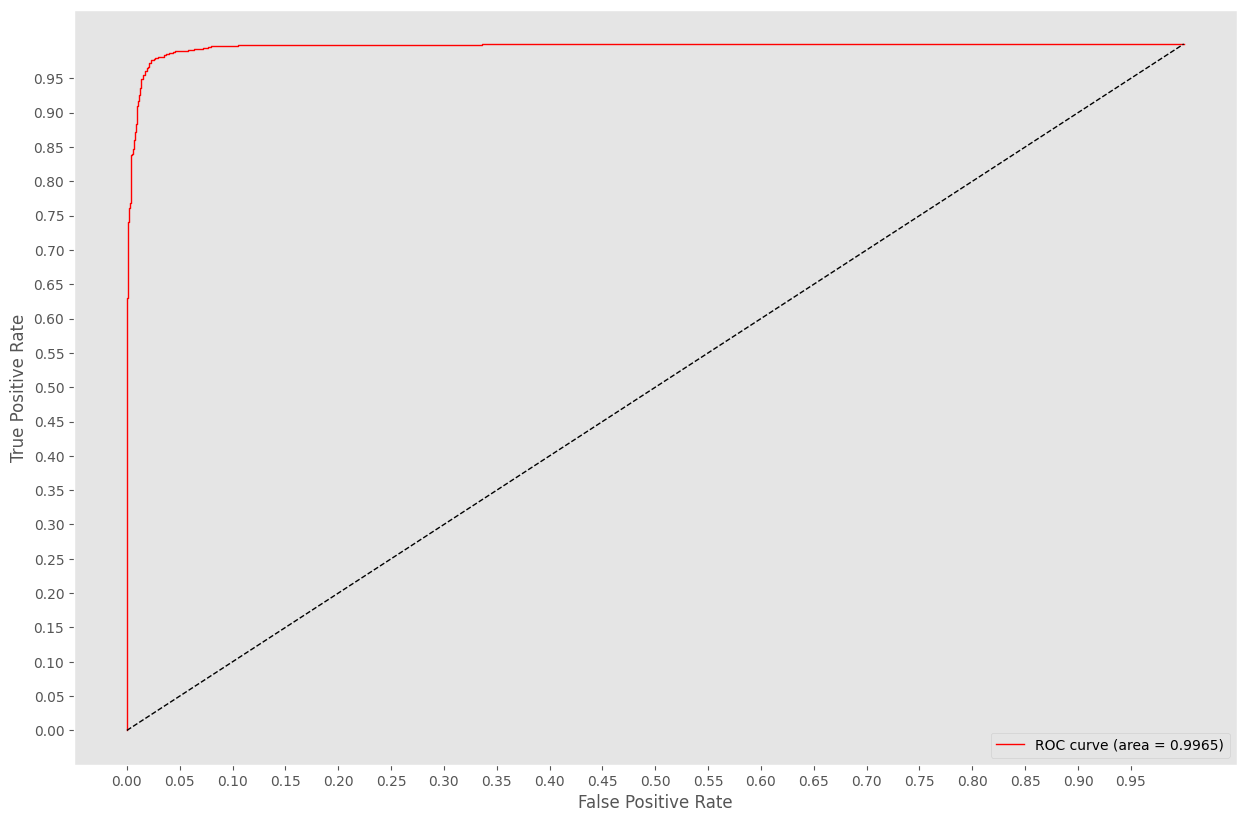

In [238]:
 #%% Pair F

pair_F_ensemble_model = ensemble(pair_F, model_input)
pair_F_ensemble_model.save('weights/ensemblemodel_pairF.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
F_ensem_y_pred = pair_F_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
F_ensemble_model_accuracy = accuracy_score(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair F_ Ensemble model is: ', F_ensemble_model_accuracy)

#evaluate mean squared error
F_ensemble_model_custom_mse = mean_squared_error(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair F_ Ensemble model is: ', F_ensemble_model_custom_mse)

#evaluate mean squared log error
F_ensemble_model_custom_msle = mean_squared_log_error(Y_test,F_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair F_Ensemble model is: ', F_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,F_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,F_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, F_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_33')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_34')>]
The Ensemble Model is Saved
The accuracy of the Pair G_ Ensemble model is:  0.9698838896952104
The Mean Squared Error of the Pair G_ Ensemble model is:  0.03011611030478955
The Mean Squared Log Error of the Pair G_ Ensemble model is:  0.014469375963429142
                   precision    recall  f1-score   support

class 0(abnormal)     0.9852    0.9659    0.9754      1378
  class 1(normal)     0.9665    0.9855    0.9759      1378

         accuracy                         0.9757      2756
        macro avg     0.9759    0.9757    0.9757      2756
     weighted avg     0.9759    0.9757    0.9757      2756

Confusion matrix, without normalization
[[1325   53]
 [  30 1348]]


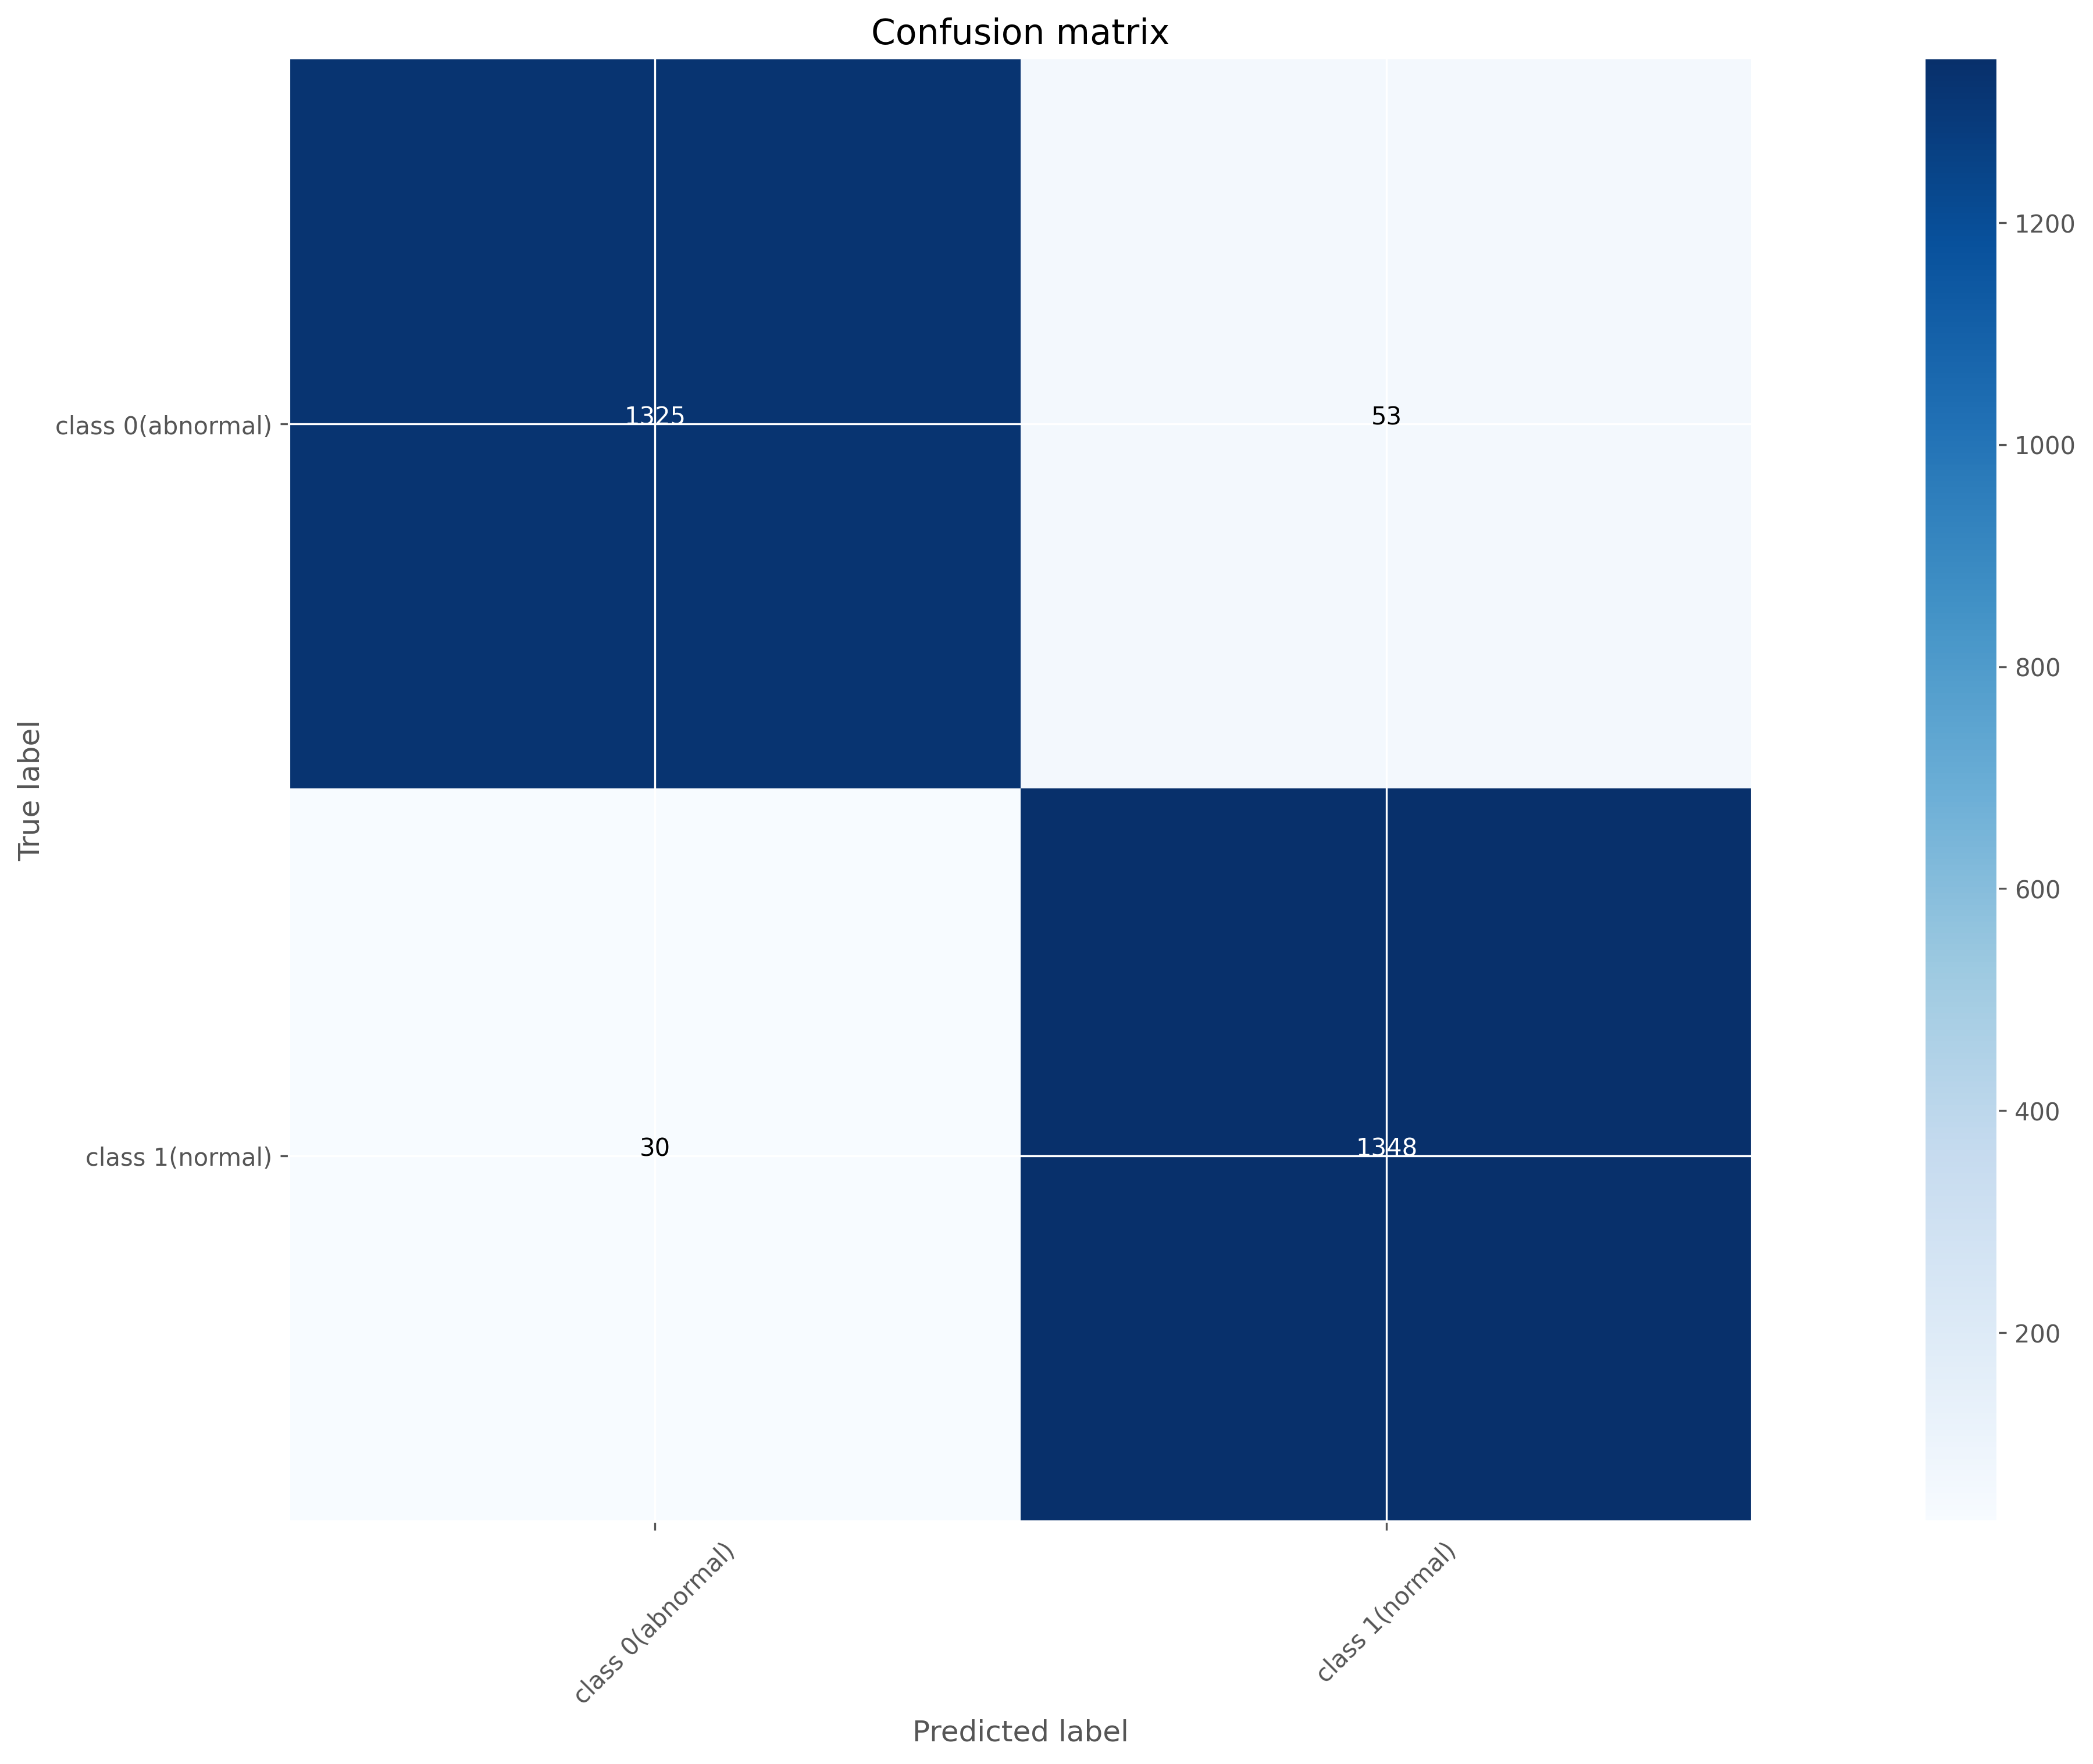

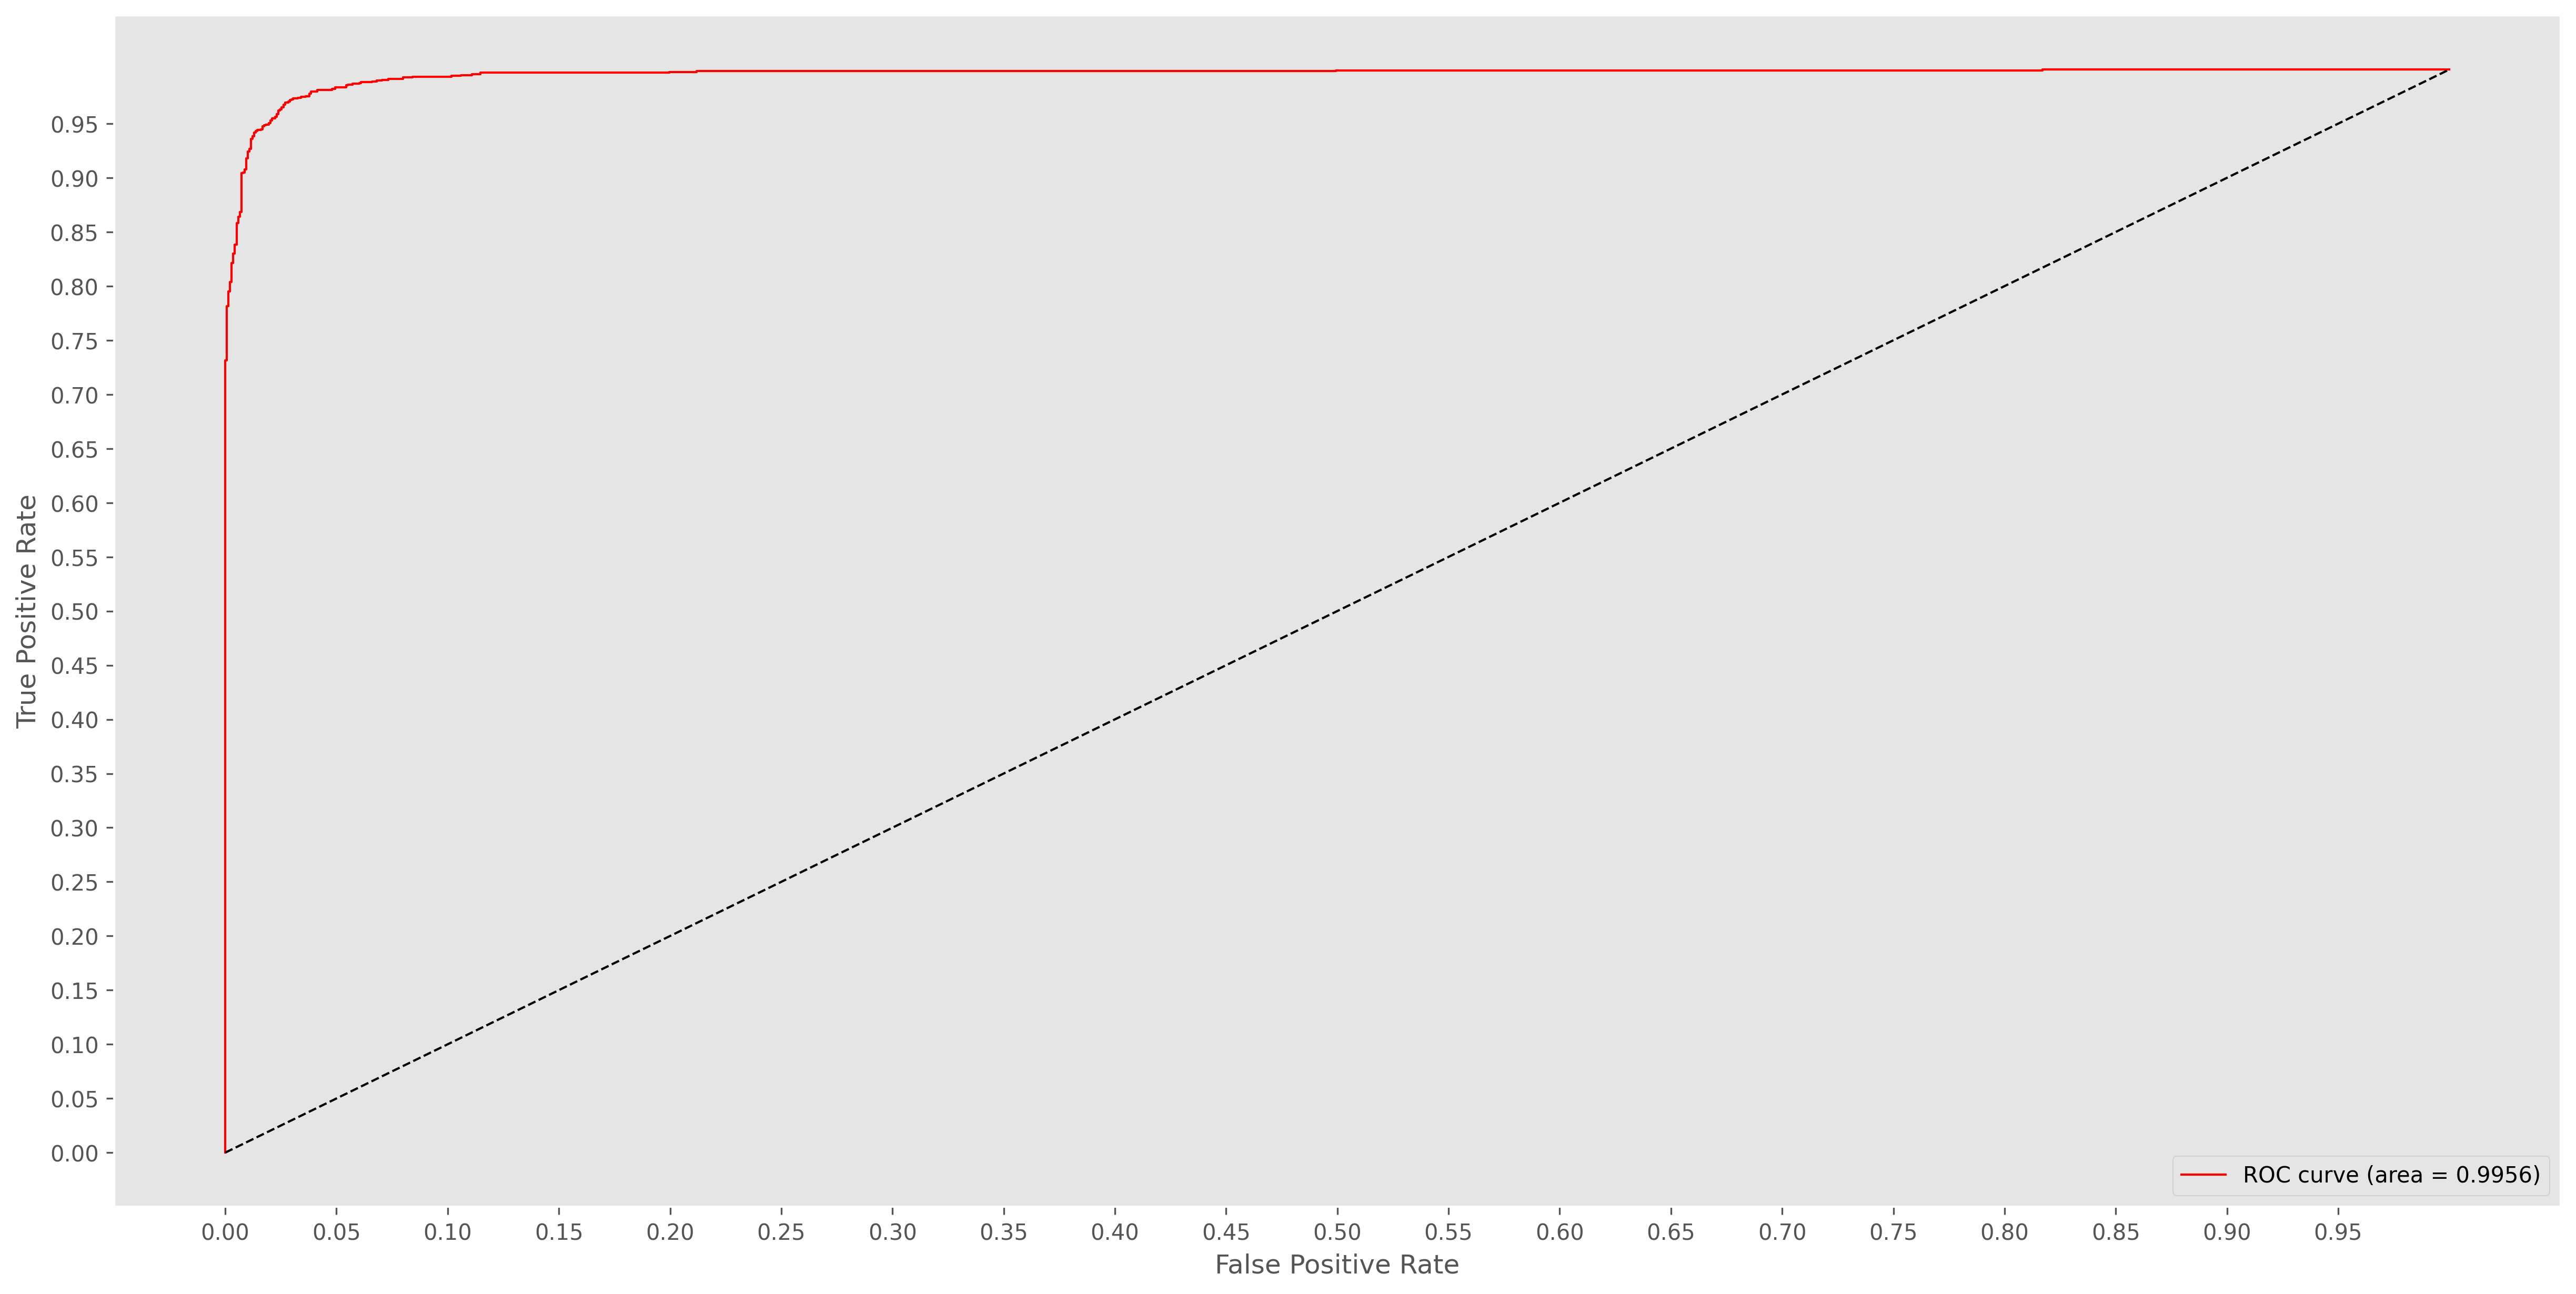

In [239]:
 #%% Pair G

pair_G_ensemble_model = ensemble(pair_G, model_input)
pair_G_ensemble_model.save('weights/ensemblemodel_pairG.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
G_ensem_y_pred = pair_G_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
G_ensemble_model_accuracy = accuracy_score(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair G_ Ensemble model is: ', G_ensemble_model_accuracy)

#evaluate mean squared error
G_ensemble_model_custom_mse = mean_squared_error(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_mse)

#evaluate mean squared log error
G_ensemble_model_custom_msle = mean_squared_log_error(Y_test,G_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,G_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, G_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_33')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_35')>]
The Ensemble Model is Saved
The accuracy of the Pair H_ Ensemble model is:  0.9724238026124818
The Mean Squared Error of the Pair H_ Ensemble model is:  0.027576197387518143
The Mean Squared Log Error of the Pair H_ Ensemble model is:  0.013249067147236322
                   precision    recall  f1-score   support

class 0(abnormal)     0.9852    0.9659    0.9754      1378
  class 1(normal)     0.9665    0.9855    0.9759      1378

         accuracy                         0.9757      2756
        macro avg     0.9759    0.9757    0.9757      2756
     weighted avg     0.9759    0.9757    0.9757      2756

Confusion matrix, without normalization
[[1327   51]
 [  25 1353]]


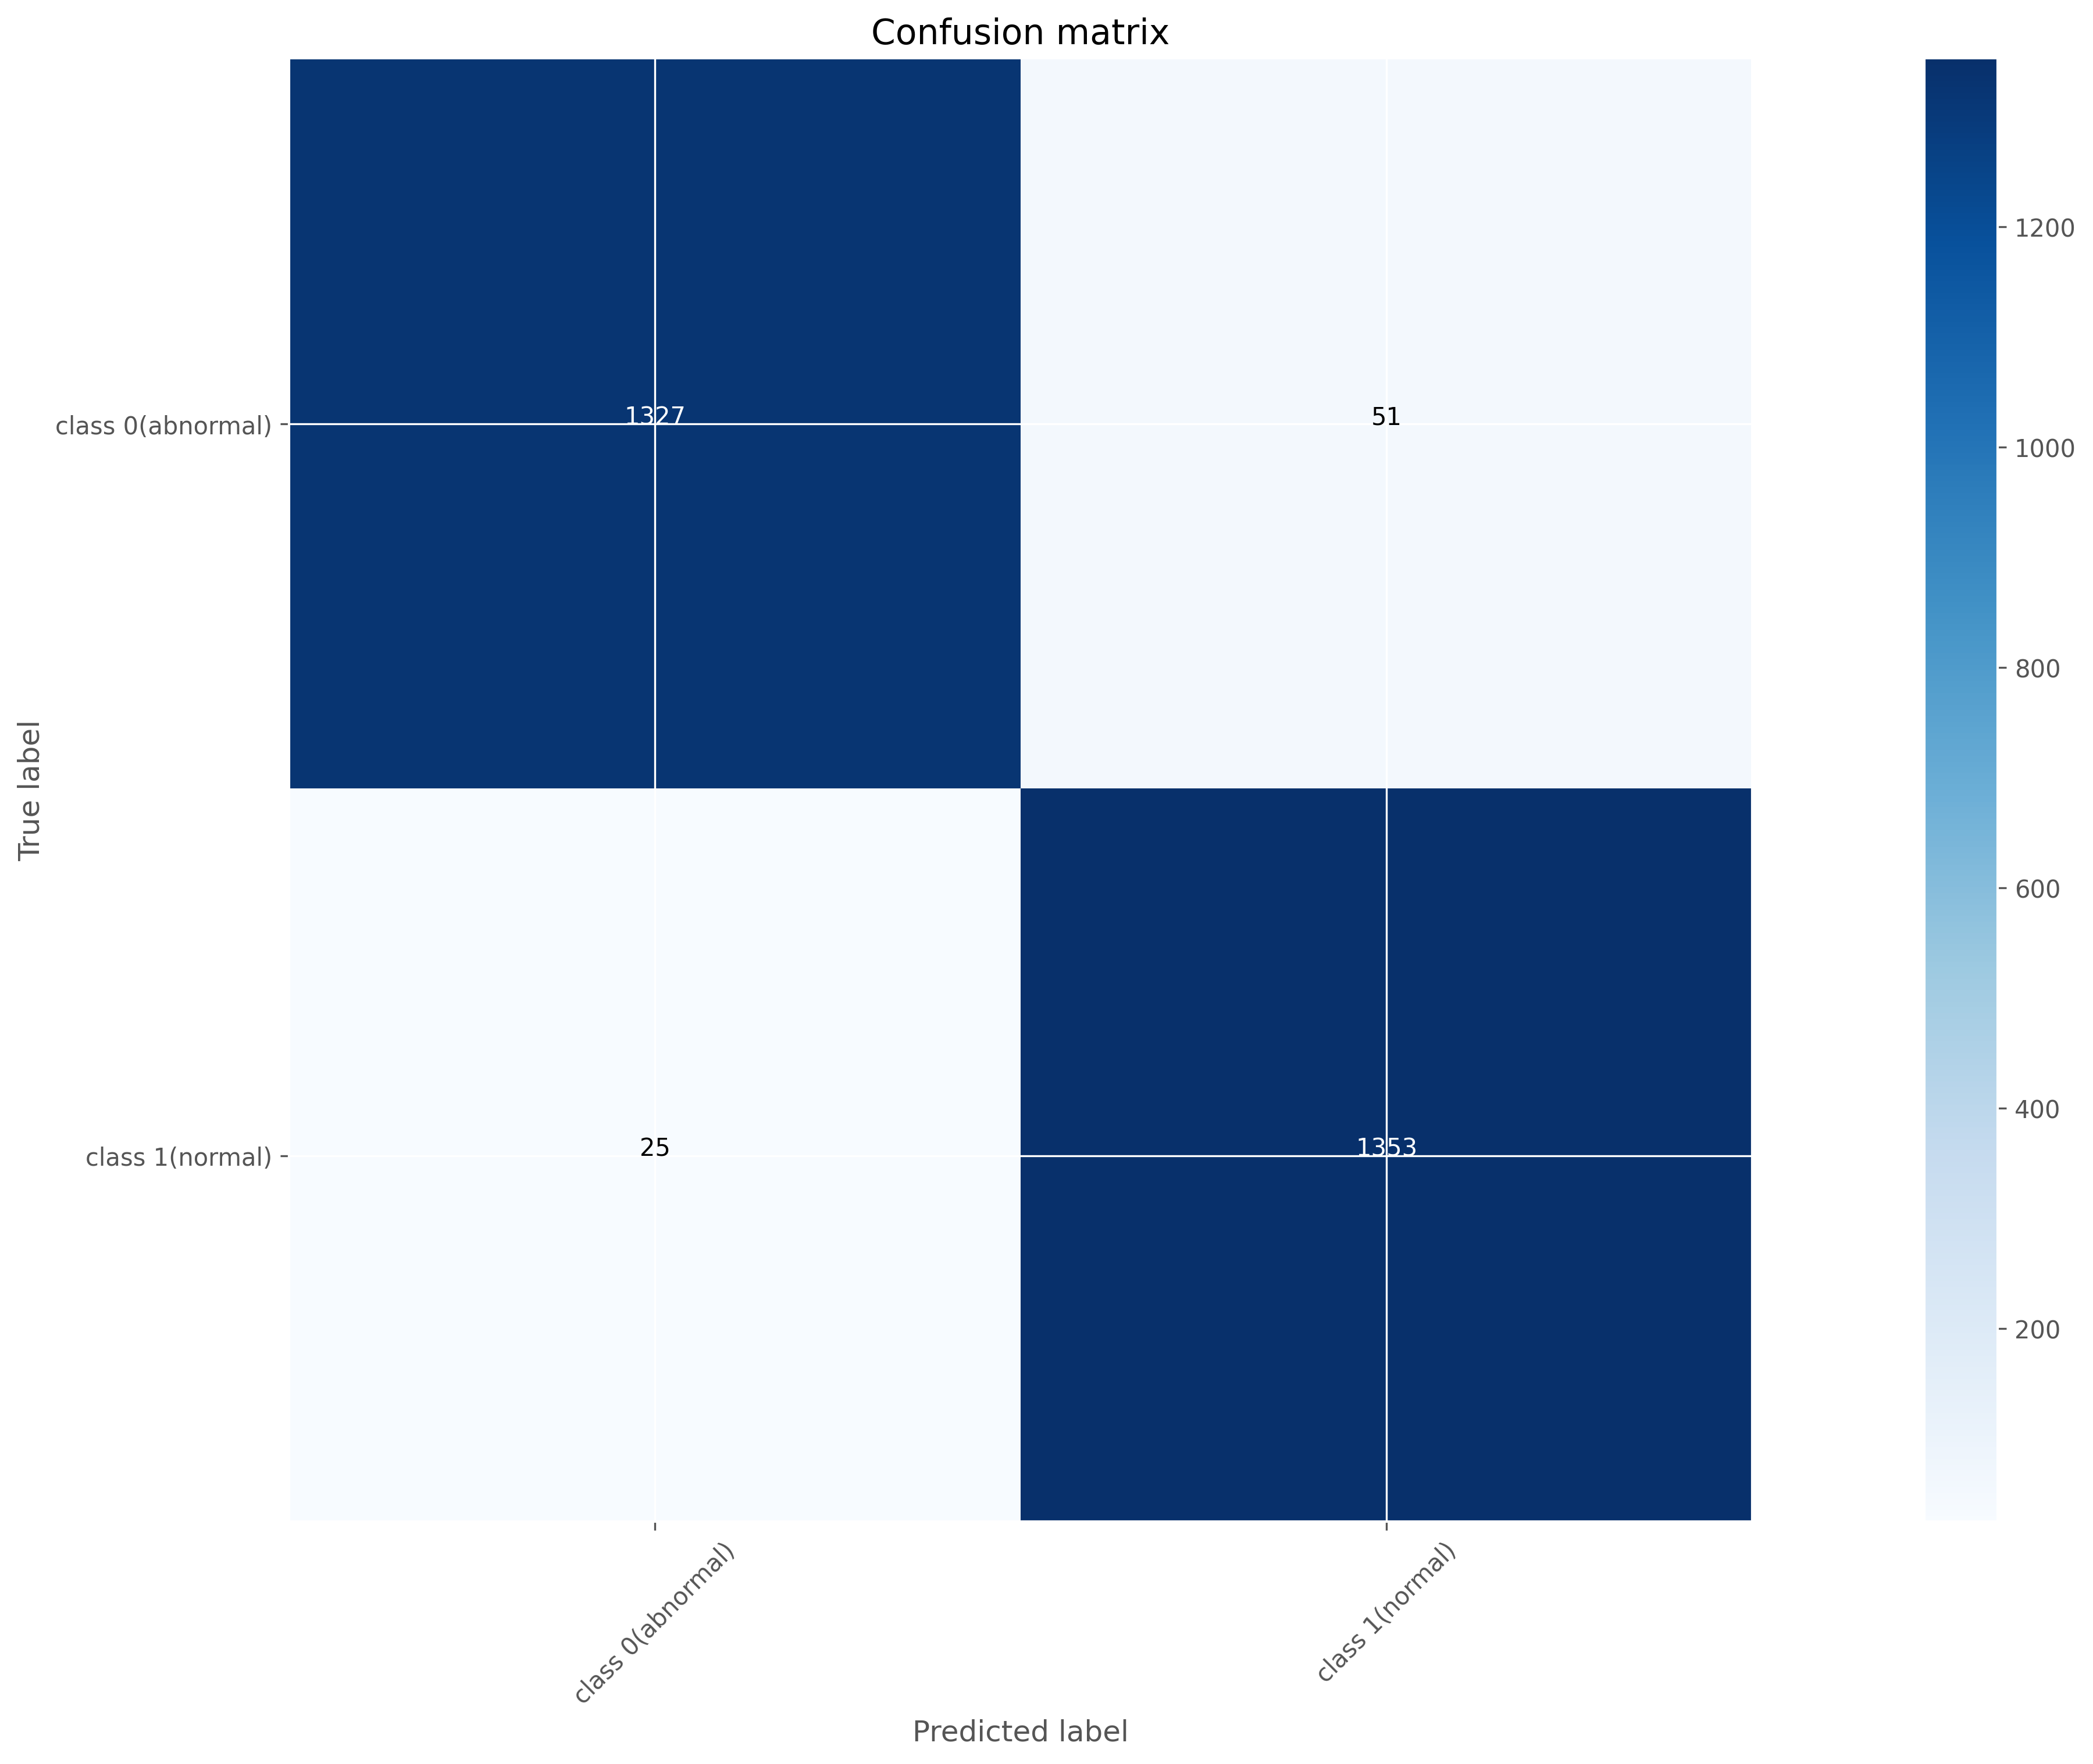

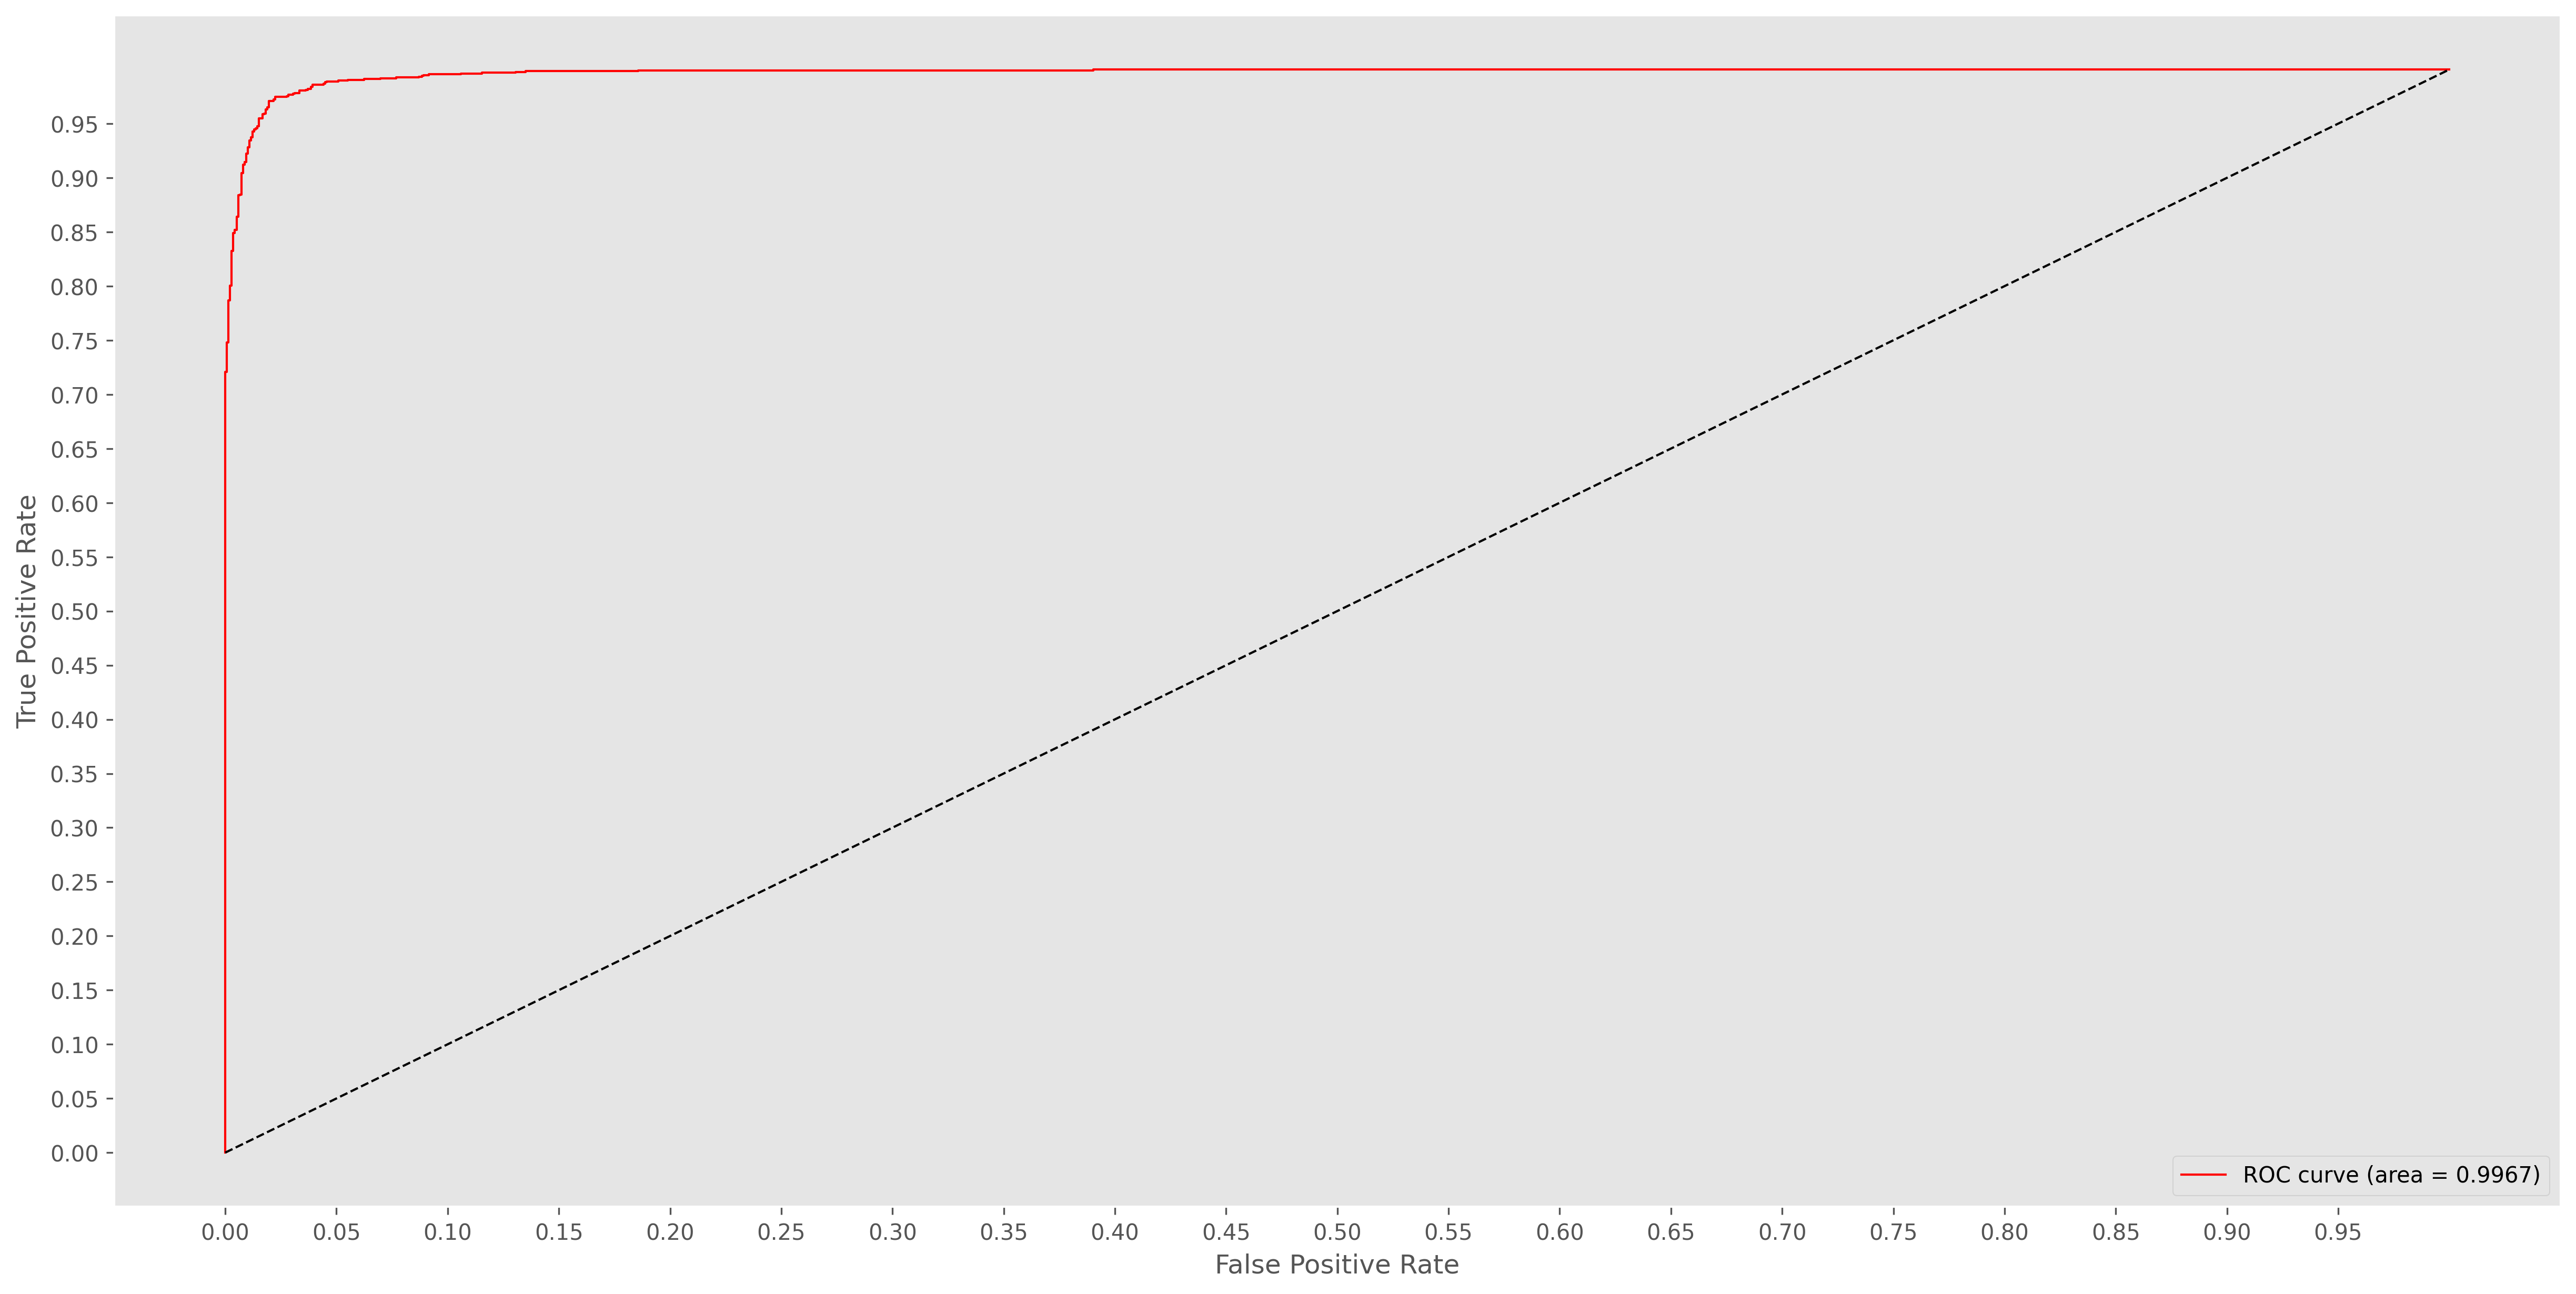

In [240]:
#%% Pair H

pair_H_ensemble_model = ensemble(pair_H, model_input)
pair_H_ensemble_model.save('weights/ensemblemodel_pairH.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
H_ensem_y_pred = pair_H_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
H_ensemble_model_accuracy = accuracy_score(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair H_ Ensemble model is: ', H_ensemble_model_accuracy)

#evaluate mean squared error
H_ensemble_model_custom_mse = mean_squared_error(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_mse)

#evaluate mean squared log error
H_ensemble_model_custom_msle = mean_squared_log_error(Y_test,H_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,H_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, H_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_33')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_34')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_35')>]
The Ensemble Model is Saved
The accuracy of the Pair I_ Ensemble model is:  0.9760522496371553
The Mean Squared Error of the Pair I_ Ensemble model is:  0.023947750362844702
The Mean Squared Log Error of the Pair I_ Ensemble model is:  0.011505768838389439
                   precision    recall  f1-score   support

class 0(abnormal)     0.9838    0.9681    0.9759      1378
  class 1(normal)     0.9686    0.9840    0.9762      1378

         accuracy                         0.9761      2756
        macro avg     0.9762    0.9761    0.9761      2756
     weighted avg     0.9762    0.9761    0.9761      2756

Confusion matrix, without normalization
[[1334   44]
 [  22 1356]]


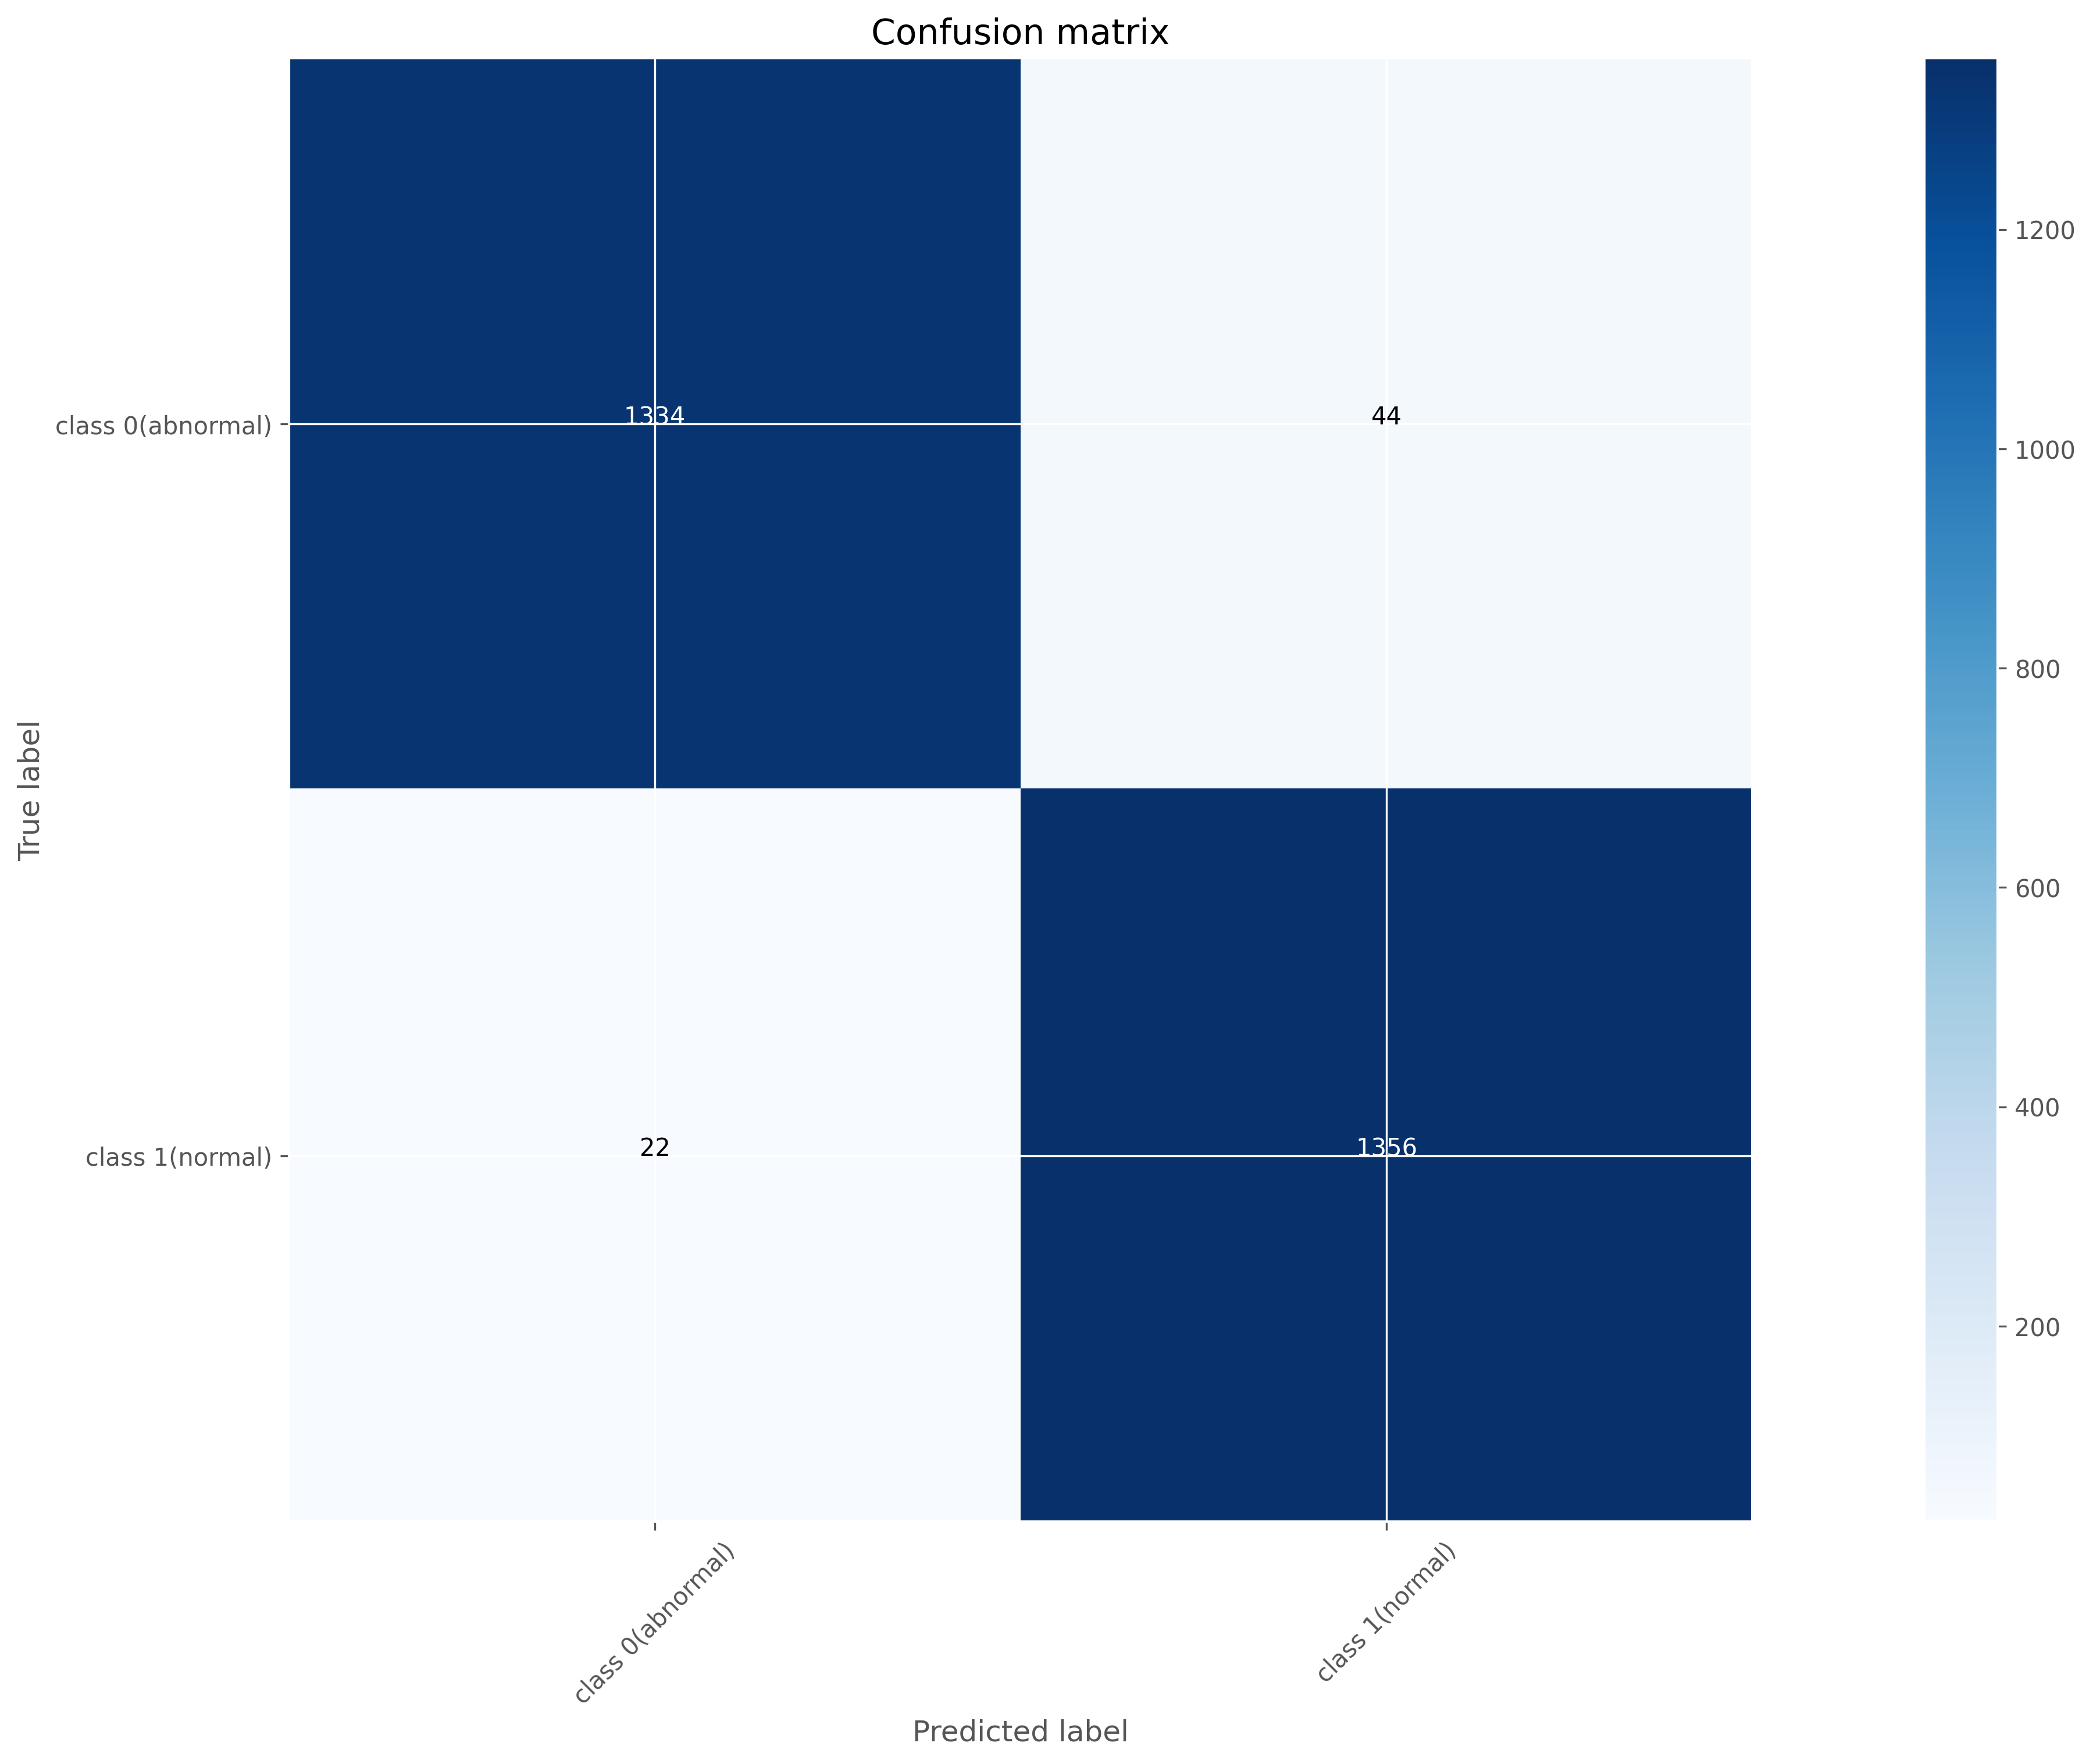

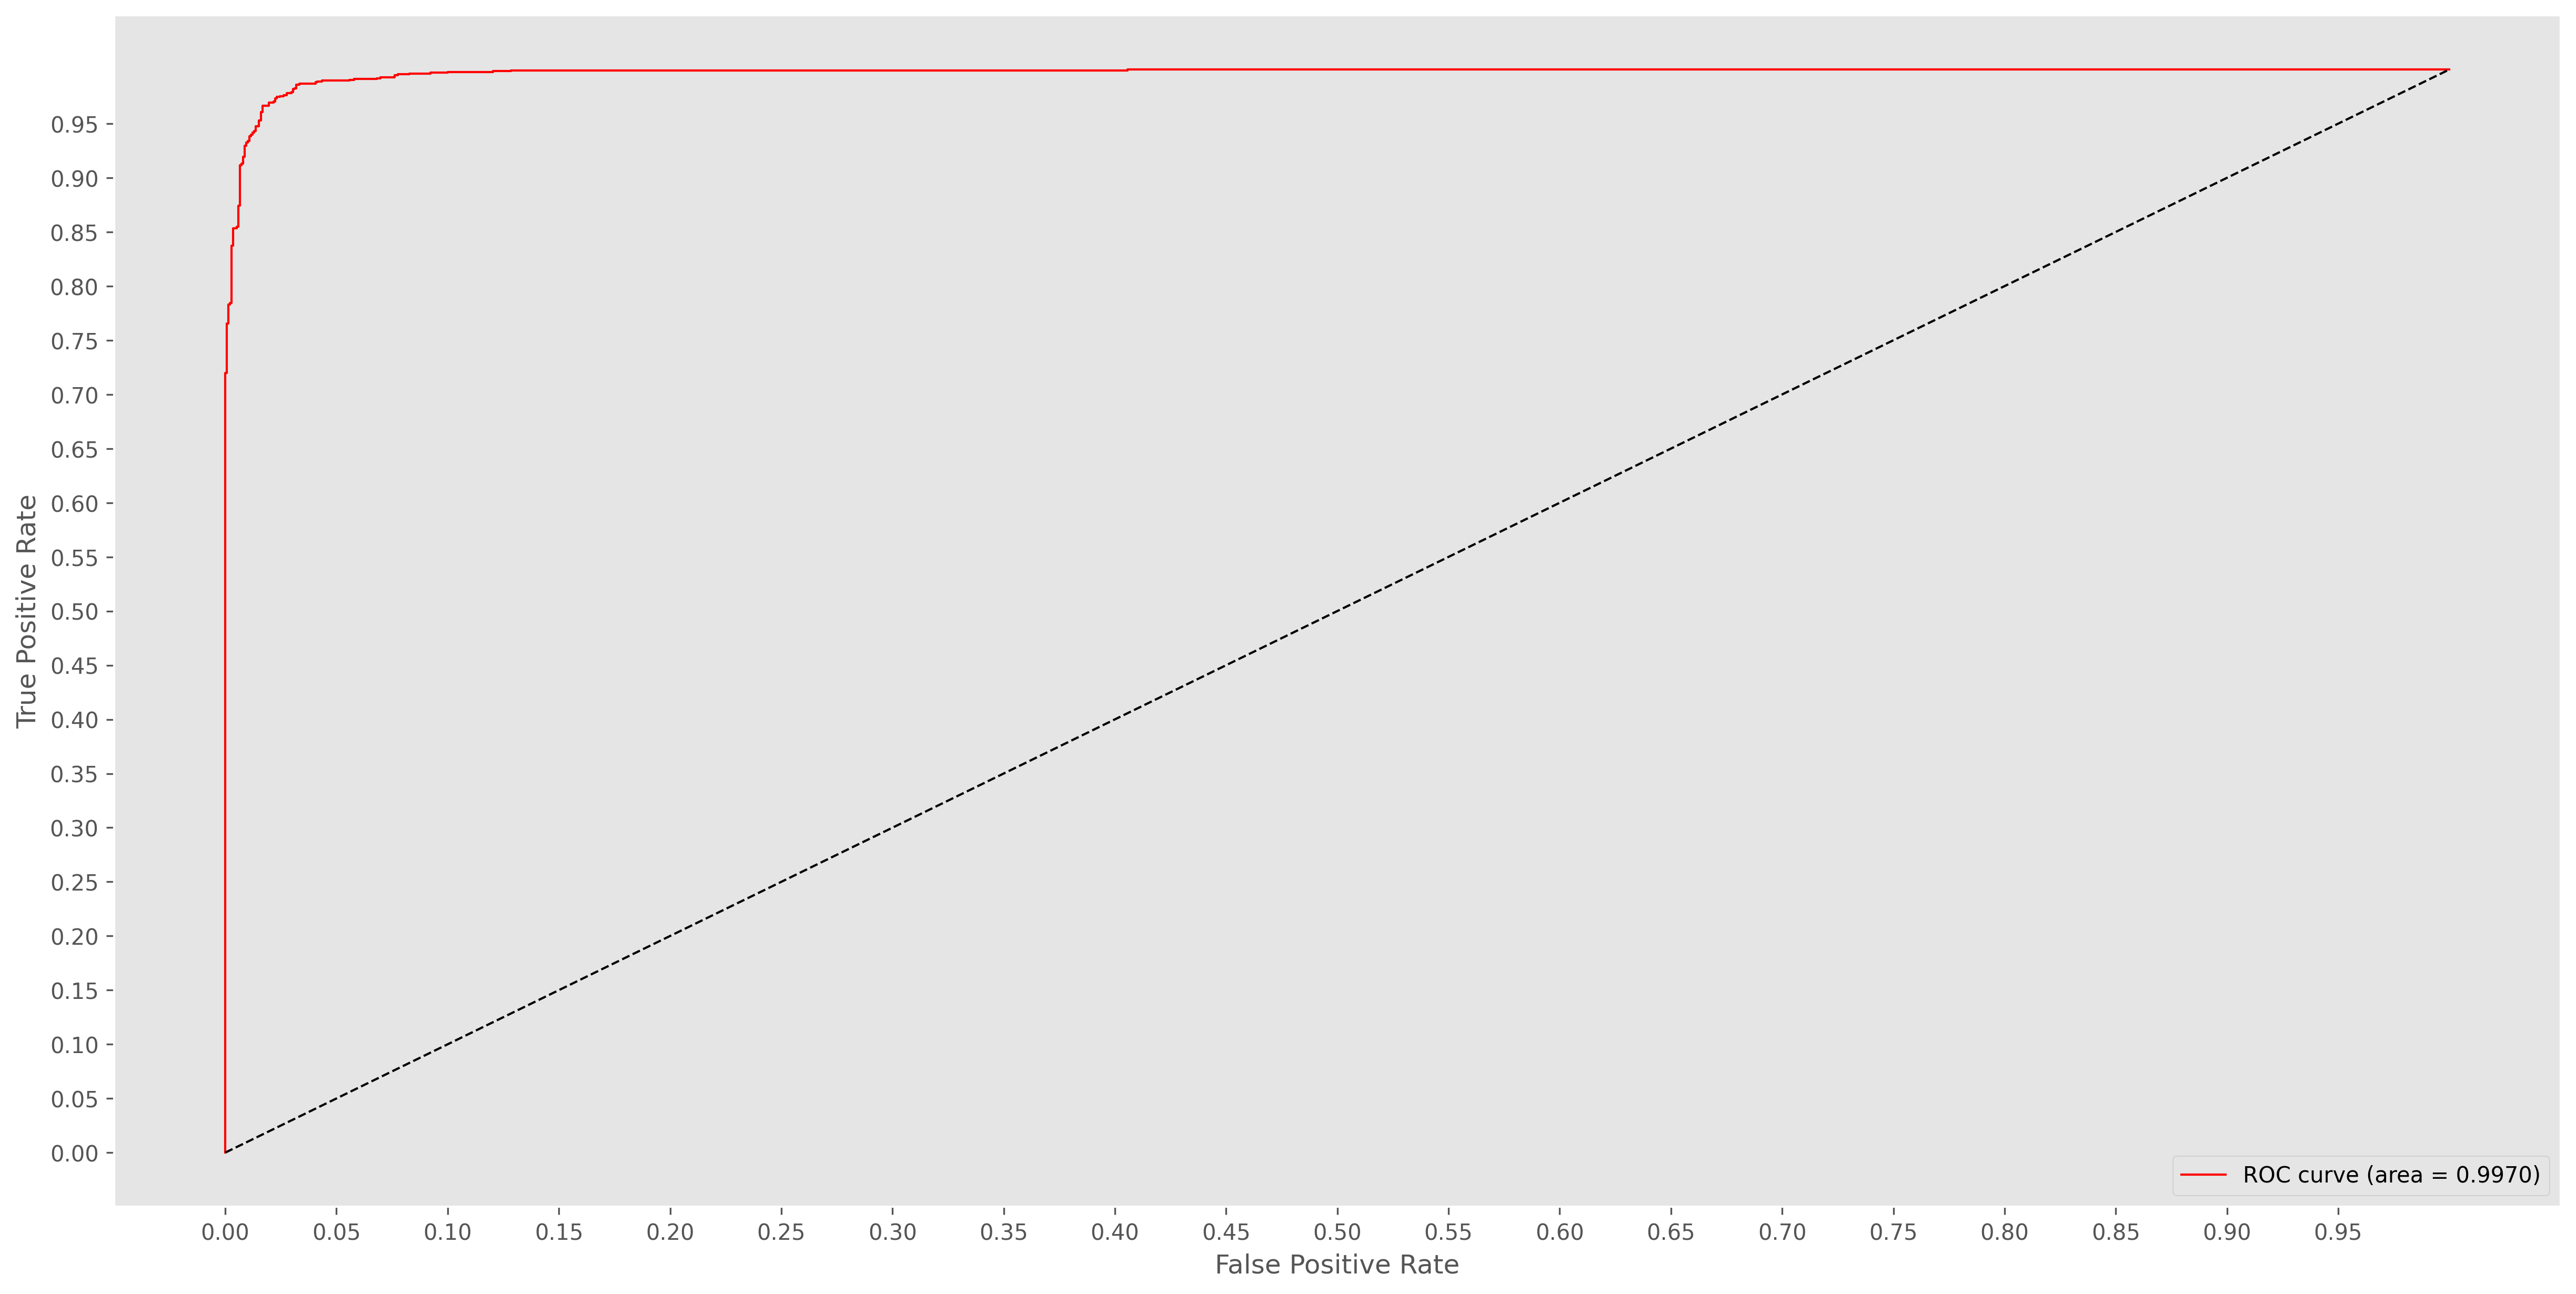

In [241]:
#%% Pair I

pair_I_ensemble_model = ensemble(pair_I, model_input)
pair_I_ensemble_model.save('weights/ensemblemodel_pairI.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
I_ensem_y_pred = pair_I_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
I_ensemble_model_accuracy = accuracy_score(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair I_ Ensemble model is: ', I_ensemble_model_accuracy)

#evaluate mean squared error
I_ensemble_model_custom_mse = mean_squared_error(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_mse)

#evaluate mean squared log error
I_ensemble_model_custom_msle = mean_squared_log_error(Y_test,I_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,I_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,I_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, I_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()